In [1]:
import os
import sys
import uproot
from glob import glob
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns
import datetime
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
NanoAODSchema.warn_missing_crossrefs = False
from coffea.nanoevents.methods import vector
from tqdm.notebook import tqdm

from PhiCPComp import PhiCPComp

In [2]:
#file = "/Users/gsaha/Work/IPHC/HCPtoTauTau/Test1_PhiCP/GluGluHToTauTau_M125/nanoHTT_1.root"

In [3]:
files = glob("/Users/gsaha/Work/IPHC/HCPtoTauTau/Test1_PhiCP/GluGluHToTauTau_M125/nanoHTT_*.root")

In [4]:
#files

In [5]:
eventlist = []
for file in files:
    fptr = uproot.open(file)
    events = NanoEventsFactory.from_root(fptr).events()
    mask_events_with_at_least_two_taus = ak.num(events.Tau.pt, axis=1) >= 2
    events = events[mask_events_with_at_least_two_taus]
    eventlist.append(events)

In [6]:
eventlist[0].GenPart.pdgId

<Array [[21, 21, 25, 25, ... 22, 22, 22, 22]] type='685609 * var * int32[paramet...'>

In [7]:
eventlist[1].GenPart.pdgId

<Array [[2212, 2212, 21, 21, ... 111, 11, -11]] type='684485 * var * int32[param...'>

In [8]:
eventlist[2].GenPart.pdgId

<Array [[-1, 21, 25, 25, ... 16, -211, 22, 22]] type='339228 * var * int32[param...'>

In [9]:
#events = ak.concatenate([eventlist[0]], axis=0)
events = eventlist[0]

In [10]:
events.GenPart

<GenParticleArray [[GenParticle, ... GenParticle]] type='685609 * var * genParticle'>

In [11]:
#fptr = uproot.open(file)
#fptr

In [12]:
#fptr.keys()

In [13]:
#events = NanoEventsFactory.from_root(fptr).events()
#events

In [14]:
type(events)

coffea.nanoevents.methods.base.NanoEventsArray

In [15]:
#for i in events.fields:
#    temp = events[i].fields
#    print(f"{i}\n{temp}\n")

In [16]:
# tau mask
#mask_events_with_at_least_two_taus = ak.num(events.Tau.pt, axis=1) >= 2
#mask_events_with_at_least_two_taus

In [17]:
#events = events[mask_events_with_at_least_two_taus]
#events

In [18]:
events.Tau.pt

<Array [[26.8, 21.2], ... 72.3, 24.5, 19.4]] type='685609 * var * float32[parame...'>

In [19]:
#HLTs = [path for path in events.HLT.fields if path.startswith("DoubleMedium")]

In [20]:
"""
def get_mom(idxs):
    gens = events.GenPart[idxs]
    mompid = gens.parent.pdgId
    gmompid = gens.parent.parent.pdgId
    ggmompid = gens.parent.parent.parent.pdgId
    mompid = ak.where(gens.pdgId == mompid, 
                      gmompid,
                      ak.where(gens.pdgId == gmompid, ggmompid, gmompid))
    return mompid
"""

'\ndef get_mom(idxs):\n    gens = events.GenPart[idxs]\n    mompid = gens.parent.pdgId\n    gmompid = gens.parent.parent.pdgId\n    ggmompid = gens.parent.parent.parent.pdgId\n    mompid = ak.where(gens.pdgId == mompid, \n                      gmompid,\n                      ak.where(gens.pdgId == gmompid, ggmompid, gmompid))\n    return mompid\n'

In [21]:
# get the genpart local indices
genidxs = ak.local_index(events.GenPart.pdgId)
#genidxs = ak.local_index(events.pdgId)
genidxs

<Array [[0, 1, 2, 3, 4, ... 18, 19, 20, 21]] type='685609 * var * int64'>

In [22]:
# prepare masks to select taus 

is_taum_from_h = (events.GenPart.pdgId == 15) & (events.GenPart.hasFlags(["isFirstCopy"])) & (events.GenPart.parent.pdgId == 25)
is_taup_from_h = (events.GenPart.pdgId == -15) & (events.GenPart.hasFlags(["isFirstCopy"])) & (events.GenPart.parent.pdgId == 25)

is_taum_from_h = ak.fill_none(is_taum_from_h, False)
is_taup_from_h = ak.fill_none(is_taup_from_h, False)
is_taum_from_h, is_taup_from_h
"""
is_taum_from_h = (events.pdgId == 15) & (events.hasFlags(["isFirstCopy"])) & (events.parent.pdgId == 25)
is_taup_from_h = (events.pdgId == -15) & (events.hasFlags(["isFirstCopy"])) & (events.parent.pdgId == 25)

is_taum_from_h = ak.fill_none(is_taum_from_h, False)
is_taup_from_h = ak.fill_none(is_taup_from_h, False)
is_taum_from_h, is_taup_from_h
"""

'\nis_taum_from_h = (events.pdgId == 15) & (events.hasFlags(["isFirstCopy"])) & (events.parent.pdgId == 25)\nis_taup_from_h = (events.pdgId == -15) & (events.hasFlags(["isFirstCopy"])) & (events.parent.pdgId == 25)\n\nis_taum_from_h = ak.fill_none(is_taum_from_h, False)\nis_taup_from_h = ak.fill_none(is_taup_from_h, False)\nis_taum_from_h, is_taup_from_h\n'

In [23]:
# get the indices of the selected taus
taum_idxs = genidxs[is_taum_from_h]
taup_idxs = genidxs[is_taup_from_h]
taum_idxs, taup_idxs

(<Array [[4], [7], [6], ... [6], [6], [4]] type='685609 * var * int64'>,
 <Array [[5], [8], [7], ... [7], [7], [5]] type='685609 * var * int64'>)

In [24]:
ak.max(ak.num(taup_idxs))

1

In [25]:
np.unique(ak.ravel(ak.sort(events.GenPart[taum_idxs].status, ascending=False, axis=0)).to_numpy())
#np.unique(ak.ravel(ak.sort(events[taum_idxs].status, ascending=False, axis=0)).to_numpy())

array([ 2, 23], dtype=int32)

In [26]:
# Get the children

taum_decay = events.GenPart[taum_idxs].children
taup_decay = events.GenPart[taup_idxs].children
"""
taum_decay = events[taum_idxs].children
taup_decay = events[taup_idxs].children
"""
#taum_decay = ak.firsts(genpart[taum_idxs].children)
#taup_decay = ak.firsts(genpart[taup_idxs].children)


#loop_taum = ak.sum((taum_decay.pdgId == 15), axis=1)[..., None][...,:]
#loop_taup = ak.sum((taup_decay.pdgId == -15), axis=1)[..., None][...,:]

taum_decay.pdgId[:2], taup_decay.pdgId[:2]

(<Array [[[15]], ... [16, 111, 111, 111, -211]]] type='2 * var * var * ?int32[par...'>,
 <Array [[[-15]], [[-16, 111, 211]]] type='2 * var * var * ?int32[parameters={"__...'>)

In [27]:
hasloop_taum = ak.sum(taum_decay.pdgId == 15, axis=-1)
hasloop_taup = ak.sum(taup_decay.pdgId == -15, axis=-1)
hasloop_taum, hasloop_taup

(<Array [[1], [0], [0], ... [1], [1], [0]] type='685609 * var * int64'>,
 <Array [[1], [0], [0], ... [1], [1], [0]] type='685609 * var * int64'>)

In [28]:
taum_decay_decay = ak.firsts(taum_decay.children, axis=2)
taup_decay_decay = ak.firsts(taup_decay.children, axis=2)

In [29]:
taum_decay_decay.pdgId[:2], taup_decay_decay.pdgId[:2]

(<Array [[[16, 111, -211]], [[]]] type='2 * var * option[var * ?int32[parameters=...'>,
 <Array [[[-16, 111, 211]], [[]]] type='2 * var * option[var * ?int32[parameters=...'>)

In [30]:
taum_children = ak.where(hasloop_taum == 0, taum_decay, taum_decay_decay)
taup_children = ak.where(hasloop_taup == 0, taup_decay, taup_decay_decay)

In [31]:
taum_children.pdgId

<Array [[[16, 111, -211], ... [16, 111, -211]]] type='685609 * var * option[var ...'>

In [32]:
taup_children.pdgId

<Array [[[-16, 111, 211], ... 211, 211, -211]]] type='685609 * var * option[var ...'>

In [33]:
for i in range(10):
    print(f"idx: {i}\ttaum decay: {taum_children.pdgId[i]}\t\t\ttaup decay: {taup_children.pdgId[i]}\n")

idx: 0	taum decay: [[16, 111, -211]]			taup decay: [[-16, 111, 211]]

idx: 1	taum decay: [[16, 111, 111, 111, -211]]			taup decay: [[-16, 111, 211]]

idx: 2	taum decay: [[16, 111, -211, -211, 211]]			taup decay: [[-16, 211, 211, -211]]

idx: 3	taum decay: [[16, -211, -211, 211]]			taup decay: [[-16, 211]]

idx: 4	taum decay: [[16, -211]]			taup decay: [[-16, 211, 211, -211]]

idx: 5	taum decay: [[16, 111, -211, -311]]			taup decay: [[-16, 211, 211, -211]]

idx: 6	taum decay: [[16, -211, -211, 211]]			taup decay: [[-16, 211, 211, -211]]

idx: 7	taum decay: [[16, 111, -211]]			taup decay: [[-16, 111, 211]]

idx: 8	taum decay: [[16, 13, -14]]			taup decay: [[-16, 211]]

idx: 9	taum decay: [[16, 111, 111, -211]]			taup decay: [[-16, 111, 211, 211, -211]]



In [34]:
temp = ak.sum(taum_children.pdgId == -211, axis=-1)
temp[0], temp[1], temp[2]

(<Array [1] type='1 * ?int64'>,
 <Array [1] type='1 * ?int64'>,
 <Array [2] type='1 * ?int64'>)

In [35]:
events.GenPart

<GenParticleArray [[GenParticle, ... GenParticle]] type='685609 * var * genParticle'>

In [36]:
taum = events.GenPart[taum_idxs]#.GenPart[taum_idxs]
taup = events.GenPart[taup_idxs]#.GenPart[taup_idxs]
taum.pdgId, taup.pdgId

(<Array [[15], [15], [15], ... [15], [15], [15]] type='685609 * var * int32[param...'>,
 <Array [[-15], [-15], ... [-15], [-15]] type='685609 * var * int32[parameters={"...'>)

In [37]:
taum_children_2 = ak.firsts(taum_children, axis=1)
taup_children_2 = ak.firsts(taup_children, axis=1)
taum_children_2.pdgId, taup_children_2.pdgId

(<Array [[16, 111, -211], ... [16, 111, -211]] type='685609 * option[var * ?int32...'>,
 <Array [[-16, 111, 211], ... 211, 211, -211]] type='685609 * option[var * ?int32...'>)

In [38]:
mask = (ak.num(taum_children_2.pdgId, axis=1) > 0) & (ak.num(taup_children_2.pdgId, axis=1) > 0)

In [39]:
mask

<Array [True, True, True, ... True, True, True] type='685609 * ?bool'>

In [40]:
taum = taum[mask]
taum_children = taum_children_2[mask]

taup = taup[mask]
taup_children = taup_children_2[mask]

taum.pdgId, taum_children.pdgId, taup.pdgId, taup_children.pdgId

(<Array [[15], [15], [15], ... [15], [15], [15]] type='684456 * option[var * int3...'>,
 <Array [[16, 111, -211], ... [16, 111, -211]] type='684456 * option[var * ?int32...'>,
 <Array [[-15], [-15], ... [-15], [-15]] type='684456 * option[var * int32[parame...'>,
 <Array [[-16, 111, 211], ... 211, 211, -211]] type='684456 * option[var * ?int32...'>)

In [41]:
tmp = ak.num(taum_children.pdgId, axis=1) == 1
tmp

<Array [False, False, False, ... False, False] type='684456 * ?bool'>

In [42]:
taum.mass

<Array [[0], [0], [0], ... [0], [0], [0]] type='684456 * option[var * float32[pa...'>

In [43]:
def getp4(genarr: ak.Array, setmass=False) -> ak.Array:
    if setmass:
        return ak.zip(
        {
            "pt": genarr.pt,
            "eta": genarr.eta,
            "phi": genarr.phi,
            "mass": genarr.mass + 1.778,
            "pdgId": genarr.pdgId                                                                                                                                                                                                     
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior)
    
    else:
        return ak.zip(
        {
            "pt": genarr.pt,
            "eta": genarr.eta,
            "phi": genarr.phi,
            "mass": genarr.mass,
            "pdgId": genarr.pdgId                                                                                                                                                                                                     
        },
        with_name="PtEtaPhiMLorentzVector",
        behavior=vector.behavior)


def plotit(arrlist=[], bins=100, log=False, dim=(1,1)):
    print(" ---> Plotting ---> ")
    if len(arrlist) > 1 :
        fig, axs = plt.subplots(dim[0], dim[1], figsize=(2.5*dim[1], 2.5))
        for i,arr in enumerate(arrlist):
            axs[i].hist(arr, bins, density=True, log=log, alpha=0.7)
    else:
        fig, ax = plt.subplots()
        ax.hist(arrlist[0], bins, density=True, log=log, alpha=0.7)

    fig.tight_layout()
    plt.show()


In [44]:
ak.max(ak.ravel(taum.mass).to_numpy())

0.0

 ---> Plotting ---> 


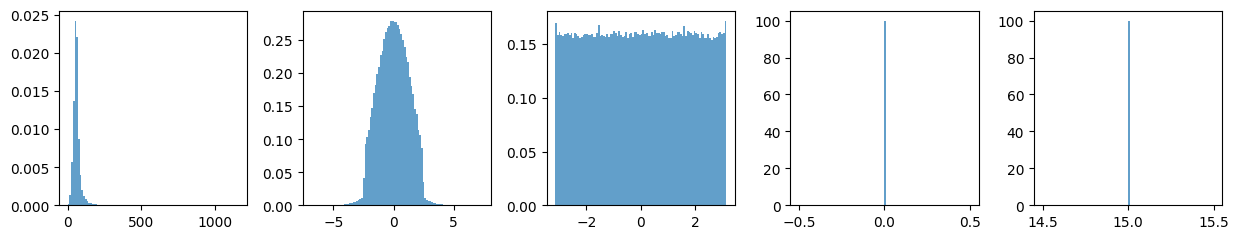

In [45]:
plotit(arrlist=[ak.ravel(taum.pt).to_numpy(),
                ak.ravel(taum.eta).to_numpy(),
                ak.ravel(taum.phi).to_numpy(),
                ak.ravel(taum.mass).to_numpy(),
                ak.ravel(taum.pdgId).to_numpy()], dim=(1,5))

 ---> Plotting ---> 


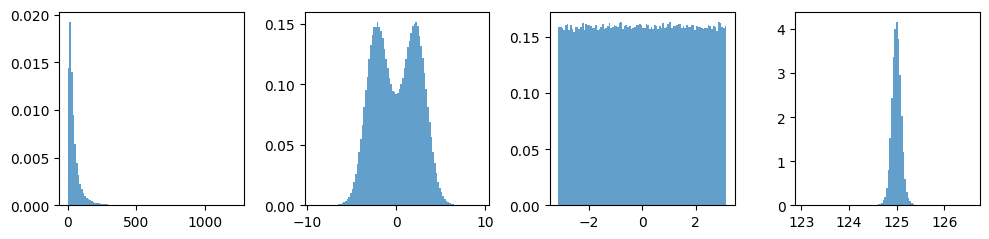

In [46]:
hp4 = getp4(taum, True) + getp4(taup, True)
plotit(arrlist=[ak.ravel(hp4.pt).to_numpy(),
                ak.ravel(hp4.eta).to_numpy(),
                ak.ravel(hp4.phi).to_numpy(),
                ak.ravel(hp4.mass).to_numpy()], dim=(1,4))

## Categorise events 

In [47]:
def plothist(arrlist=[], bins=None, log=False):
    arr = arrlist[0]
    fig, ax = plt.subplots()
    for arr in arrlist:
        ax.hist(arr, bins, density=True, log=log, alpha=0.5)
    fig.tight_layout()
    plt.show()

In [48]:
"""
phicp_obj = PhiCPComp(cat="pipi", 
                      taum=taum,
                      taup=taup,
                      taum_decay=taum_children,
                      taup_decay=taup_children)
phicp = phicp_obj.comp_phiCP()
phicp
"""

'\nphicp_obj = PhiCPComp(cat="pipi", \n                      taum=taum,\n                      taup=taup,\n                      taum_decay=taum_children,\n                      taup_decay=taup_children)\nphicp = phicp_obj.comp_phiCP()\nphicp\n'

 --- comp_phiCP --- 
 --- gethvecs --- 
 --- gethvecs_a1a1 --- 
Selection of a1-a1 pair [mask]: [False, False, False, False, False, False, ... False, False, False, False, False]
n total events: 684456
n selected events: 14014
Opposite ?????? [[3.14], [-3.14], [-3.14], [3.14], [-3.14, ... [3.14], [-3.14], [-3.14], [-3.14]]
 ---> Plotting ---> 


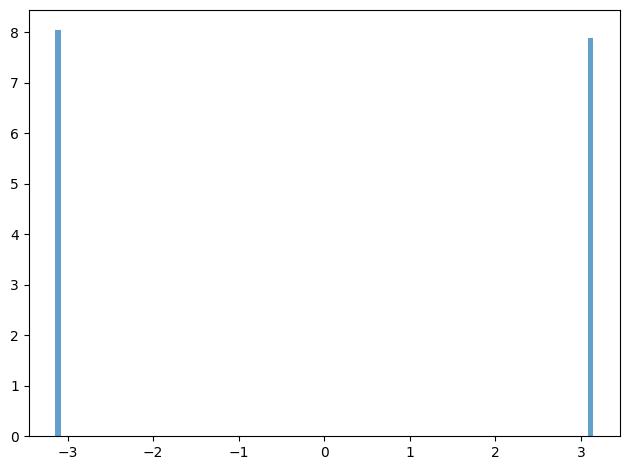

 --- gethvec_a1 --- 
  ===> tau in lab frame ===>
    px: [[-48.1], [-59.3], [-45], [44.3], [39.5, ... [34.7], [44.7], [-32.6], [-60.9]]
    py: [[-10.7], [-42.2], [-26.5], [-21.3], [-32.2, ... -42.6], [47.4], [1.89], [-46], [24]]
    pz: [[-11.7], [121], [47], [-97.2], [-5.55], ... [179], [16.7], [32.3], [45.9], [-21.7]]
    E: [[50.7], [141], [70.3], [109], [51.3], ... [188], [61.1], [55.2], [72.7], [69]]
 ---> Plotting ---> 


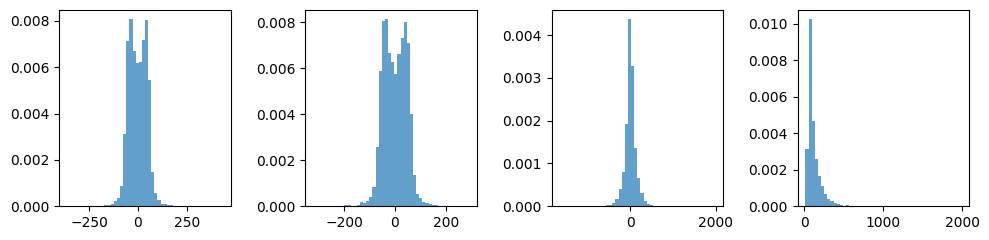

    pt: [[49.2], [72.8], [52.2], [49.1], [51], ... [57], [58.8], [44.8], [56.4], [65.5]]
    eta: [[-0.236], [1.28], [0.809], [-1.43], ... [0.281], [0.67], [0.744], [-0.325]]
    phi: [[-2.92], [-2.52], [-2.61], [-0.449], ... [0.939], [0.0424], [-2.19], [2.77]]
    M: [[1.78], [1.78], [1.78], [1.78], [1.78], ... [1.78], [1.78], [1.78], [1.78], [1.78]]
 ---> Plotting ---> 


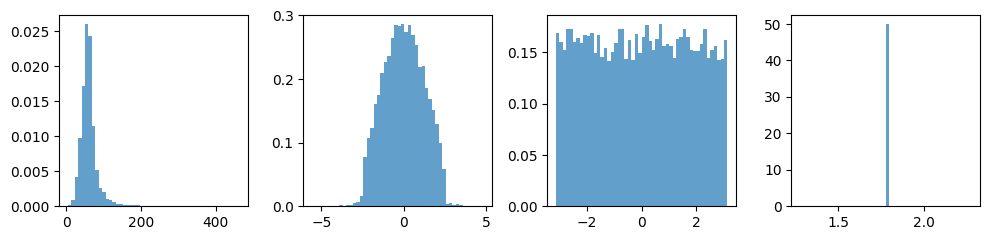

  ===> os pion in lab frame ===>
    px: [[-4.78], [-13.8], [-3.74], [12], [0.517, ... [5.76], [8.1], [-10.7], [-25.7]]
    py: [[-0.644], [-9.64], [-2.09], [-5.33], ... [7.98], [0.573], [-15.3], [9.92]]
    pz: [[-0.966], [27.6], [3.5], [-26.2], [-0.143, ... 46], [2.58], [6.06], [15.8], [-8.98]]
    E: [[4.92], [32.3], [5.53], [29.3], [0.714], ... [48.2], [10.2], [10.1], [24.5], [29]]
 ---> Plotting ---> 


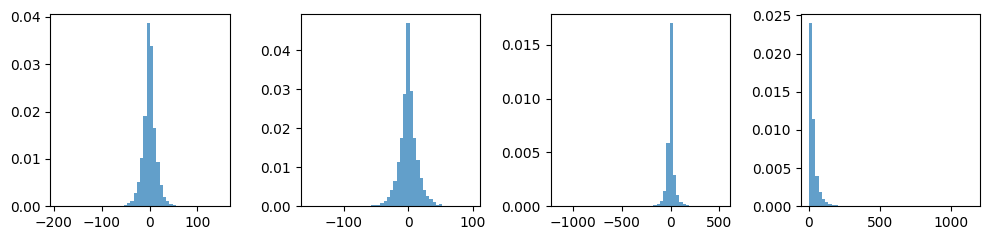

    pt: [[4.83], [16.8], [4.28], [13.1], [0.699], ... [14.2], [9.84], [8.12], [18.7], [27.6]]
    eta: [[-0.199], [1.27], [0.746], [-1.45], ... [0.259], [0.689], [0.77], [-0.32]]
    phi: [[-3.01], [-2.53], [-2.63], [-0.419], ... [0.945], [0.0706], [-2.18], [2.77]]
    M: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
 ---> Plotting ---> 


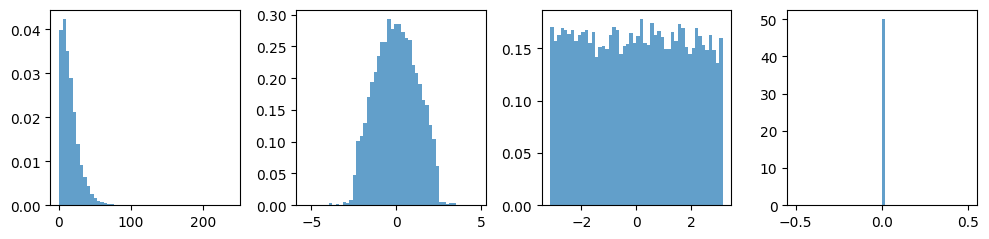

  ===> ss pion1 in lab frame ===>
    px: [[-2.45], [-14.6], [-34.1], [13.8], [18.2, ... [10.7], [7.19], [-10.2], [-13.7]]
    py: [[-0.648], [-10.4], [-18.7], [-6.78], [-14.9, ... [13.7], [0.13], [-14.6], [5.16]]
    pz: [[-0.639], [30.7], [34.2], [-29.6], [-2.04, ... [5.25], [4.66], [14.3], [-5.22]]
    E: [[2.61], [35.5], [51.8], [33.4], [23.7], ... [57.9], [18.2], [8.56], [22.9], [15.5]]
 ---> Plotting ---> 


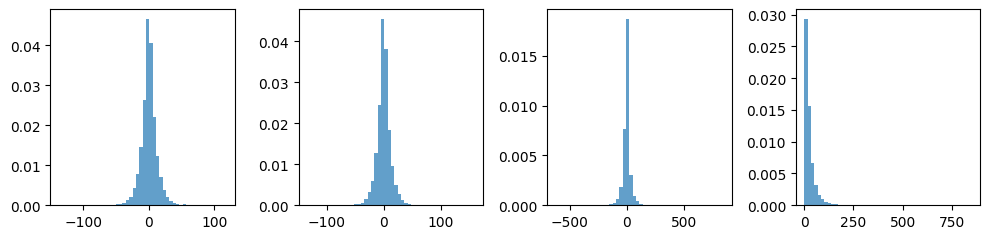

    pt: [[2.53], [17.9], [38.9], [15.4], [23.6], ... [17.6], [17.4], [7.19], [17.8], [14.6]]
    eta: [[-0.25], [1.31], [0.793], [-1.41], ... [0.298], [0.609], [0.736], [-0.35]]
    phi: [[-2.88], [-2.52], [-2.64], [-0.457], ... [0.906], [0.0181], [-2.18], [2.78]]
    M: [[0.14], [0.14], [0.14], [0.14], [0.14], ... [0.14], [0.14], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


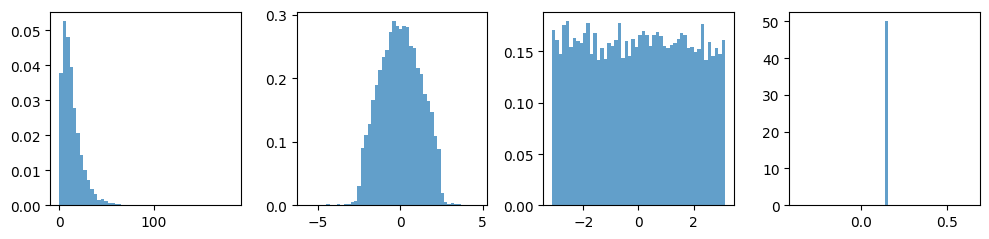

  ===> ss pion2 in lab frame ===>
    px: [[-9.4], [-18.5], [-4.63], [11.7], [15.3, ... [4.35], [16.5], [-7.15], [-18.6]]
    py: [[-2.33], [-12.7], [-2.54], [-5.75], [-12.3, ... [5.78], [0.944], [-10.3], [7.68]]
    pz: [[-2.35], [36.6], [4.4], [-25.3], [-2.31], ... 28.5], [1.96], [11.8], [9.9], [-6.35]]
    E: [[9.97], [42.9], [6.87], [28.4], [19.8], ... [29.9], [7.5], [20.3], [15.9], [21.1]]
 ---> Plotting ---> 


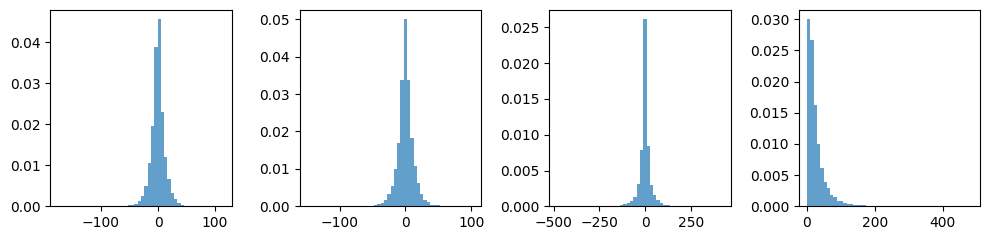

    pt: [[9.69], [22.4], [5.28], [13.1], [19.6], ... [9.03], [7.23], [16.5], [12.5], [20.1]]
    eta: [[-0.24], [1.27], [0.758], [-1.41], ... [0.268], [0.664], [0.727], [-0.311]]
    phi: [[-2.9], [-2.54], [-2.64], [-0.456], ... [0.926], [0.0573], [-2.18], [2.75]]
    M: [[0.14], [0.14], [0.14], [0.14], [0.14], ... [0.14], [0.14], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


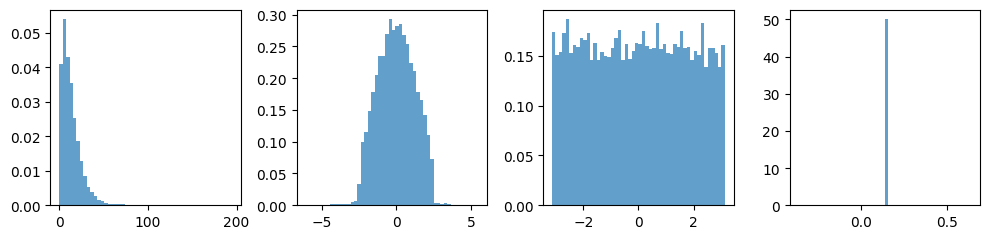

  ===> Boostvec: Higgs Rest Frame ===>
    x: [[0.129], [-0.199], [0.0992], [-0.114], ... [0.00403], [-0.178], [0.103], [-0.35]]
    y: [[0.235], [0.0175], [0.0932], [-0.011], ... [-0.0689], [0.317], [0.00956], [0.419]]
    z: [[0.0587], [0.749], [0.655], [-0.753], ... [0.161], [0.164], [0.485], [0.395]]
 ---> Plotting ---> 


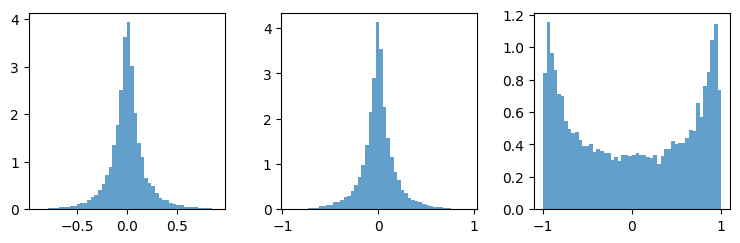

  -ve boost applied on tau and its decay products
  ===> tau in Higgs rest frame ===>
    px: [[-55.5], [-34.4], [-52.6], [56.1], [56.7, ... [34.4], [55.7], [-40], [-34.4]]
    py: [[-24.3], [-44.3], [-33.6], [-20.2], [-10.7, ... [51.7], [-17.6], [-46.7], [-7.6]]
    pz: [[-15.1], [27.5], [-2.9], [-18.8], [24], ... [-19], [6.73], [22.2], [10.9], [-51.5]]
    E: [[62.4], [62.5], [62.5], [62.6], [62.5], ... [62.5], [62.5], [62.5], [62.5], [62.5]]
 ---> Plotting ---> 


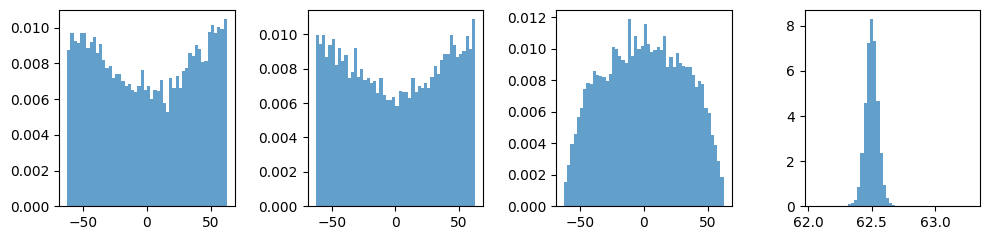

    pt: [[60.6], [56.1], [62.4], [59.6], [57.7], ... [59.5], [62.1], [58.4], [61.5], [35.3]]
    eta: [[-0.247], [0.472], [-0.0465], [-0.31], ... [0.108], [0.372], [0.176], [-1.17]]
    phi: [[-2.73], [-2.23], [-2.57], [-0.345], ... [0.984], [-0.306], [-2.28], [-2.92]]
    M: [[1.78], [1.78], [1.78], [1.78], [1.78], ... [1.78], [1.78], [1.78], [1.78], [1.78]]
 ---> Plotting ---> 


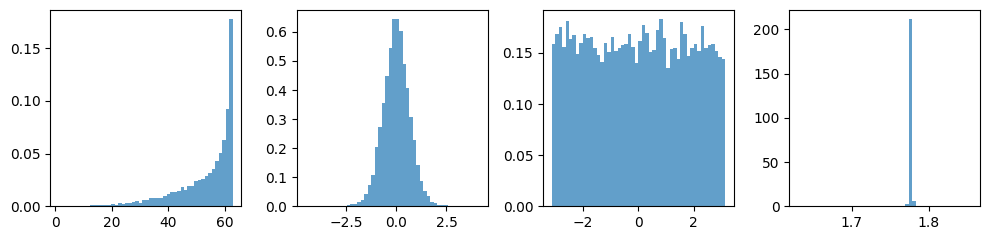

  ===> os pion in Higgs rest frame ===>
    px: [[-5.5], [-8.08], [-4.34], [15.2], [0.747, ... [5.72], [10.1], [-13.2], [-14.6]]
    py: [[-1.95], [-10.1], [-2.65], [-5.02], ... [8.7], [-2.99], [-15.6], [-3.37]]
    pz: [[-1.29], [6.16], [-0.502], [-5.17], [0.252, ... [0.905], [4.22], [4.1], [-21.5]]
    E: [[5.98], [14.4], [5.12], [16.8], [0.809], ... [15.5], [10.4], [11.4], [20.8], [26.2]]
 ---> Plotting ---> 


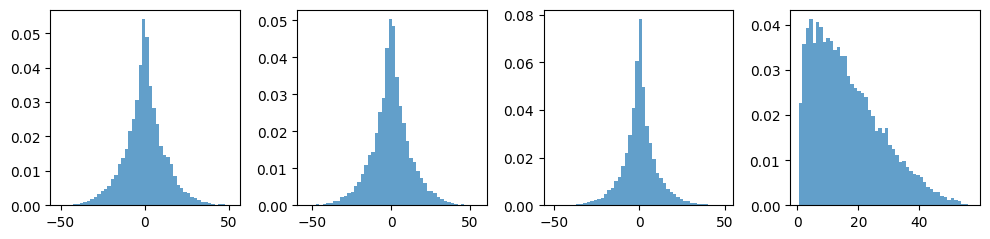

    pt: [[5.83], [13], [5.09], [16], [0.769], ... [14.8], [10.4], [10.5], [20.4], [15]]
    eta: [[-0.22], [0.459], [-0.0984], [-0.318], ... [0.0868], [0.391], [0.2], [-1.16]]
    phi: [[-2.8], [-2.24], [-2.59], [-0.32], ... [0.989], [-0.287], [-2.27], [-2.91]]
    M: [[0.00171], [nan], [nan], [0.00589], ... [nan], [0.00349], [nan], [0.00356]]
 ---> Plotting ---> 


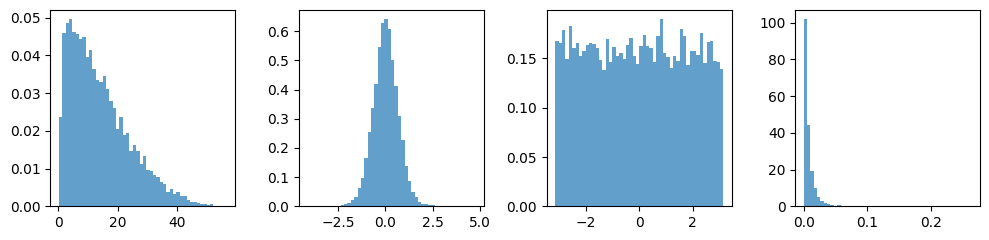

  ===> ss pion1 in Higgs rest frame ===>
    px: [[-2.83], [-8.34], [-39.7], [17.4], [26.2, ... [10.6], [8.9], [-12.5], [-7.66]]
    py: [[-1.35], [-10.9], [-23.9], [-6.43], [-4.95, ... [15], [-2.92], [-14.8], [-2.04]]
    pz: [[-0.815], [7.26], [-2.73], [-5.5], [11.7], ... -5.92], [2.28], [3.08], [3.3], [-12]]
    E: [[3.24], [15.5], [46.4], [19.4], [29.1], ... [19.3], [18.5], [9.87], [19.7], [14.4]]
 ---> Plotting ---> 


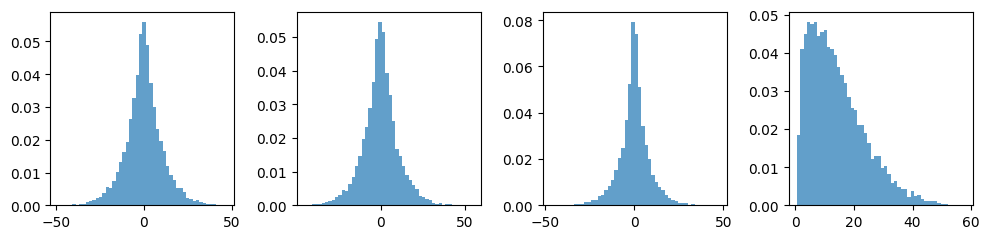

    pt: [[3.14], [13.7], [46.3], [18.6], [26.6], ... [18.4], [18.4], [9.37], [19.4], [7.92]]
    eta: [[-0.257], [0.507], [-0.0589], [-0.292], ... [0.124], [0.323], [0.169], [-1.2]]
    phi: [[-2.7], [-2.22], [-2.6], [-0.353], ... [0.952], [-0.317], [-2.27], [-2.88]]
    M: [[0.14], [0.14], [0.139], [0.14], [0.14, ... 0.139], [0.139], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


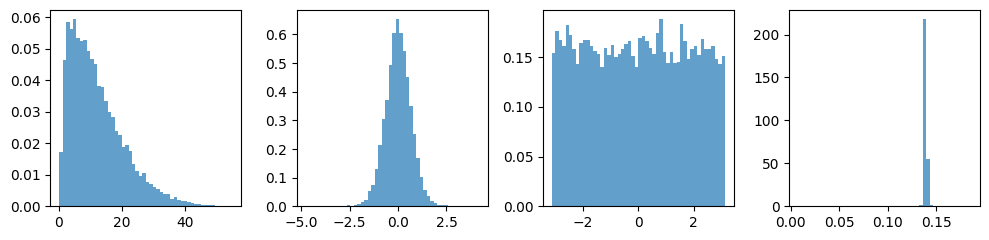

  ===> ss pion2 in Higgs rest frame ===>
    px: [[-10.9], [-10.9], [-5.38], [14.8], [21.9, ... [4.32], [20.5], [-8.79], [-10.6]]
    py: [[-5], [-13.4], [-3.24], [-5.45], [-4.06, ... [6.31], [-6.21], [-10.4], [-1.92]]
    pz: [[-3.02], [8.15], [-0.558], [-4.73], [9.06, ... [0.729], [8.1], [2.19], [-15.4]]
    E: [[12.3], [19.1], [6.31], [16.5], [24], ... [9.94], [7.68], [22.9], [13.8], [18.8]]
 ---> Plotting ---> 


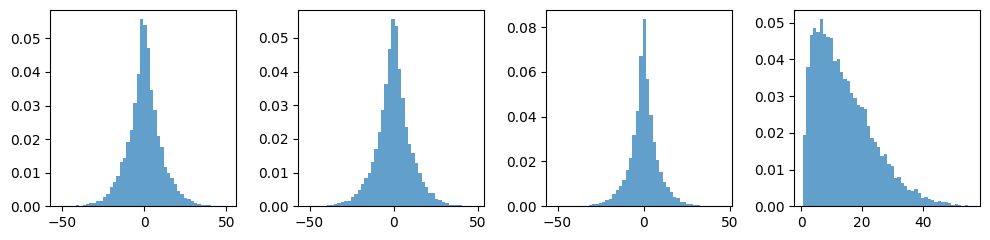

    pt: [[12], [17.3], [6.28], [15.8], [22.2], ... [9.47], [7.64], [21.4], [13.6], [10.7]]
    eta: [[-0.25], [0.456], [-0.0886], [-0.295], ... [0.0953], [0.37], [0.16], [-1.16]]
    phi: [[-2.71], [-2.25], [-2.6], [-0.352], ... [0.97], [-0.294], [-2.27], [-2.96]]
    M: [[0.14], [0.139], [0.14], [0.14], [0.14], ... [0.14], [0.14], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


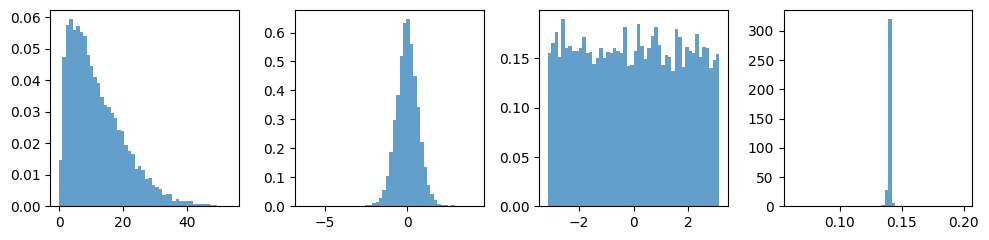

 --- Configure PolarimetricA1 --- : --- Start --- 
 --- Setup --- : --- Start --- 
RF_p4_tau: [[{x: -55.5, y: -24.3, z: -15.1, t: 62.4}], ... y: -7.6, z: -51.5, t: 62.5}]]
RF_p4_os_pi: [[{x: -5.5, y: -1.95, z: -1.29, t: 5.98}], ... y: -3.37, z: -21.5, t: 26.2}]]
RF_p4_ss1_pi: [[{x: -2.83, y: -1.35, z: -0.815, t: 3.24}], ... y: -2.04, z: -12, t: 14.4}]]
RF_p4_ss2_pi: [[{x: -2.83, y: -1.35, z: -0.815, t: 3.24}], ... y: -2.04, z: -12, t: 14.4}]]
 --- Setup --- : --- End --- 

RFdict: {'p4_tau': <LorentzVectorArray [[{x: -55.5, y: -24.3, ... t: 62.5}]] type='14014 * option[v...'>, 'p4_os_pi': <LorentzVectorArray [[{x: -5.5, y: -1.95, ... t: 26.2}]] type='14014 * option[va...'>, 'p4_ss1_pi': <LorentzVectorArray [[{x: -2.83, y: -1.35, ... t: 14.4}]] type='14014 * option[v...'>, 'p4_ss2_pi': <LorentzVectorArray [[{x: -2.83, y: -1.35, ... t: 14.4}]] type='14014 * option[v...'>}
 --- Configure PolarimetricA1 --- : --- End --- 

 --- PVC --- : --- Start ---
a1 ===>
    px: [[-11.2], [-24.8], [-8

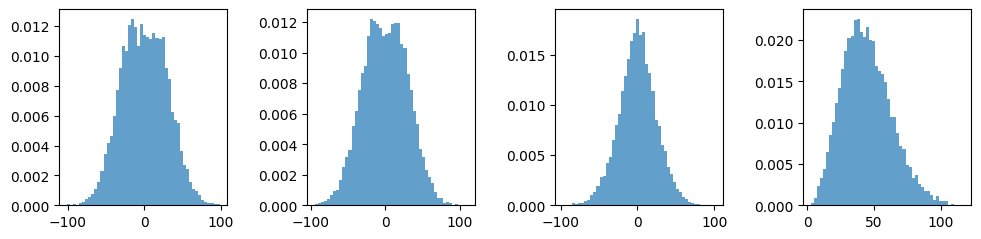

    pt: [[12.1], [40.4], [97.8], [53.1], [54.1], ... [51.6], [47.1], [29.3], [59.2], [30.8]]
    eta: [[-0.239], [0.492], [-0.061], [-0.3], ... [0.116], [0.348], [0.18], [-1.18]]
    phi: [[-2.75], [-2.23], [-2.6], [-0.343], ... [0.96], [-0.306], [-2.27], [-2.9]]
    M: [[0.773], [1.03], [0.913], [1.09], [0.79, ... [1.07], [1.09], [0.924], [0.944]]
 ---> Plotting ---> 


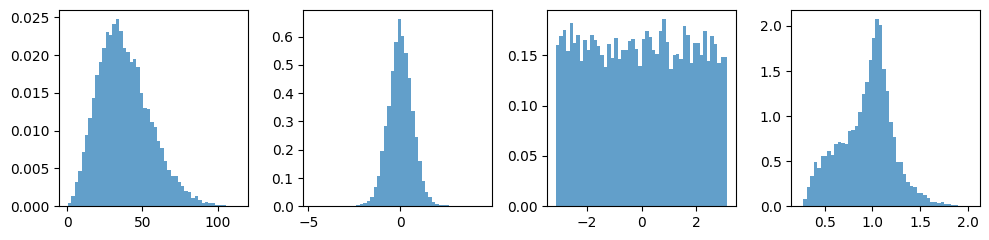

Nu ===>
    px: [[-44.3], [-9.67], [31.1], [6.07], [3.58, ... [7.42], [27.8], [-1.8], [-4.52]]
    py: [[-19.6], [-12.4], [16.9], [-2.31], [-0.61, ... [13.1], [-8.77], [-1.46], [-0.14]]
    pz: [[-12.2], [6.8], [3.06], [-2.63], [0.45], ... [-2.87], [1.25], [11.8], [0.175], [-6]]
    E: [[50], [17.1], [35.5], [7], [3.66], ... [8.45], [15.1], [31.4], [2.33], [7.51]]
 ---> Plotting ---> 


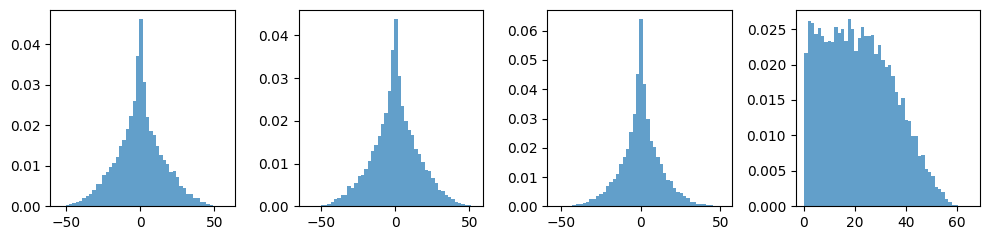

    pt: [[48.5], [15.7], [35.4], [6.49], [3.63], ... [7.95], [15.1], [29.1], [2.32], [4.53]]
    eta: [[-0.249], [0.42], [0.0864], [-0.395], ... [0.0831], [0.396], [0.0751], [-1.09]]
    phi: [[-2.72], [-2.23], [0.497], [-0.363], ... [1.06], [-0.306], [-2.46], [-3.11]]
    M: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
 ---> Plotting ---> 


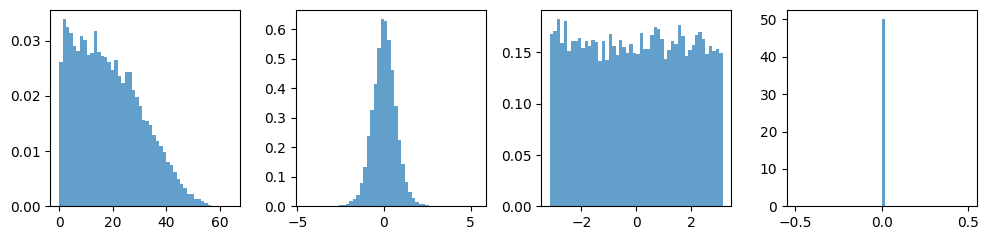

s1: ss2_pi + os_pi : [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
s2: ss1_pi + os_pi : [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
s3: ss1_pi + ss2_pi: [[0.0779], [0.0779], [0.077], [0.0784], ... [0.0777], [0.0779], [0.0779], [0.0779]]
 ---> Plotting ---> 


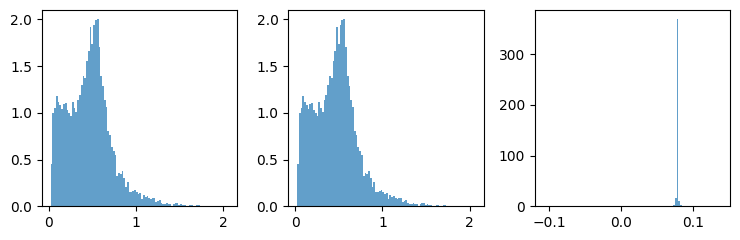

vec1 ===>
    px: [[-554], [146], [2.97e+05], [-4.81e+03, ... [783], [-1.12e+03], [-6.94e+03]]
    py: [[-21], [736], [6.51e+04], [377], ... [-8.14e+03], [-4.09], [-1.75e+03], [-81.1]]
    pz: [[-6.35], [-437], [93.1], [72.9], ... [-34.7], [102], [106], [-2.21e+04]]
    E: [[708], [-2.27e+03], [-4.76e+05], ... [1.2e+03], [4.7e+03], [4.01e+04]]
 ---> Plotting ---> 


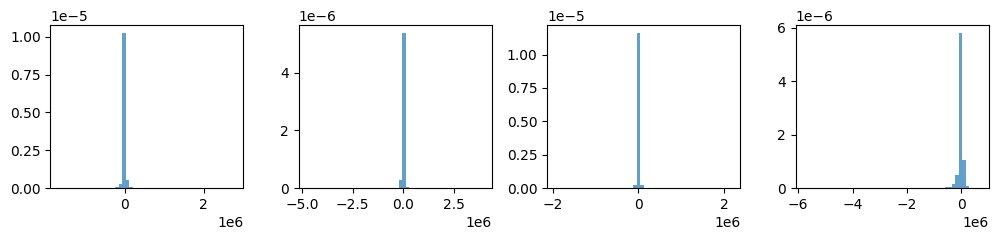

vec2 ===> 
    px: [[554], [-146], [-2.97e+05], [4.81e+03, ... [-783], [1.12e+03], [6.94e+03]]
    py: [[21], [-736], [-6.51e+04], [-377], ... [8.14e+03], [4.09], [1.75e+03], [81.1]]
    pz: [[6.35], [437], [-93.1], [-72.9], ... [34.7], [-102], [-106], [2.21e+04]]
    E: [[-708], [2.27e+03], [4.76e+05], ... [-1.2e+03], [-4.7e+03], [-4.01e+04]]
 ---> Plotting ---> 


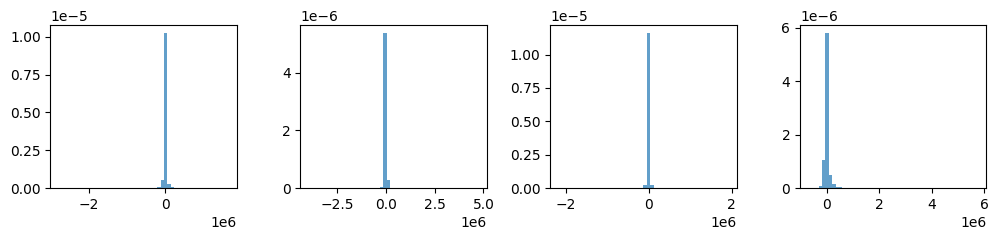

vec3 ===>
    px: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
    py: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
    pz: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
    E: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
 ---> Plotting ---> 


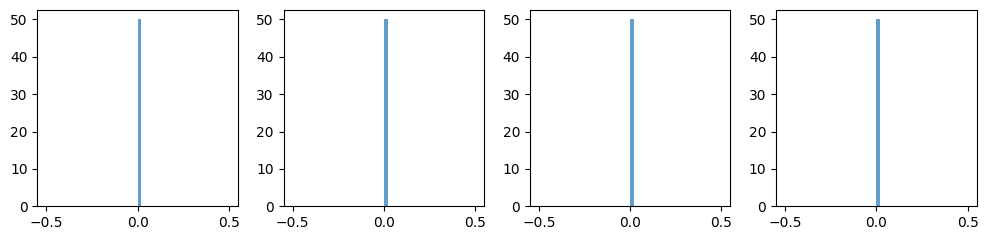

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> F1 ===>
 --- F3PI --- : --- Start ---
  BT1: 1.0	0.0
  BT2: -0.11994078724388779	0.0037692910893753883
  BT3: 0.3296724139496961	-0.16797648490363232
  BT4: -0.0818742325871075	0.8661389092046796
  BT5: -0.1330407333558646	0.6974239480173688
  BT6: 1.5752332462239653	1.388754917179669
  BT7: -0.09650658984451436	-0.7639283200121479
  F3PIFactor: 0.0	0.0
  IDK: 1
  IFORM: 1
  S1: [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
  S2: [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
  S3: [[0.0949], [0.095], [0.0944], [0.0951], ... [0.0948], [0.0949], [0.0949], [0.0949]]
  F134: [[0.0618], [0.14], [0.101], [0.161], ... [0.153], [0.161], [0.105], [0.111]]
  F150: [[-0.00867], [-0.0148], [-0.0115], [-0.0165, ... [-0.0164], [-0.012], [-0.0125]]
  F167: 0.6666666666666666
  === FRO1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ:

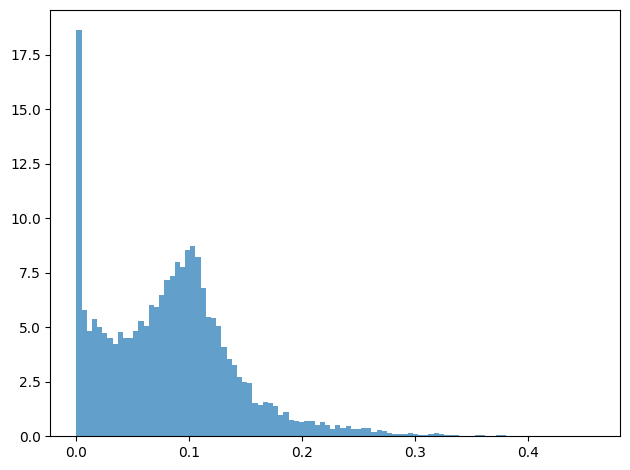

  out: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]
 ---> Plotting ---> 


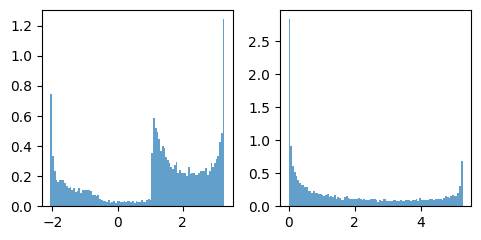

 --- BWIGML --- : --- End ---
  === FRO1: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]

  === FRP1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 ---> Plotting ---> 


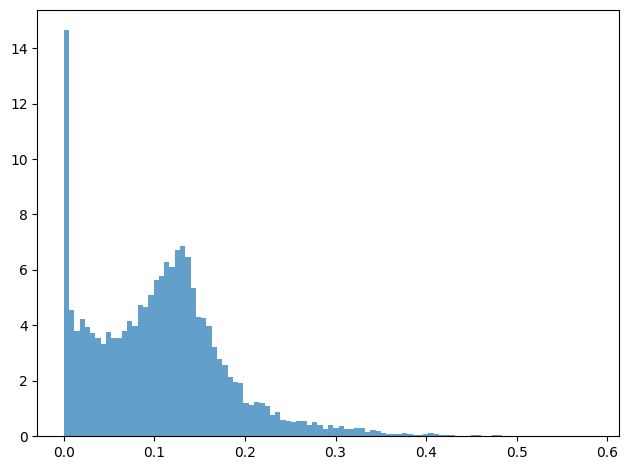

  out: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]
 ---> Plotting ---> 


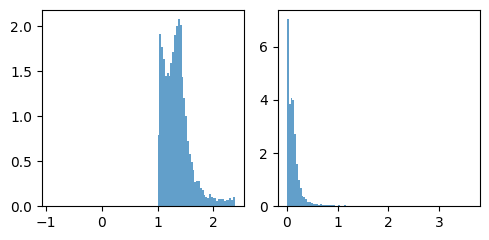

 --- BWIGML --- : --- End ---
  === FRP1: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]

  === FRO2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 0.59954049
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 0.723979355706531
  IPOW: 3
  WGS: [[0.041], [0.0954], [0.0682], [0.11], ... [0.104], [0.11], [0.0706], [0.075]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.041], [0.0954], [0.0682], [0.11], ... [0.104], [0.11], [0.0706], [0.075]]
 ---> Plotting ---> 


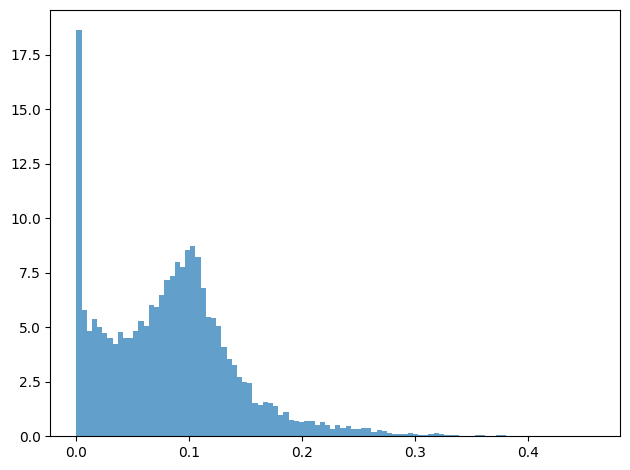

  out: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]
 ---> Plotting ---> 


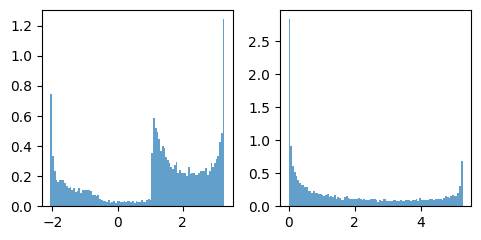

 --- BWIGML --- : --- End ---
  === FRO2: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]

  === FRP2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 ---> Plotting ---> 


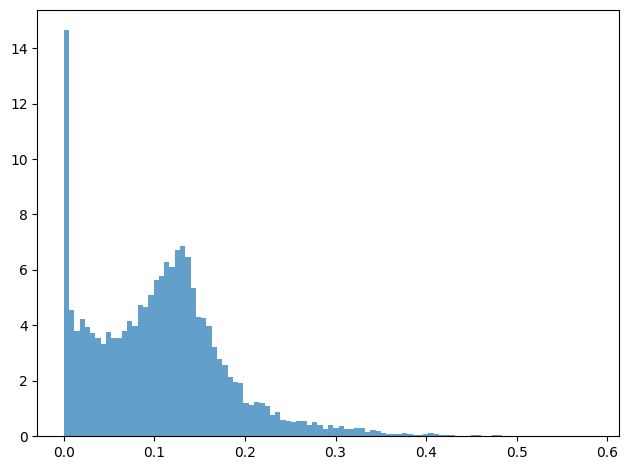

  out: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]
 ---> Plotting ---> 


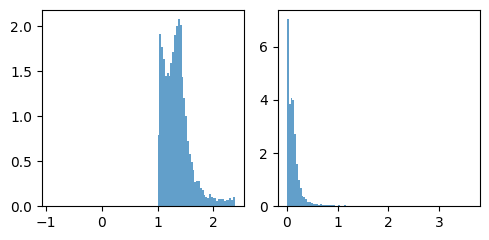

 --- BWIGML --- : --- End ---
  === FRP2: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]

  === FF23 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.6256249999999999
  W: [[0.308], [0.308], [0.307], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.148], [0.149], [0.147], [0.149], ... [0.148], [0.148], [0.148], [0.148]]
  QM: 1.246094005205771
  IPOW: 5
  WGS: [[2.34e-05], [2.37e-05], [2.22e-05], ... [2.33e-05], [2.34e-05], [2.33e-05]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[2.34e-05], [2.37e-05], [2.22e-05], ... [2.33e-05], [2.34e-05], [2.33e-05]]
 ---> Plotting ---> 


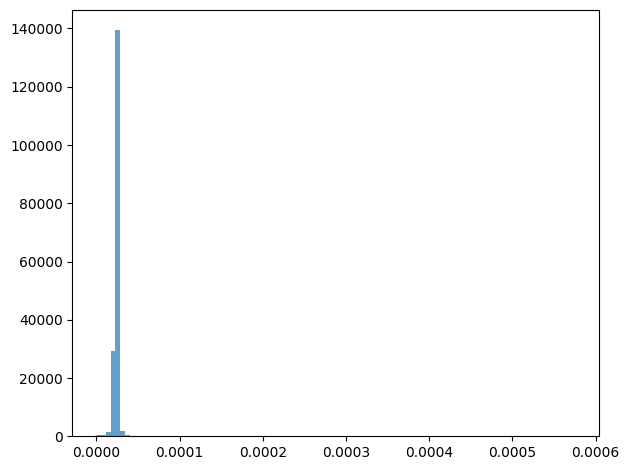

  out: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.62e-05], [1.64e-05], [1.54e-05], ... [1.62e-05], [1.62e-05], [1.62e-05]]
 ---> Plotting ---> 


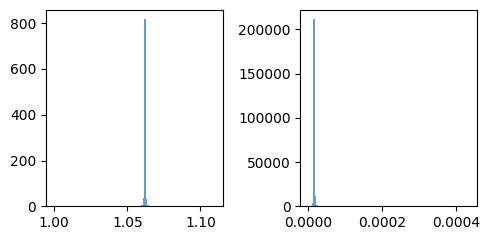

 --- BWIGML --- : --- End ---
  === FF23: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.62e-05], [1.64e-05], [1.54e-05], ... [1.62e-05], [1.62e-05], [1.62e-05]]

  === FSG3 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 0.7395999999999999
  W: [[0.308], [0.308], [0.307], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.148], [0.149], [0.147], [0.149], ... [0.148], [0.148], [0.148], [0.148]]
  QM: 0.8165324670885781
  IPOW: 1
  WGS: [[0.384], [0.385], [0.381], [0.385], ... [0.383], [0.384], [0.384], [0.384]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.384], [0.385], [0.381], [0.385], ... [0.383], [0.384], [0.384], [0.384]]
 ---> Plotting ---> 


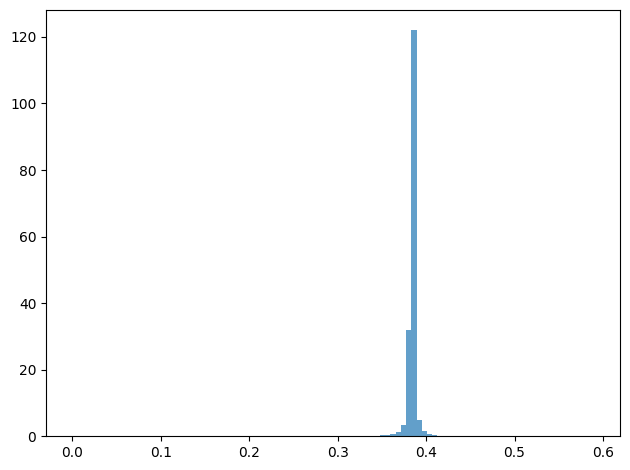

  out: [[0.847], [0.846], [0.85], [0.845], ... [0.848], [0.847], [0.847], [0.847]]	[[0.504], [0.505], [0.502], [0.505], ... [0.504], [0.504], [0.504], [0.504]]
 ---> Plotting ---> 


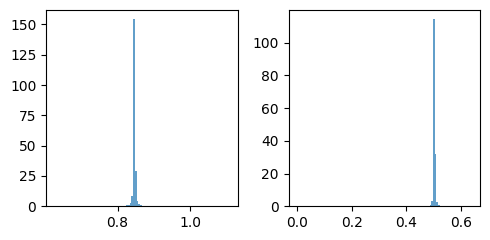

 --- BWIGML --- : --- End ---
  === FSG3: [[0.847], [0.846], [0.85], [0.845], ... [0.848], [0.847], [0.847], [0.847]]	[[0.504], [0.505], [0.502], [0.505], ... [0.504], [0.504], [0.504], [0.504]]

  === FF03 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.406596
  W: [[0.308], [0.308], [0.307], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.148], [0.149], [0.147], [0.149], ... [0.148], [0.148], [0.148], [0.148]]
  QM: 1.1548685075842011
  IPOW: 1
  WGS: [[0.205], [0.206], [0.204], [0.206], ... [0.205], [0.205], [0.205], [0.205]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.205], [0.206], [0.204], [0.206], ... [0.205], [0.205], [0.205], [0.205]]
 ---> Plotting ---> 


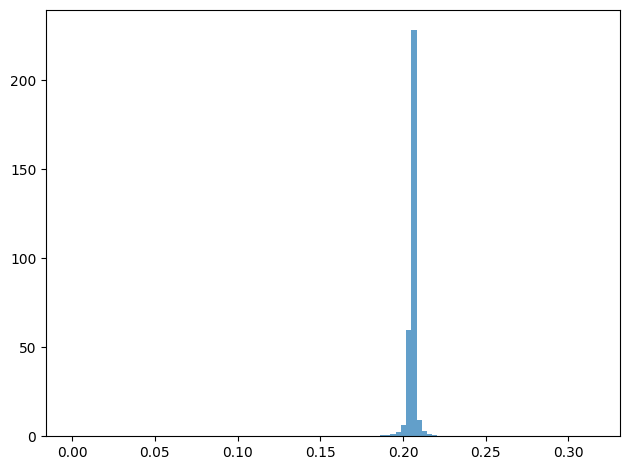

  out: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.162], [0.164], ... [0.163], [0.164], [0.164], [0.164]]
 ---> Plotting ---> 


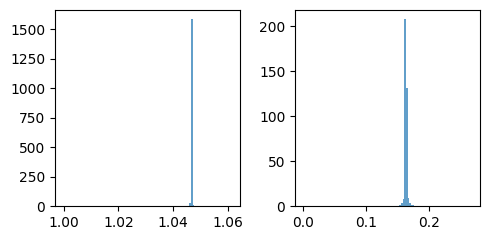

 --- BWIGML --- : --- End ---
  === FF03: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.162], [0.164], ... [0.163], [0.164], [0.164], [0.164]]

  F3PIFactor: [[2.17], [3.59], [3.04], [1.46], [2.25], ... [2.27], [2.63], [1.46], [3.13], [3.31]]	[[1.05], [4.48], [1.75], [6.42], [1.09], ... [1.1], [5.88], [6.42], [1.87], [2.13]]


 --- FA1A1P --- : --- Start ---
 --- WGA1 --- : --- Start ---
  S: [[0.597], [1.07], [0.833], [1.19], [0.624, ... [1.14], [1.19], [0.854], [0.892]]
 --- WGA1C ---: --- Start ---
  G1_IM: [[0.238], [4.11], [1.64], [5.27], [0.3], ... [0.316], [4.82], [5.27], [1.88], [2.32]]
 --- WGA1C ---: --- End ---
 --- WGA1N --- : --- Start ---
  G1_IM: [[0.263], [4.22], [1.73], [5.36], [0.33], ... 0.347], [4.92], [5.36], [1.98], [2.42]]
 --- WGA1N --- : --- End ---
  S > MK1SQ: [[False], [False], [False], [False], ... [False], [False], [False], [False]]
  GKST: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [

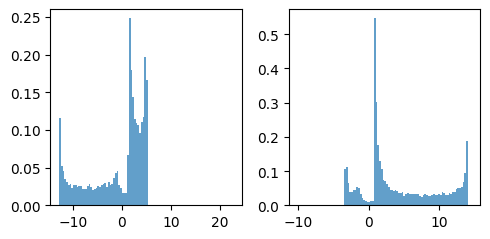

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> F2 ===>
 --- F3PI --- : --- Start ---
  BT1: 1.0	0.0
  BT2: -0.11994078724388779	0.0037692910893753883
  BT3: 0.3296724139496961	-0.16797648490363232
  BT4: -0.0818742325871075	0.8661389092046796
  BT5: -0.1330407333558646	0.6974239480173688
  BT6: 1.5752332462239653	1.388754917179669
  BT7: -0.09650658984451436	-0.7639283200121479
  F3PIFactor: 0.0	0.0
  IDK: 1
  IFORM: 2
  S1: [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
  S2: [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
  S3: [[0.0949], [0.095], [0.0944], [0.0951], ... [0.0948], [0.0949], [0.0949], [0.0949]]
  F134: [[0.0618], [0.14], [0.101], [0.161], ... [0.153], [0.161], [0.105], [0.111]]
  F150: [[-0.00867], [-0.0148], [-0.0115], [-0.0165, ... [-0.0164], [-0.012], [-0.0125]]
  F167: 0.6666666666666666
  === FRO1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ:

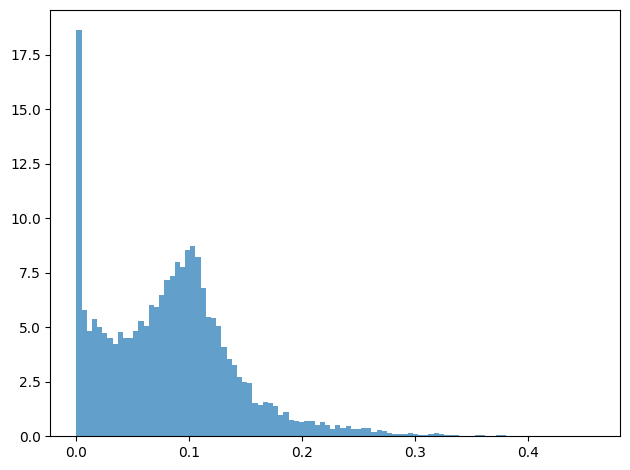

  out: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]
 ---> Plotting ---> 


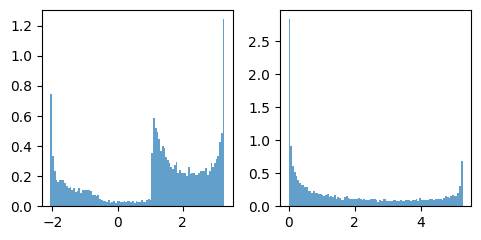

 --- BWIGML --- : --- End ---
  === FRO1: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]

  === FRP1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 ---> Plotting ---> 


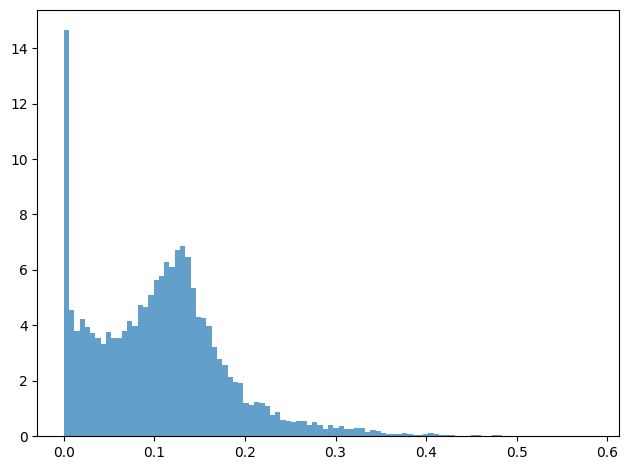

  out: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]
 ---> Plotting ---> 


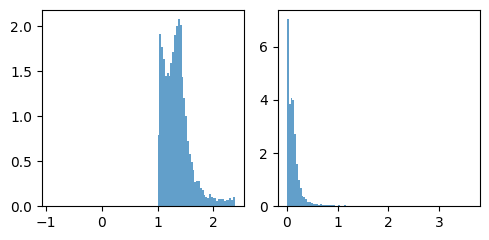

 --- BWIGML --- : --- End ---
  === FRP1: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]

  === FRO2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 0.59954049
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 0.723979355706531
  IPOW: 3
  WGS: [[0.041], [0.0954], [0.0682], [0.11], ... [0.104], [0.11], [0.0706], [0.075]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.041], [0.0954], [0.0682], [0.11], ... [0.104], [0.11], [0.0706], [0.075]]
 ---> Plotting ---> 


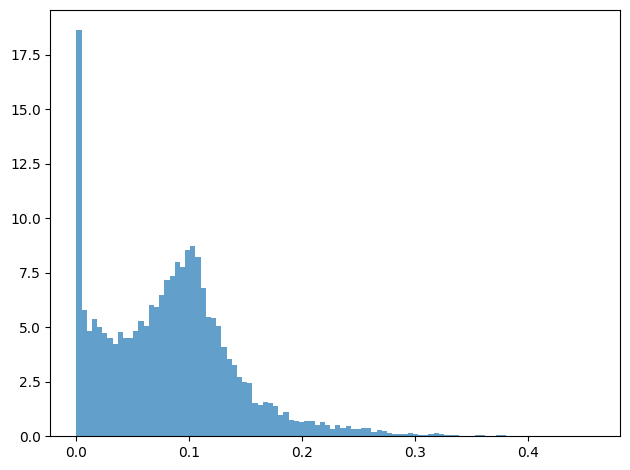

  out: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]
 ---> Plotting ---> 


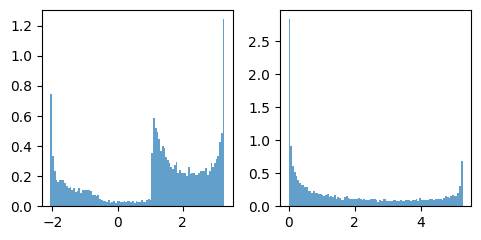

 --- BWIGML --- : --- End ---
  === FRO2: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]

  === FRP2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 ---> Plotting ---> 


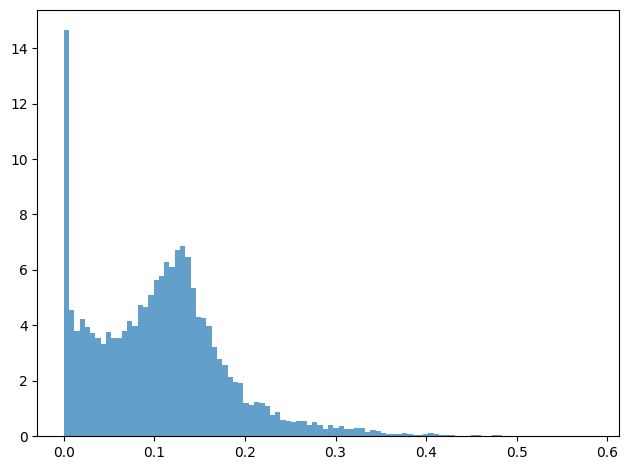

  out: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]
 ---> Plotting ---> 


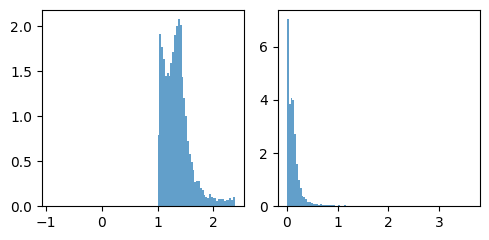

 --- BWIGML --- : --- End ---
  === FRP2: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]

  === FF23 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.6256249999999999
  W: [[0.308], [0.308], [0.307], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.148], [0.149], [0.147], [0.149], ... [0.148], [0.148], [0.148], [0.148]]
  QM: 1.246094005205771
  IPOW: 5
  WGS: [[2.34e-05], [2.37e-05], [2.22e-05], ... [2.33e-05], [2.34e-05], [2.33e-05]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[2.34e-05], [2.37e-05], [2.22e-05], ... [2.33e-05], [2.34e-05], [2.33e-05]]
 ---> Plotting ---> 


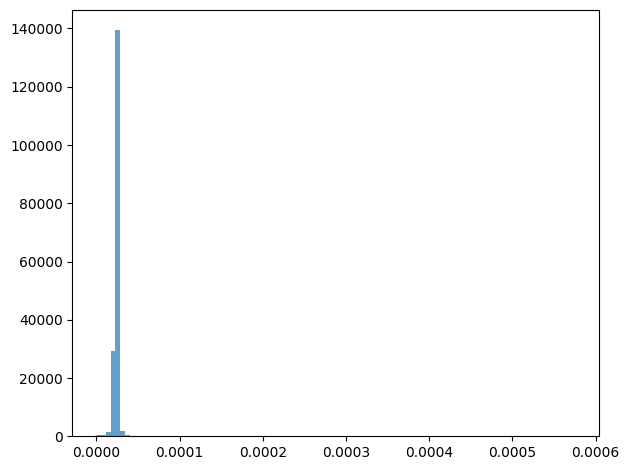

  out: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.62e-05], [1.64e-05], [1.54e-05], ... [1.62e-05], [1.62e-05], [1.62e-05]]
 ---> Plotting ---> 


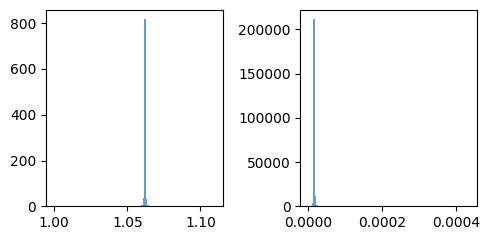

 --- BWIGML --- : --- End ---
  === FF23: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.62e-05], [1.64e-05], [1.54e-05], ... [1.62e-05], [1.62e-05], [1.62e-05]]

  === FSG3 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 0.7395999999999999
  W: [[0.308], [0.308], [0.307], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.148], [0.149], [0.147], [0.149], ... [0.148], [0.148], [0.148], [0.148]]
  QM: 0.8165324670885781
  IPOW: 1
  WGS: [[0.384], [0.385], [0.381], [0.385], ... [0.383], [0.384], [0.384], [0.384]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.384], [0.385], [0.381], [0.385], ... [0.383], [0.384], [0.384], [0.384]]
 ---> Plotting ---> 


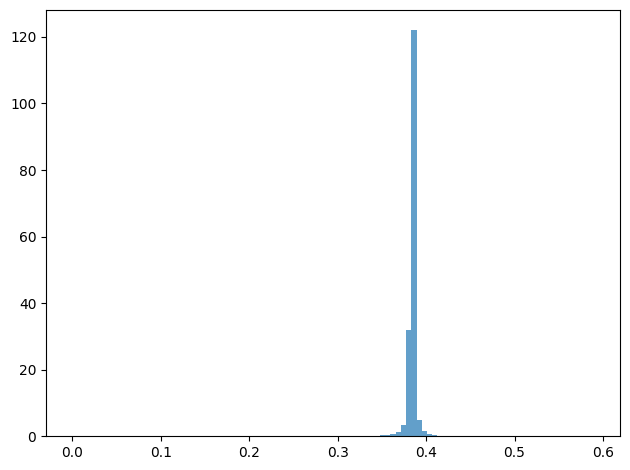

  out: [[0.847], [0.846], [0.85], [0.845], ... [0.848], [0.847], [0.847], [0.847]]	[[0.504], [0.505], [0.502], [0.505], ... [0.504], [0.504], [0.504], [0.504]]
 ---> Plotting ---> 


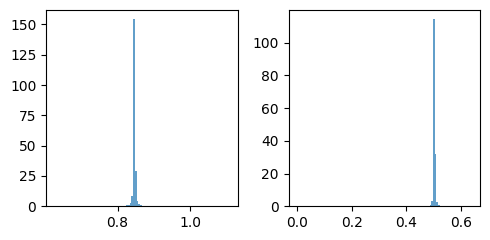

 --- BWIGML --- : --- End ---
  === FSG3: [[0.847], [0.846], [0.85], [0.845], ... [0.848], [0.847], [0.847], [0.847]]	[[0.504], [0.505], [0.502], [0.505], ... [0.504], [0.504], [0.504], [0.504]]

  === FF03 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.406596
  W: [[0.308], [0.308], [0.307], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.148], [0.149], [0.147], [0.149], ... [0.148], [0.148], [0.148], [0.148]]
  QM: 1.1548685075842011
  IPOW: 1
  WGS: [[0.205], [0.206], [0.204], [0.206], ... [0.205], [0.205], [0.205], [0.205]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.205], [0.206], [0.204], [0.206], ... [0.205], [0.205], [0.205], [0.205]]
 ---> Plotting ---> 


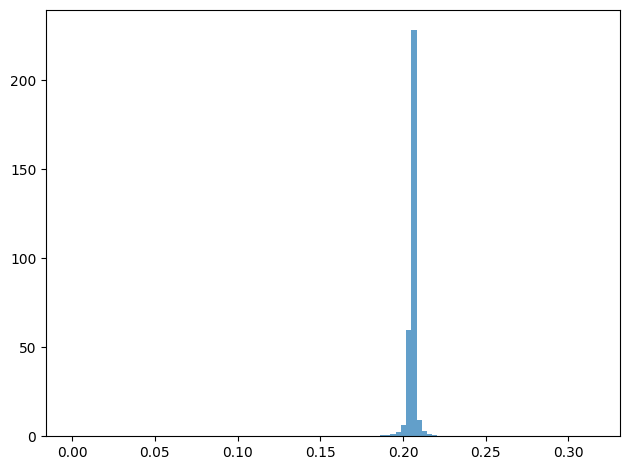

  out: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.162], [0.164], ... [0.163], [0.164], [0.164], [0.164]]
 ---> Plotting ---> 


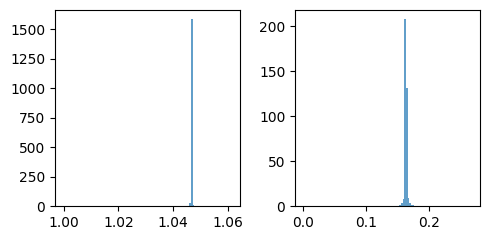

 --- BWIGML --- : --- End ---
  === FF03: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.162], [0.164], ... [0.163], [0.164], [0.164], [0.164]]

  F3PIFactor: [[2.17], [3.59], [3.04], [1.46], [2.25], ... [2.27], [2.63], [1.46], [3.13], [3.31]]	[[1.05], [4.48], [1.75], [6.42], [1.09], ... [1.1], [5.88], [6.42], [1.87], [2.13]]


 --- FA1A1P --- : --- Start ---
 --- WGA1 --- : --- Start ---
  S: [[0.597], [1.07], [0.833], [1.19], [0.624, ... [1.14], [1.19], [0.854], [0.892]]
 --- WGA1C ---: --- Start ---
  G1_IM: [[0.238], [4.11], [1.64], [5.27], [0.3], ... [0.316], [4.82], [5.27], [1.88], [2.32]]
 --- WGA1C ---: --- End ---
 --- WGA1N --- : --- Start ---
  G1_IM: [[0.263], [4.22], [1.73], [5.36], [0.33], ... 0.347], [4.92], [5.36], [1.98], [2.42]]
 --- WGA1N --- : --- End ---
  S > MK1SQ: [[False], [False], [False], [False], ... [False], [False], [False], [False]]
  GKST: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [

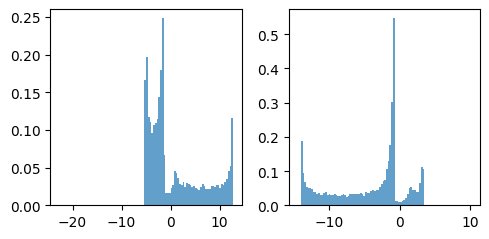

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> F3 ===>
 --- F3PI --- : --- Start ---
  BT1: 1.0	0.0
  BT2: -0.11994078724388779	0.0037692910893753883
  BT3: 0.3296724139496961	-0.16797648490363232
  BT4: -0.0818742325871075	0.8661389092046796
  BT5: -0.1330407333558646	0.6974239480173688
  BT6: 1.5752332462239653	1.388754917179669
  BT7: -0.09650658984451436	-0.7639283200121479
  F3PIFactor: 0.0	0.0
  IDK: 1
  IFORM: 3
  S1: [[0.279], [0.514], [0.397], [0.578], ... [0.552], [0.578], [0.407], [0.426]]
  S2: [[0.296], [0.531], [0.415], [0.594], ... [0.569], [0.595], [0.424], [0.443]]
  S3: [[0.0779], [0.0779], [0.077], [0.0784], ... [0.0777], [0.0779], [0.0779], [0.0779]]
  F34A: [[0.0731], [0.151], [0.113], [0.172], ... [0.164], [0.173], [0.116], [0.122]]
  F34B: [[-0.0675], [-0.146], [-0.107], [-0.167], ... [-0.159], [-0.167], [-0.11], [-0.117]]
  F35: [[0.00847], [0.00854], [0.00871], [0.00833, ... [0.00847], [0.0085], [0.00848]]
  === FRO1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI 

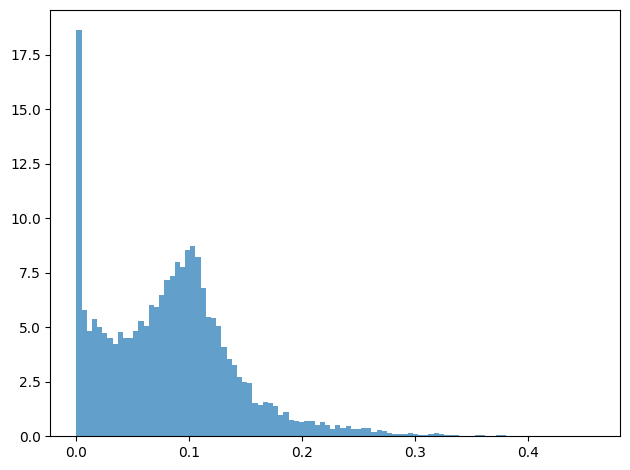

  out: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]
 ---> Plotting ---> 


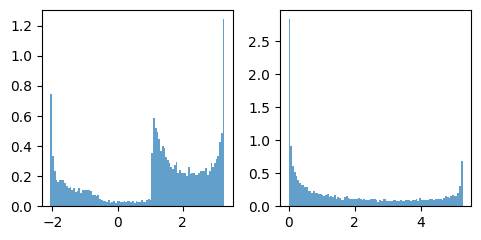

 --- BWIGML --- : --- End ---
  === FRO1: [[1.84], [3.12], [2.66], [1.03], [1.91], ... [1.93], [2.16], [1.03], [2.75], [2.92]]	[[0.235], [3.48], [0.897], [5.23], [0.274, ... [4.77], [5.23], [1.01], [1.26]]

  === FRP1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.528], [0.717], [0.63], [0.76], [0.541, ... [0.743], [0.76], [0.638], [0.653]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.451], [0.662], [0.567], [0.709], ... [0.691], [0.709], [0.576], [0.593]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0521], [0.121], [0.0868], [0.14], ... [0.133], [0.14], [0.0898], [0.0954]]
 ---> Plotting ---> 


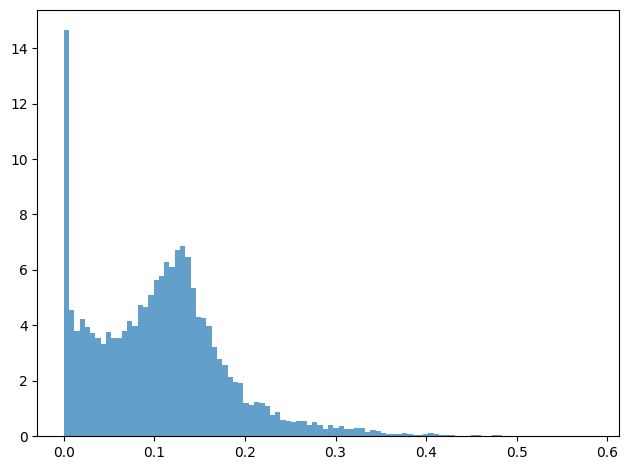

  out: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]
 ---> Plotting ---> 


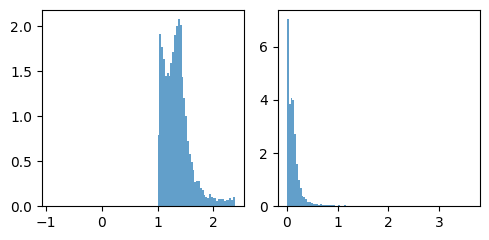

 --- BWIGML --- : --- End ---
  === FRP1: [[1.17], [1.37], [1.26], [1.43], [1.18], ... [1.19], [1.4], [1.43], [1.27], [1.29]]	[[0.0383], [0.122], [0.0741], [0.154], ... [0.141], [0.154], [0.0777], [0.0848]]

  === FRO2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 0.59954049
  W: [[0.544], [0.729], [0.644], [0.771], ... [0.755], [0.771], [0.651], [0.666]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.47], [0.675], [0.582], [0.72], [0.484, ... [0.703], [0.721], [0.591], [0.607]]
  QM: 0.723979355706531
  IPOW: 3
  WGS: [[0.0449], [0.0994], [0.0723], [0.114], ... [0.108], [0.114], [0.0745], [0.079]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0449], [0.0994], [0.0723], [0.114], ... [0.108], [0.114], [0.0745], [0.079]]
 ---> Plotting ---> 


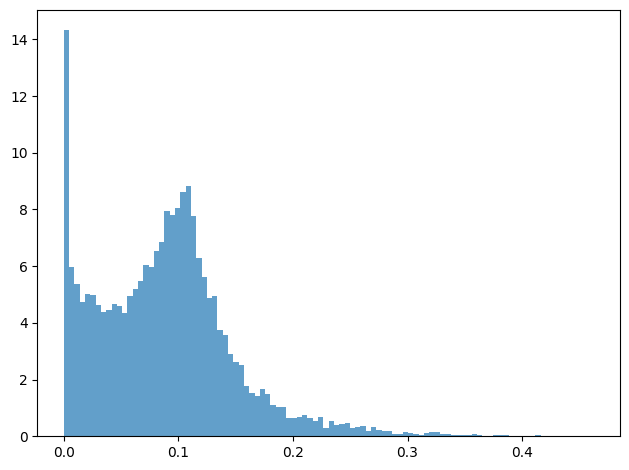

  out: [[1.93], [2.82], [2.81], [0.235], [2.01], ... [2.03], [1.43], [0.223], [2.9], [3.06]]	[[0.286], [4.09], [1.1], [5.24], [0.332], ... 0.345], [5.13], [5.24], [1.23], [1.55]]
 ---> Plotting ---> 


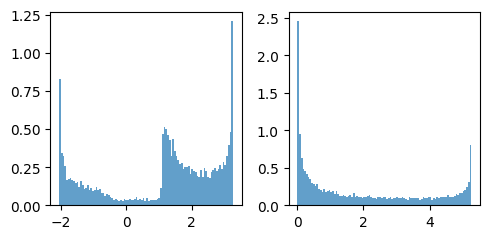

 --- BWIGML --- : --- End ---
  === FRO2: [[1.93], [2.82], [2.81], [0.235], [2.01], ... [2.03], [1.43], [0.223], [2.9], [3.06]]	[[0.286], [4.09], [1.1], [5.24], [0.332], ... 0.345], [5.13], [5.24], [1.23], [1.55]]

  === FRP2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.544], [0.729], [0.644], [0.771], ... [0.755], [0.771], [0.651], [0.666]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.47], [0.675], [0.582], [0.72], [0.484, ... [0.703], [0.721], [0.591], [0.607]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0571], [0.126], [0.0919], [0.145], ... [0.138], [0.145], [0.0948], [0.1]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0571], [0.126], [0.0919], [0.145], ... [0.138], [0.145], [0.0948], [0.1]]
 ---> Plotting ---> 


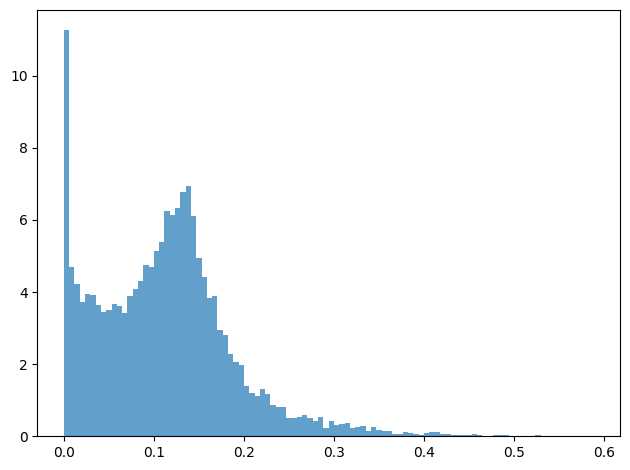

  out: [[1.19], [1.38], [1.28], [1.44], [1.2], ... [1.2], [1.42], [1.45], [1.29], [1.3]]	[[0.0428], [0.13], [0.0804], [0.164], ... [0.15], [0.164], [0.084], [0.0913]]
 ---> Plotting ---> 


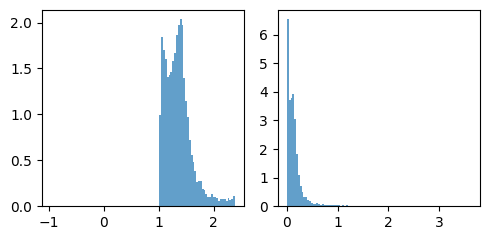

 --- BWIGML --- : --- End ---
  === FRP2: [[1.19], [1.38], [1.28], [1.44], [1.2], ... [1.2], [1.42], [1.45], [1.29], [1.3]]	[[0.0428], [0.13], [0.0804], [0.164], ... [0.15], [0.164], [0.084], [0.0913]]

  === FF23 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.6256249999999999
  W: [[0.279], [0.279], [0.277], [0.28], [0.28, ... [0.279], [0.279], [0.279], [0.279]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.0712], [0.071], [0.0641], [0.0746], ... [0.0693], [0.0711], [0.0708], [0.0709]]
  QM: 1.246094005205771
  IPOW: 5
  WGS: [[6.57e-07], [6.47e-07], [3.91e-07], ... [6.51e-07], [6.36e-07], [6.44e-07]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[6.57e-07], [6.47e-07], [3.91e-07], ... [6.51e-07], [6.36e-07], [6.44e-07]]
 ---> Plotting ---> 


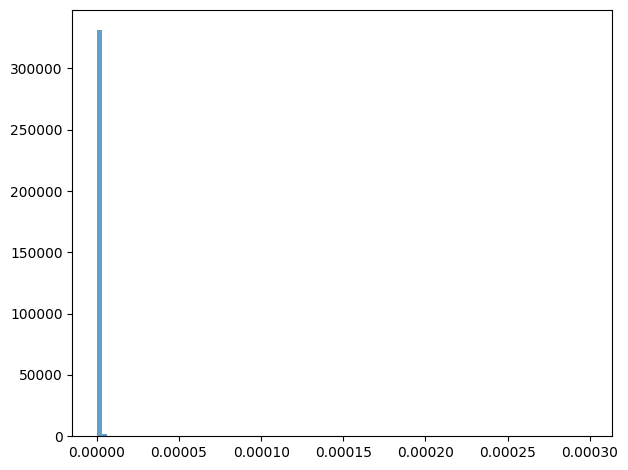

  out: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[4.46e-07], [4.39e-07], [2.65e-07], ... [4.41e-07], [4.32e-07], [4.37e-07]]
 ---> Plotting ---> 


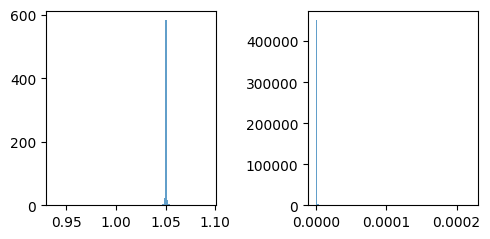

 --- BWIGML --- : --- End ---
  === FF23: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[4.46e-07], [4.39e-07], [2.65e-07], ... [4.41e-07], [4.32e-07], [4.37e-07]]

  F3PIFactor: [[-0.000554], [0.00777], [-0.00453], ... [0.0504], [-0.00489], [-0.00575]]	[[0.00985], [-0.0221], [0.00613], [-0.00359, ... [-0.00357], [0.00505], [0.00257]]


 --- FA1A1P --- : --- Start ---
 --- WGA1 --- : --- Start ---
  S: [[0.597], [1.07], [0.833], [1.19], [0.624, ... [1.14], [1.19], [0.854], [0.892]]
 --- WGA1C ---: --- Start ---
  G1_IM: [[0.238], [4.11], [1.64], [5.27], [0.3], ... [0.316], [4.82], [5.27], [1.88], [2.32]]
 --- WGA1C ---: --- End ---
 --- WGA1N --- : --- Start ---
  G1_IM: [[0.263], [4.22], [1.73], [5.36], [0.33], ... 0.347], [4.92], [5.36], [1.98], [2.42]]
 --- WGA1N --- : --- End ---
  S > MK1SQ: [[False], [False], [False], [False], ... [False], [False], [False], [False]]
  GKST: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0

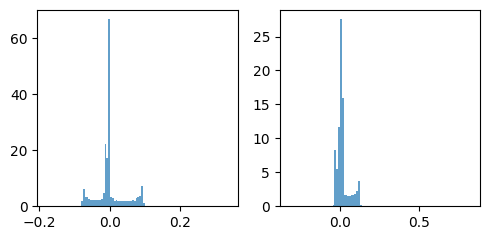

  HC_E: 
  Re: [[4.53e+03], [-3.54e+03], [-4.75e+06], ... [-2.18e+04], [4.75e+04], [4.07e+05]]
  Im: [[2.31e+03], [-5.82e+04], [-4.18e+06], ... [2.94e+04], [4.61e+04], [4.82e+05]]
 ---> Plotting ---> 


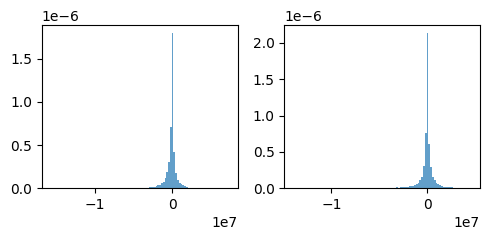

  HC_Px: 
  Re: [[-3.54e+03], [228], [2.97e+06], ... [-1.42e+04], [-1.13e+04], [-7.05e+04]]
  Im: [[-1.81e+03], [3.75e+03], [2.61e+06], ... [1.91e+04], [-1.09e+04], [-8.35e+04]]
 ---> Plotting ---> 


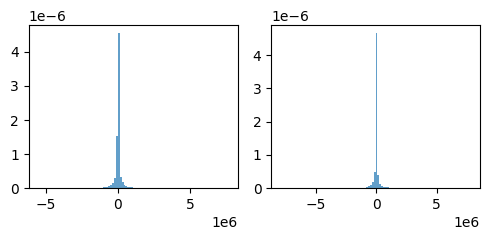

  HC_Py: 
  Re: [[-135], [1.15e+03], [6.5e+05], [-6.86e+03, ... [74.3], [-1.77e+04], [-824]]
  Im: [[-68.7], [1.89e+04], [5.71e+05], [9.21e+03, ... [-100], [-1.72e+04], [-975]]
 ---> Plotting ---> 


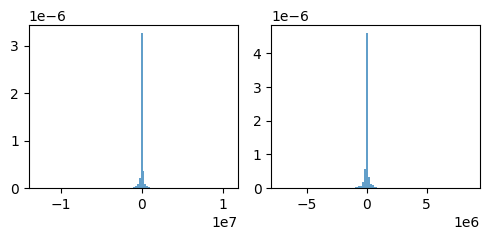

  HC_Pz: 
  Re: [[-40.6], [-682], [930], [-1.32e+03], ... 345], [-1.85e+03], [1.07e+03], [-2.25e+05]]
  Im: [[-20.7], [-1.12e+04], [817], [1.78e+03, ... [2.49e+03], [1.04e+03], [-2.66e+05]]
 ---> Plotting ---> 


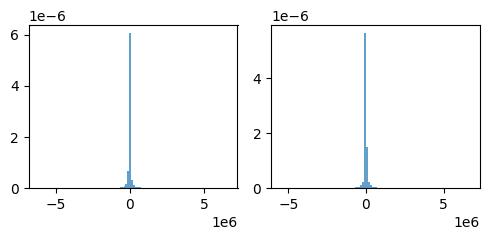

  C-HC_E: 
  Re: [[4.53e+03], [-3.54e+03], [-4.75e+06], ... [-2.18e+04], [4.75e+04], [4.07e+05]]
  Im: [[-2.31e+03], [5.82e+04], [4.18e+06], ... [-2.94e+04], [-4.61e+04], [-4.82e+05]]
 ---> Plotting ---> 


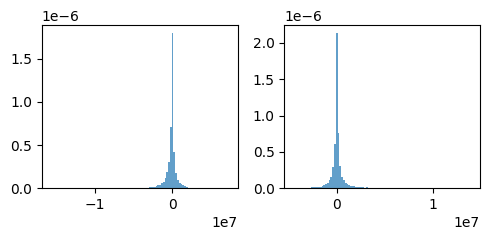

  C-HC_Px: 
  Re: [[-3.54e+03], [228], [2.97e+06], ... [-1.42e+04], [-1.13e+04], [-7.05e+04]]
  Im: [[1.81e+03], [-3.75e+03], [-2.61e+06], ... [-1.91e+04], [1.09e+04], [8.35e+04]]
 ---> Plotting ---> 


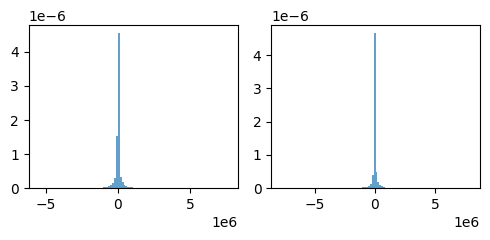

  C-HC_Py: 
  Re: [[-135], [1.15e+03], [6.5e+05], [-6.86e+03, ... [74.3], [-1.77e+04], [-824]]
  Im: [[68.7], [-1.89e+04], [-5.71e+05], [-9.21e+03, ... [100], [1.72e+04], [975]]
 ---> Plotting ---> 


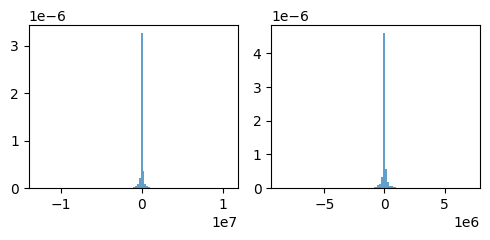

  C-HC_Pz: 
  Re: [[-40.6], [-682], [930], [-1.32e+03], ... 345], [-1.85e+03], [1.07e+03], [-2.25e+05]]
  Im: [[20.7], [1.12e+04], [-817], [-1.78e+03, ... [-2.49e+03], [-1.04e+03], [2.66e+05]]
 ---> Plotting ---> 


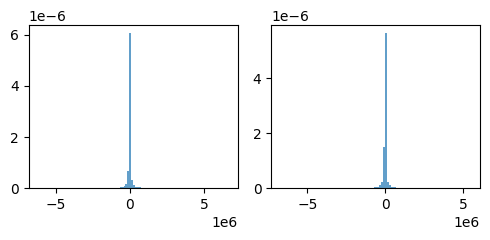

 --- CLVEC --- : --- Start ---
  HN: [[6.61e+04], [-3.95e+04], [-2.72e+08], ... [-2.68e+05], [6.42e+04], [1.39e+06]]	[[3.38e+04], [-6.5e+05], [-2.39e+08], ... [3.61e+05], [6.23e+04], [1.65e+06]]
 ---> Plotting ---> 


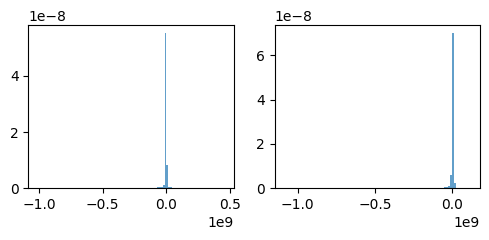

  HCN: [[6.61e+04], [-3.95e+04], [-2.72e+08], ... [-2.68e+05], [6.42e+04], [1.39e+06]]	[[-3.38e+04], [6.5e+05], [2.39e+08], ... [-3.61e+05], [-6.23e+04], [-1.65e+06]]
 ---> Plotting ---> 


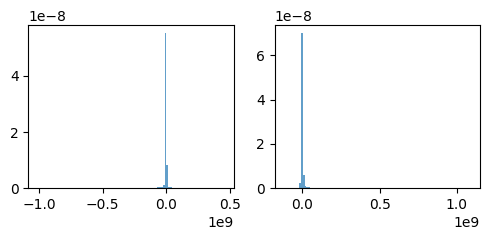

  HH: [[9.99e+06], [2.9e+09], [2.36e+13], ... [7.59e+08], [3.52e+09], [2.65e+11]]
 ---> Plotting ---> 


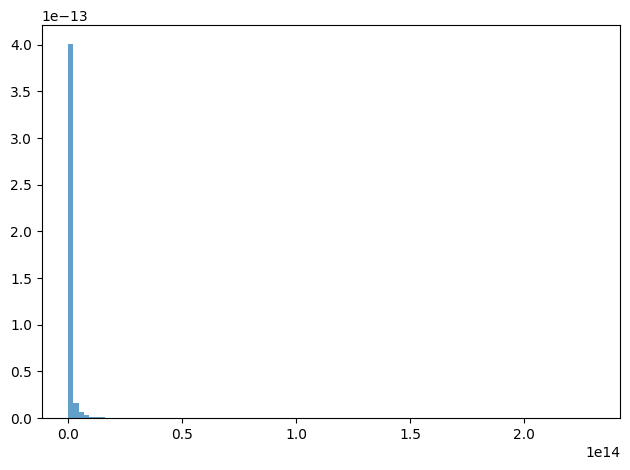

  PIVEC0: [[5.11e+08], [5.26e+10], [7.5e+15], ... [1.8e+10], [7.28e+09], [1.47e+12]]
  PIVEC1: [[-2.96e+08], [4.64e+10], [-7.21e+15], ... [7.41e+08], [7.09e+09], [1.46e+12]]
  PIVEC2: [[3.47e+08], [2.27e+10], [-2.05e+15], ... [1.31e+10], [1.48e+09], [6.35e+10]]
  PIVEC3: [[2.3e+08], [-1.02e+10], [-1.47e+14], ... [-1.24e+10], [-6.95e+08], [1.75e+11]]
  out: [[{x: -2.96e+08, y: 3.47e+08, z: 2.3e+08, ... z: 1.75e+11, t: 1.47e+12}]]
 --- CLVEC --- : --- End ---
 --- CLAXI --- : --- Start ---
  d12: [[5.82e-11], [0], [0], [-2.38e-07], [0], [0, ... [0], [1.91e-06], [0], [0], [0]] 
  d13: [[2.91e-11], [0], [0], [0], [7.63e-06], ... [-2.98e-08], [0], [0], [0], [0]] 
  d14:[[-3.73e-09], [0], [0], [3.81e-06], ... [3.81e-06], [0], [0], [7.63e-06]] 
  d23: [[0], [0], [0], [0], [-5.96e-08], ... [0], [-5.96e-08], [0], [0], [5.96e-08]] 
  d24: [[-1.16e-10], [0], [0], [-4.77e-07], [0], ... -9.54e-07], [0], [-9.31e-10], [0], [0]] 
  d34: [[-2.91e-11], [0], [0], [-5.96e-08, ... [1.49e-08], [1.49e-08], [

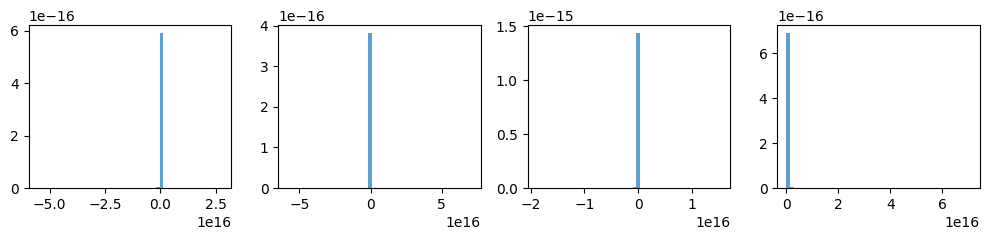

  CLA ===>
    px: [[-1.7e-09], [0], [0], [-2.23e-06, ... [-2.39e-07], [-4.36e-08], [-7.67e-06]]
    py: [[8.53e-08], [0], [0], [-1.93e-05, ... [-8.27e-07], [5.38e-08], [0.000185]]
    pz: [[-1.3e-07], [0], [0], [8.46e-06], ... [-4.24e-05], [-5.17e-08], [0], [2.14e-06]]
    E: [[-2.77e-10], [-0], [-0], [1.25e-06], ... [3.9e-06], [0], [-0], [-5.39e-07]]
 ---> Plotting ---> 


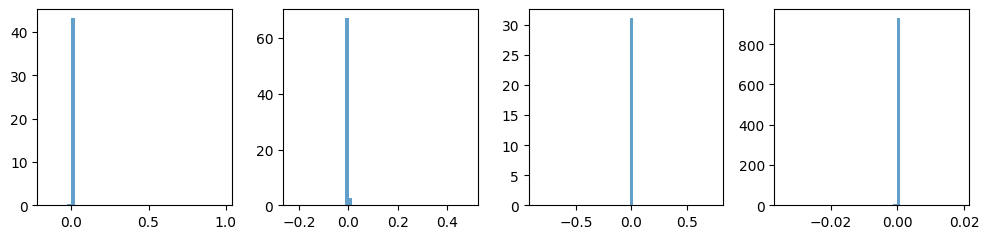

  P.CLV: [[4.52e+09], [-2.88e+12], [4.48e+17], ... [-4.65e+11], [-3.6e+11], [-5.97e+13]]
  P.CLA: [[-1.13e-08], [0], [-0], [0.000106, ... [8.94e-08], [-7.64e-07], [-0.00125]]
  omega: [[4.52e+09], [-2.88e+12], [4.48e+17], ... [-4.65e+11], [-3.6e+11], [-5.97e+13]]
 ---> Plotting ---> 


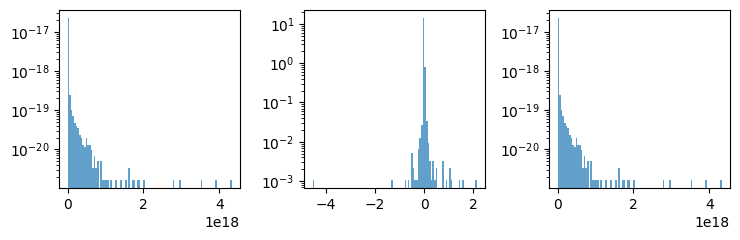

  P.mass: [[1.78], [1.78], [1.78], [1.78], [1.78], ... [1.78], [1.78], [1.78], [1.78], [1.78]]
  P.mass**2: [[3.16], [3.16], [3.16], [3.16], [3.16], ... [3.16], [3.16], [3.16], [3.16], [3.16]]
  CLA - CLV : [[{x: 2.96e+08, y: -3.47e+08, z: -2.3e+08, ... z: -1.75e+11, t: -1.47e+12}]]
  P*(P.dot(CLA) - P.dot(CLV)): [[{x: 2.51e+11, y: 1.1e+11, z: 6.83e+10, ... z: -3.07e+15, t: 3.73e+15}]]	[[{x: 2.51e+11, y: 1.1e+11, z: 6.83e+10, ... z: -3.07e+15, t: 3.73e+15}]]
  1/omega/P.mass: [[1.25e-10], [-1.95e-13], [1.25e-18], ... [-1.21e-12], [-1.56e-12], [-9.43e-15]]
  ~~~ PVC out ~~~ : [[{x: -98.2, y: -43.5, z: -27.1, t: 110}], ... y: -13.5, z: -91.6, t: 111}]]
 --- PVC --- : --- End --- 
  hvec : [[{x: 98.2, y: 43.5, z: 27.1}], [{x: 61.1, ... [{x: 61, y: 13.5, z: 91.6}]]
    x: [[98.2], [61.1], [93.3], [-100], [-101], ... [77.2], [-61.1], [-98.9], [71], [61]]
    y: [[43.5], [78.7], [59.7], [35], [18.9], ... [72.1], [-91.9], [31.1], [82.9], [13.5]]
    z: [[27.1], [-48.8], [5.16], [32.1], [-42.7

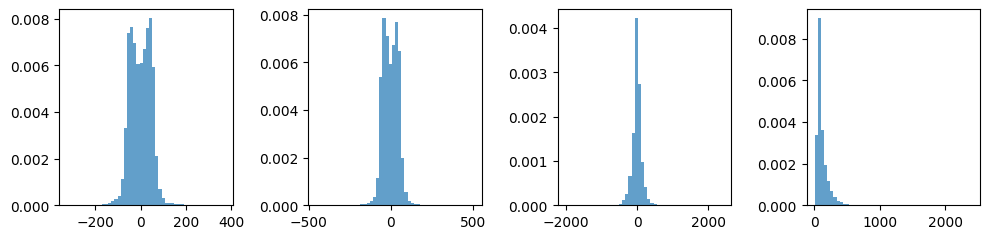

    pt: [[76.8], [49.8], [74.8], [69], [85.5], ... [64.8], [65.8], [80.5], [67], [46.8]]
    eta: [[0.25], [0.523], [0.768], [-0.652], ... [0.0559], [-0.124], [0.348], [1.39]]
    phi: [[0.566], [1.16], [0.6], [2.86], [-2.88, ... 0.613], [-2.12], [2.6], [0.785], [1.54]]
    M: [[1.78], [1.78], [1.78], [1.78], [1.78], ... [1.78], [1.78], [1.78], [1.78], [1.78]]
 ---> Plotting ---> 


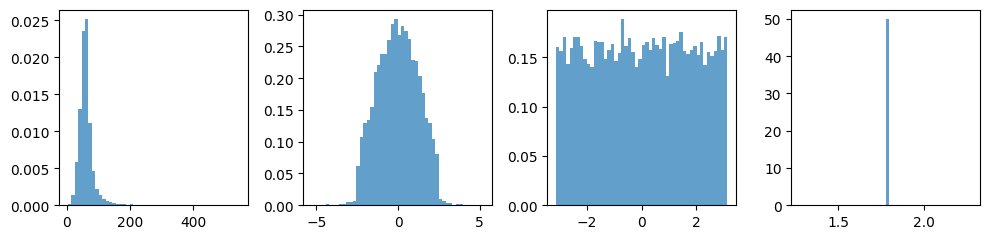

  ===> os pion in lab frame ===>
    px: [[35.4], [1.54], [15.3], [-13.9], [-37.1, ... 9.13], [-11], [-41.7], [26.2], [0.565]]
    py: [[22.5], [4], [10.5], [4.51], [-9.82], ... [6.14], [-18.7], [25.9], [25.6], [10.2]]
    pz: [[11], [2.1], [15.9], [-10.2], [-31.6], ... [58.6], [1.26], [-6.05], [12.7], [19.1]]
    E: [[43.4], [4.77], [24.5], [17.8], [49.7], ... [59.6], [21.7], [49.5], [38.8], [21.7]]
 ---> Plotting ---> 


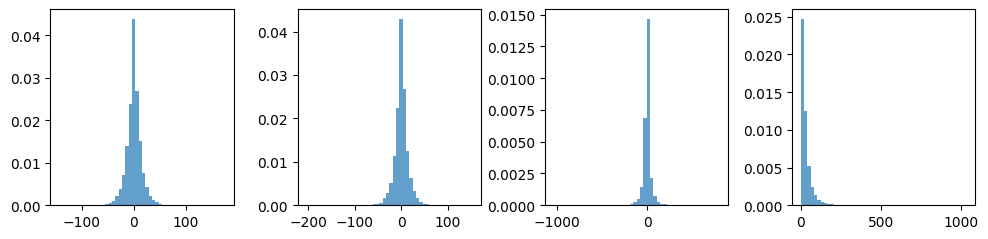

    pt: [[42], [4.28], [18.6], [14.6], [38.4], ... [11], [21.7], [49.1], [36.6], [10.2]]
    eta: [[0.26], [0.474], [0.777], [-0.65], ... [0.0579], [-0.123], [0.341], [1.38]]
    phi: [[0.566], [1.2], [0.604], [2.83], [-2.88, ... [-2.1], [2.59], [0.775], [1.52]]
    M: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
 ---> Plotting ---> 


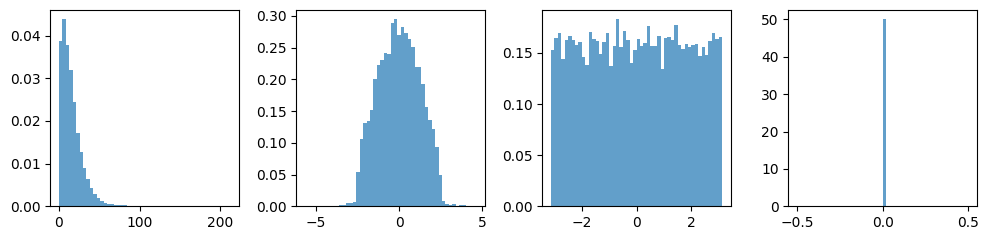

  ===> ss pion1 in lab frame ===>
    px: [[5.46], [4.08], [1.66], [-9.85], [-21.8, ... [-2.71], [-8.41], [3.71], [0.131]]
    py: [[3.44], [8.54], [1], [2.61], [-5.76], ... [8.56], [-4.09], [4.87], [3.81], [4.7]]
    pz: [[1.62], [5.61], [1.71], [-7.35], [-17.8, ... [0.222], [-1.01], [1.64], [8.82]]
    E: [[6.66], [11], [2.59], [12.6], [28.7], ... [81.3], [4.91], [9.77], [5.56], [10]]
 ---> Plotting ---> 


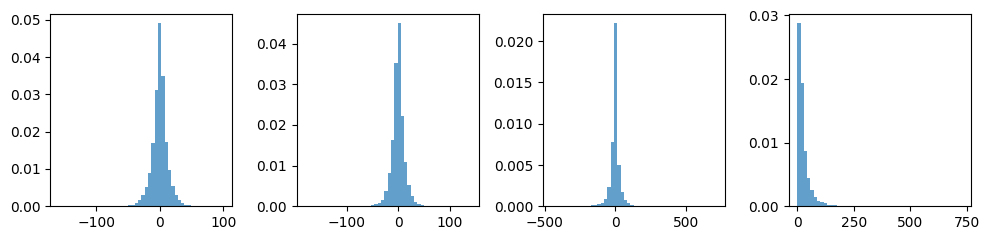

    pt: [[6.45], [9.47], [1.94], [10.2], [22.5], ... [14.9], [4.91], [9.72], [5.31], [4.7]]
    eta: [[0.249], [0.562], [0.793], [-0.67], ... [0.0453], [-0.104], [0.305], [1.39]]
    phi: [[0.562], [1.12], [0.541], [2.88], [-2.88, ... [-2.16], [2.62], [0.799], [1.54]]
    M: [[0.14], [0.14], [0.14], [0.14], [0.14], ... [0.14], [0.14], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


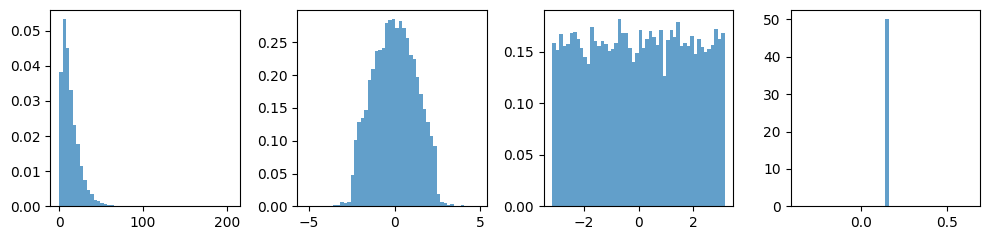

  ===> ss pion2 in lab frame ===>
    px: [[5.96], [7.14], [14.5], [-18.4], [-21.6, ... [-17], [-7.96], [8.58], [-0.0569]]
    py: [[4.18], [16], [9.4], [5.49], [-5.91], ... [17.3], [-27], [4.52], [8.92], [16.6]]
    pz: [[1.91], [9.78], [14.2], [-13.8], [-17.8], ... [162], [2.07], [-1.01], [4.35], [31]]
    E: [[7.53], [20.1], [22.4], [23.7], [28.6], ... [165], [31.9], [9.21], [13.1], [35.2]]
 ---> Plotting ---> 


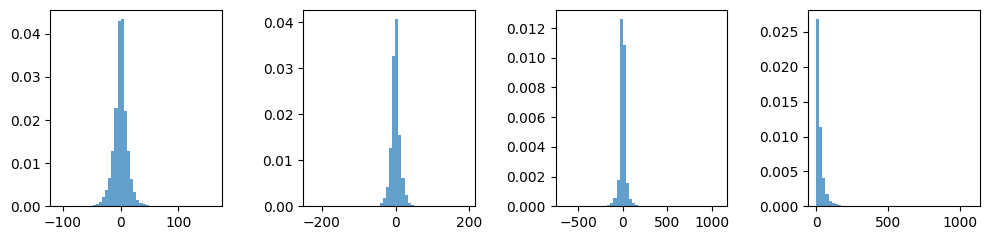

    pt: [[7.28], [17.6], [17.2], [19.2], [22.4], ... [29.9], [31.9], [9.16], [12.4], [16.6]]
    eta: [[0.26], [0.531], [0.752], [-0.67], ... [0.0649], [-0.11], [0.345], [1.38]]
    phi: [[0.611], [1.15], [0.576], [2.85], [-2.88, ... [-2.13], [2.62], [0.805], [1.57]]
    M: [[0.14], [0.14], [0.14], [0.14], [0.14], ... [0.14], [0.14], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


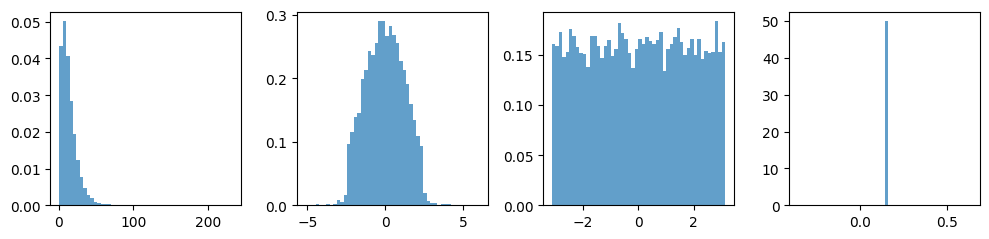

  ===> Boostvec: Higgs Rest Frame ===>
    x: [[0.129], [-0.199], [0.0992], [-0.114], ... [0.00403], [-0.178], [0.103], [-0.35]]
    y: [[0.235], [0.0175], [0.0932], [-0.011], ... [-0.0689], [0.317], [0.00956], [0.419]]
    z: [[0.0587], [0.749], [0.655], [-0.753], ... [0.161], [0.164], [0.485], [0.395]]
 ---> Plotting ---> 


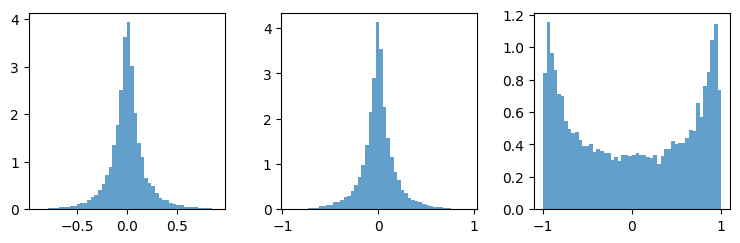

  -ve boost applied on tau and its decay products
  ===> tau in Higgs rest frame ===>
    px: [[55.5], [34.4], [52.6], [-56.1], [-56.7], ... 43.5], [-34.4], [-55.7], [40], [34.4]]
    py: [[24.3], [44.3], [33.6], [20.2], [10.7], ... [40.6], [-51.7], [17.6], [46.7], [7.6]]
    pz: [[15.1], [-27.5], [2.9], [18.8], [-24], ... [19], [-6.73], [-22.2], [-10.9], [51.5]]
    E: [[62.4], [62.5], [62.5], [62.6], [62.5], ... [62.5], [62.5], [62.5], [62.5], [62.5]]
 ---> Plotting ---> 


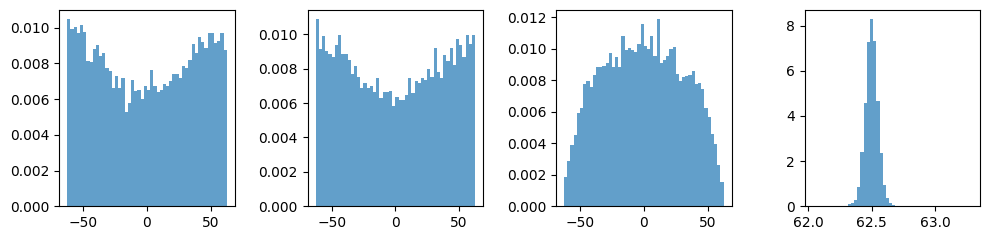

    pt: [[60.6], [56.1], [62.4], [59.6], [57.7], ... [59.5], [62.1], [58.4], [61.5], [35.3]]
    eta: [[0.247], [-0.472], [0.0465], [0.31], ... [-0.108], [-0.372], [-0.176], [1.17]]
    phi: [[0.412], [0.911], [0.569], [2.8], [2.96, ... [-2.16], [2.84], [0.862], [0.217]]
    M: [[1.78], [1.78], [1.78], [1.78], [1.78], ... [1.77], [1.78], [1.78], [1.78], [1.78]]
 ---> Plotting ---> 


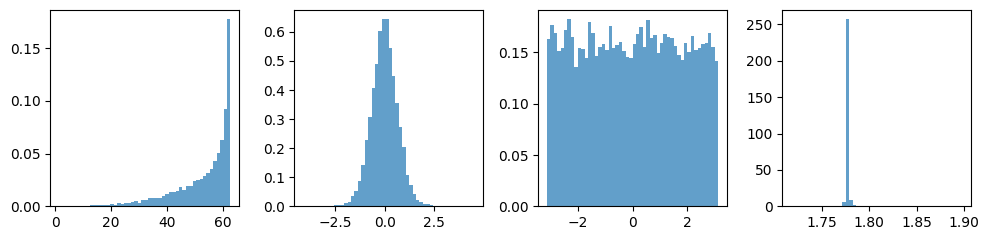

  ===> os pion in Higgs rest frame ===>
    px: [[30.3], [2.78], [13], [-11.8], [-25.4], ... 7.55], [-11.1], [-33.6], [22.1], [7.69]]
    py: [[13.3], [3.89], [8.4], [4.72], [4.9], ... [6.7], [-17.2], [11.4], [25.3], [1.73]]
    pz: [[8.71], [-2.58], [0.906], [4.03], [-11.3, ... [-2.17], [-13.5], [-6.18], [11.1]]
    E: [[34.2], [5.43], [15.5], [13.3], [28.2], ... [10.5], [20.6], [38], [34.2], [13.6]]
 ---> Plotting ---> 


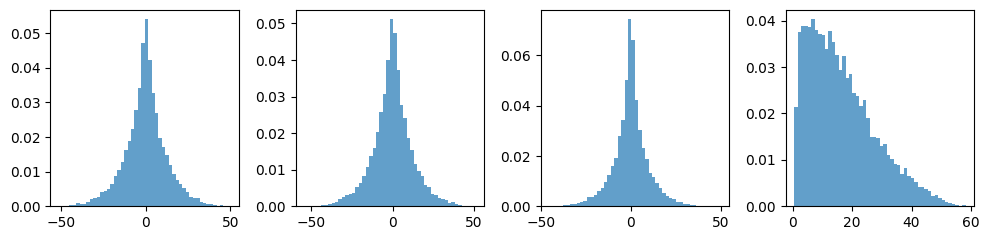

    pt: [[33.1], [4.78], [15.5], [12.7], [25.8], ... [10.1], [20.5], [35.5], [33.6], [7.88]]
    eta: [[0.26], [-0.516], [0.0585], [0.313], ... [-0.106], [-0.372], [-0.183], [1.14]]
    phi: [[0.412], [0.949], [0.573], [2.76], [2.95, ... [-2.14], [2.81], [0.851], [0.221]]
    M: [[nan], [nan], [0.00188], [0.00614], ... [0.00181], [0.0172], [nan], [nan]]
 ---> Plotting ---> 


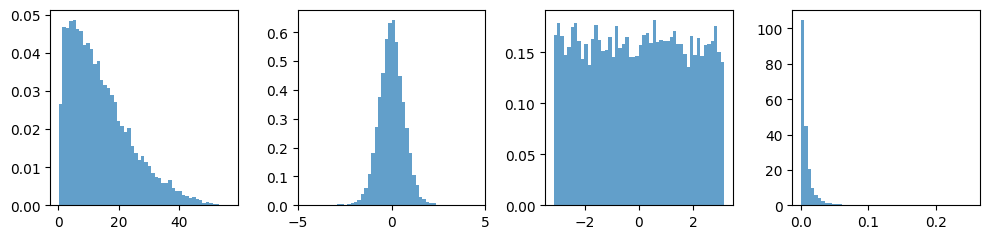

  ===> ss pion1 in Higgs rest frame ===>
    px: [[4.68], [6.87], [1.42], [-8.35], [-15], ... [10], [-2.73], [-6.8], [3.12], [3.4]]
    py: [[2.02], [8.3], [0.774], [2.75], [2.77], ... [9.33], [-3.76], [2], [3.75], [0.799]]
    pz: [[1.27], [-4.86], [0.12], [2.58], [-6.11, ... [-0.555], [-2.49], [-1.1], [5.14]]
    E: [[5.25], [11.8], [1.63], [9.16], [16.4], ... [14.3], [4.68], [7.52], [5.01], [6.21]]
 ---> Plotting ---> 


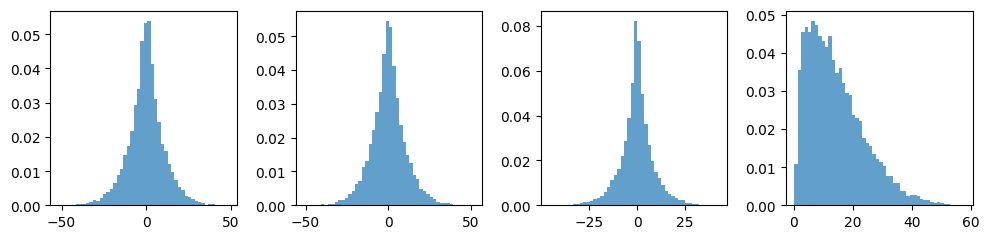

    pt: [[5.09], [10.8], [1.62], [8.79], [15.2], ... [13.7], [4.64], [7.09], [4.88], [3.49]]
    eta: [[0.246], [-0.437], [0.0741], [0.289], ... [-0.119], [-0.344], [-0.223], [1.18]]
    phi: [[0.407], [0.879], [0.498], [2.82], [2.96, ... [-2.2], [2.86], [0.876], [0.231]]
    M: [[0.14], [0.14], [0.14], [0.14], [0.14], ... [0.138], [0.14], [0.14], [0.14], [0.14]]
 ---> Plotting ---> 


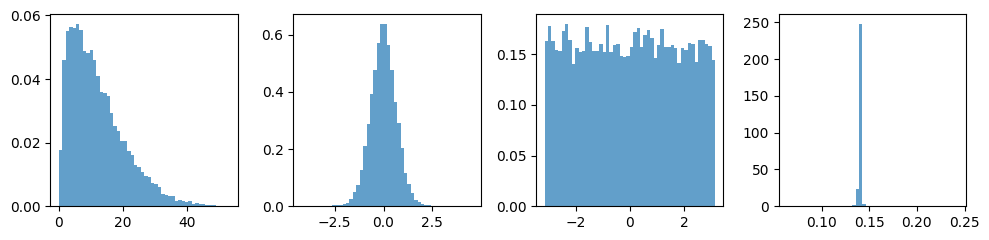

  ===> ss pion2 in Higgs rest frame ===>
    px: [[5.08], [12.3], [12.4], [-15.6], [-14.9], ... 20], [-17.1], [-6.44], [7.22], [11.4]]
    py: [[2.57], [15.6], [7.43], [5.76], [2.58], ... [18.9], [-24.8], [1.82], [8.79], [2.94]]
    pz: [[1.51], [-9.55], [0.399], [4.87], [-6.1, ... [-2.97], [-2.41], [-2.05], [18.1]]
    E: [[5.9], [22], [14.4], [17.3], [16.3], ... [28.9], [30.3], [7.11], [11.6], [21.6]]
 ---> Plotting ---> 


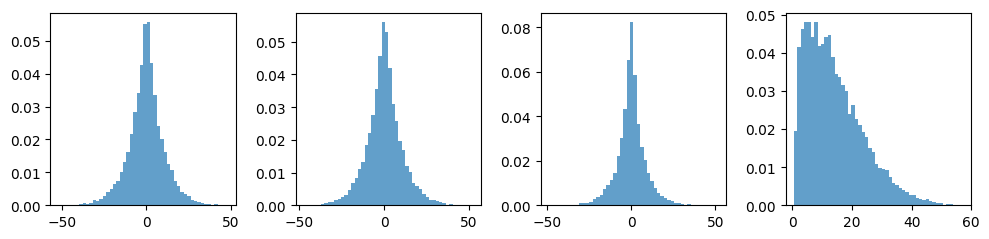

    pt: [[5.7], [19.9], [14.4], [16.6], [15.1], ... [27.5], [30.1], [6.69], [11.4], [11.8]]
    eta: [[0.262], [-0.464], [0.0277], [0.29], ... [-0.0984], [-0.352], [-0.179], [1.22]]
    phi: [[0.469], [0.904], [0.541], [2.79], [2.97, ... [-2.17], [2.87], [0.883], [0.253]]
    M: [[0.14], [0.14], [0.139], [0.14], [0.14, ... 0.13], [0.139], [0.14], [0.14], [0.139]]
 ---> Plotting ---> 


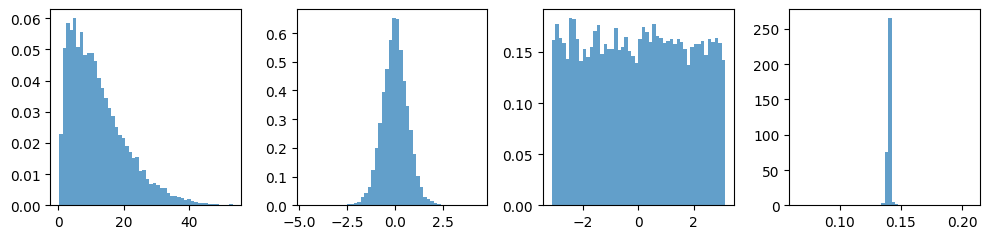

 --- Configure PolarimetricA1 --- : --- Start --- 
 --- Setup --- : --- Start --- 
RF_p4_tau: [[{x: 55.5, y: 24.3, z: 15.1, t: 62.4}], ... x: 34.4, y: 7.6, z: 51.5, t: 62.5}]]
RF_p4_os_pi: [[{x: 30.3, y: 13.3, z: 8.71, t: 34.2}], ... x: 7.69, y: 1.73, z: 11.1, t: 13.6}]]
RF_p4_ss1_pi: [[{x: 4.68, y: 2.02, z: 1.27, t: 5.25}], ... x: 3.4, y: 0.799, z: 5.14, t: 6.21}]]
RF_p4_ss2_pi: [[{x: 4.68, y: 2.02, z: 1.27, t: 5.25}], ... x: 3.4, y: 0.799, z: 5.14, t: 6.21}]]
 --- Setup --- : --- End --- 

RFdict: {'p4_tau': <LorentzVectorArray [[{x: 55.5, y: 24.3, ... t: 62.5}]] type='14014 * option[var...'>, 'p4_os_pi': <LorentzVectorArray [[{x: 30.3, y: 13.3, ... t: 13.6}]] type='14014 * option[var...'>, 'p4_ss1_pi': <LorentzVectorArray [[{x: 4.68, y: 2.02, ... t: 6.21}]] type='14014 * option[var...'>, 'p4_ss2_pi': <LorentzVectorArray [[{x: 4.68, y: 2.02, ... t: 6.21}]] type='14014 * option[var...'>}
 --- Configure PolarimetricA1 --- : --- End --- 

 --- PVC --- : --- Start ---
a1 ===>
    px: [[3

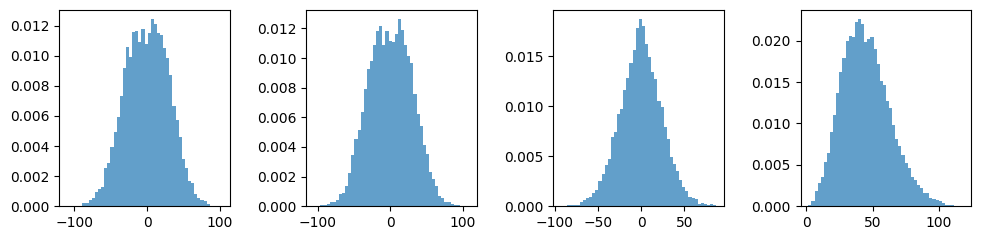

    pt: [[43.3], [26.3], [18.7], [30.2], [56.3], ... [37.4], [29.8], [49.7], [43.4], [14.9]]
    eta: [[0.257], [-0.452], [0.0612], [0.299], ... [-0.11], [-0.364], [-0.192], [1.16]]
    phi: [[0.411], [0.892], [0.56], [2.8], [2.95, ... [-2.16], [2.83], [0.857], [0.226]]
    M: [[0.635], [1.11], [0.863], [1.07], [1.05, ... [0.959], [1.24], [1.04], [0.486]]
 ---> Plotting ---> 


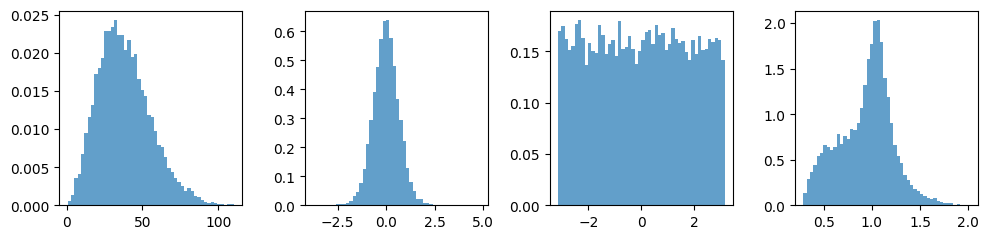

Nu ===>
    px: [[15.8], [17.9], [36.7], [-27.7], [-1.42, ... [-17.9], [-8.47], [11.6], [19.9]]
    py: [[6.97], [23.9], [23.7], [9.97], [0.251], ... [15.3], [-27], [2.17], [13.9], [4.27]]
    pz: [[3.87], [-15.2], [1.76], [9.62], [-0.503, ... [-3.44], [-3.74], [-2.49], [30.2]]
    E: [[17.7], [33.5], [43.7], [30.9], [1.53], ... [23.3], [32.6], [9.51], [18.3], [36.4]]
 ---> Plotting ---> 


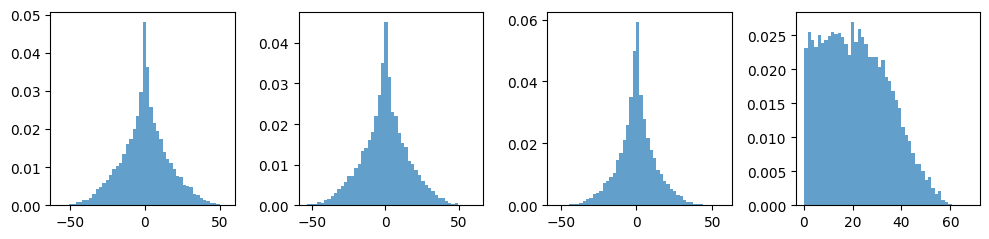

    pt: [[17.2], [29.8], [43.7], [29.4], [1.44], ... [22.1], [32.4], [8.75], [18.1], [20.4]]
    eta: [[0.222], [-0.489], [0.0402], [0.322], ... [-0.106], [-0.415], [-0.137], [1.18]]
    phi: [[0.416], [0.927], [0.572], [2.8], [2.97, ... [-2.16], [2.89], [0.874], [0.211]]
    M: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
 ---> Plotting ---> 


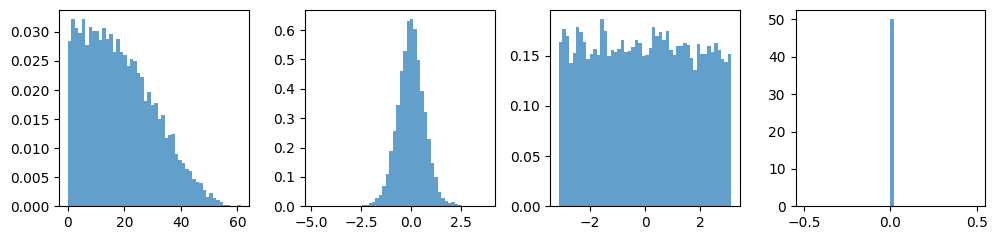

s1: ss2_pi + os_pi : [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
s2: ss1_pi + os_pi : [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
s3: ss1_pi + ss2_pi: [[0.078], [0.0779], [0.078], [0.0779], ... [0.0779], [0.078], [0.078], [0.078]]
 ---> Plotting ---> 


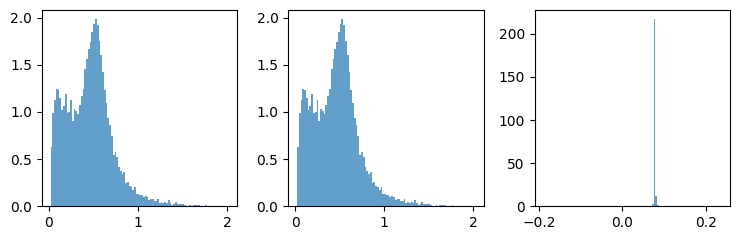

vec1 ===>
    px: [[1e+05], [-903], [3.89e+03], [-2.42e+03, ... [-3.86e+04], [1.43e+04], [3.8e+03]]
    py: [[8.32e+03], [-1.5e+03], [1e+03], [178, ... [1.44e+03], [2.15e+04], [42.7]]
    pz: [[2.33e+03], [279], [0.6], [106], ... [-17.3], [-2.43e+03], [-328], [1.16e+04]]
    E: [[1.44e+05], [-4.38e+03], [6.55e+03], ... [5.53e+04], [5.31e+04], [2.13e+04]]
 ---> Plotting ---> 


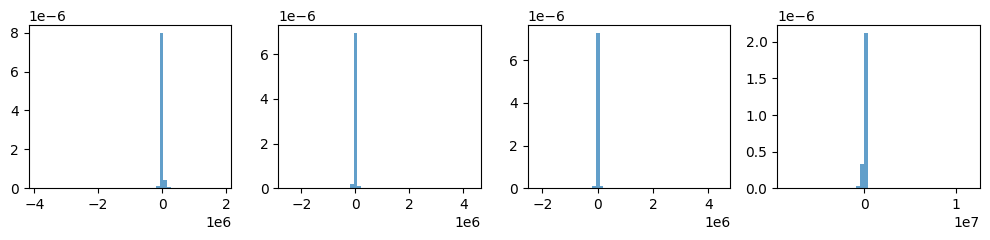

vec2 ===> 
    px: [[-1e+05], [903], [-3.89e+03], [2.42e+03, ... [3.86e+04], [-1.43e+04], [-3.8e+03]]
    py: [[-8.32e+03], [1.5e+03], [-1e+03], [-178, ... [-1.44e+03], [-2.15e+04], [-42.7]]
    pz: [[-2.33e+03], [-279], [-0.6], [-106], ... [17.3], [2.43e+03], [328], [-1.16e+04]]
    E: [[-1.44e+05], [4.38e+03], [-6.55e+03], ... [-5.53e+04], [-5.31e+04], [-2.13e+04]]
 ---> Plotting ---> 


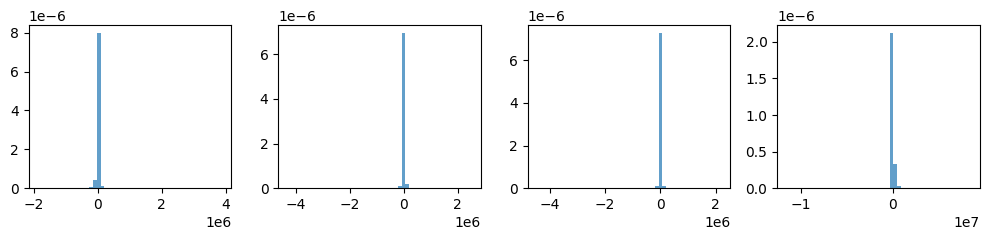

vec3 ===>
    px: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
    py: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
    pz: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
    E: [[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
 ---> Plotting ---> 


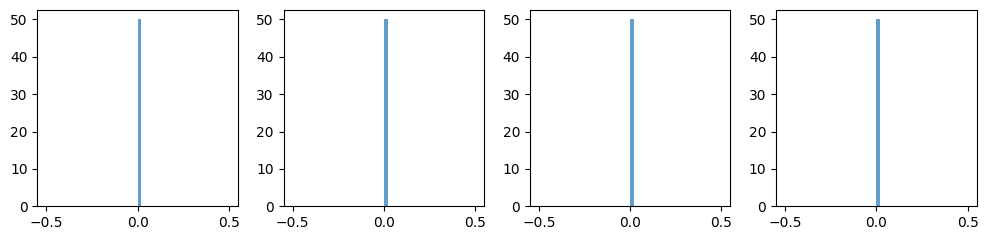

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> F1 ===>
 --- F3PI --- : --- Start ---
  BT1: 1.0	0.0
  BT2: -0.11994078724388779	0.0037692910893753883
  BT3: 0.3296724139496961	-0.16797648490363232
  BT4: -0.0818742325871075	0.8661389092046796
  BT5: -0.1330407333558646	0.6974239480173688
  BT6: 1.5752332462239653	1.388754917179669
  BT7: -0.09650658984451436	-0.7639283200121479
  F3PIFactor: 0.0	0.0
  IDK: 1
  IFORM: 1
  S1: [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
  S2: [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
  S3: [[0.095], [0.0948], [0.0949], [0.0948], ... [0.0949], [0.0946], [0.0952], [0.0949]]
  F134: [[0.0294], [0.167], [0.0866], [0.152], ... [0.116], [0.22], [0.141], [0.00164]]
  F150: [[-0.0062], [-0.0168], [-0.0106], [-0.0156, ... [-0.0207], [-0.0149], [-0.00402]]
  F167: 0.6666666666666666
  === FRO1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05


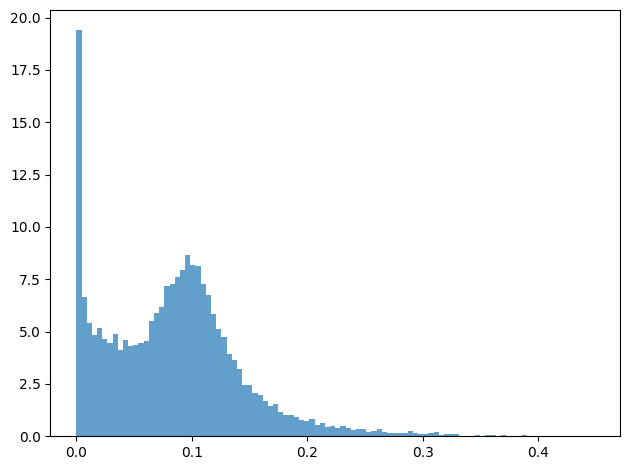

  out: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]
 ---> Plotting ---> 


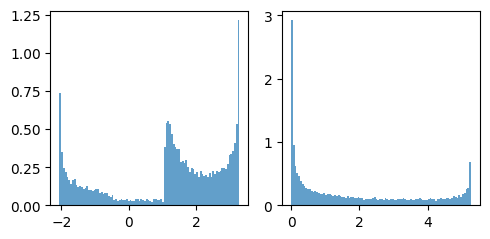

 --- BWIGML --- : --- End ---
  === FRO1: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]

  === FRP1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 ---> Plotting ---> 


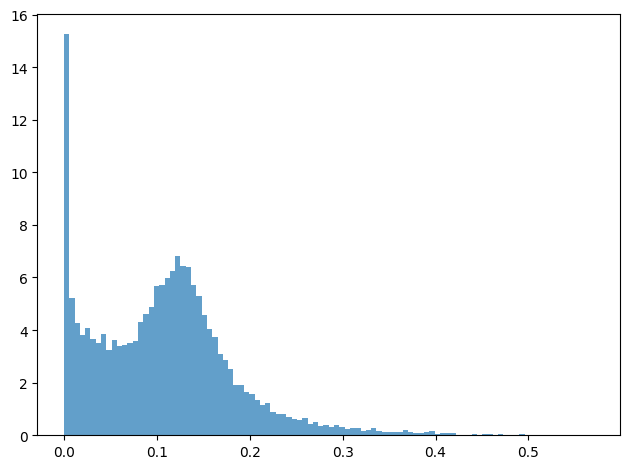

  out: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]
 ---> Plotting ---> 


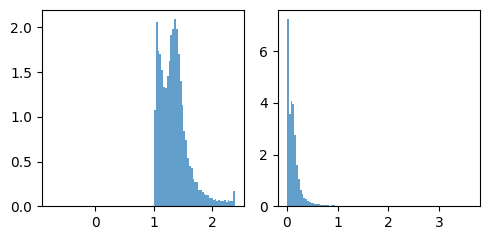

 --- BWIGML --- : --- End ---
  === FRP1: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]

  === FRO2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 0.59954049
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 0.723979355706531
  IPOW: 3
  WGS: [[0.0192], [0.115], [0.0581], [0.104], ... [0.0783], [0.152], [0.0959], [0.00265]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0192], [0.115], [0.0581], [0.104], ... [0.0783], [0.152], [0.0959], [0.00265]]
 ---> Plotting ---> 


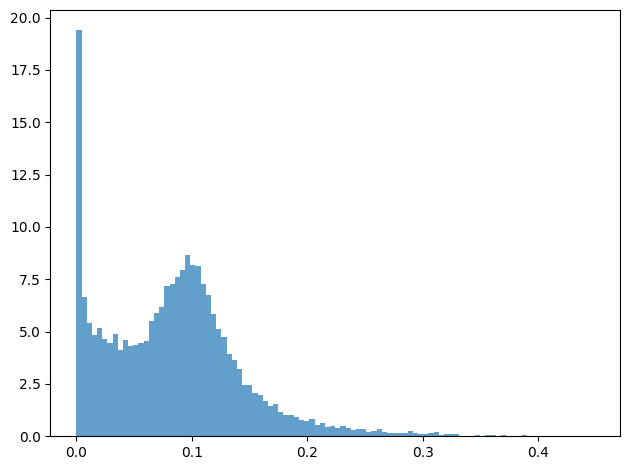

  out: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]
 ---> Plotting ---> 


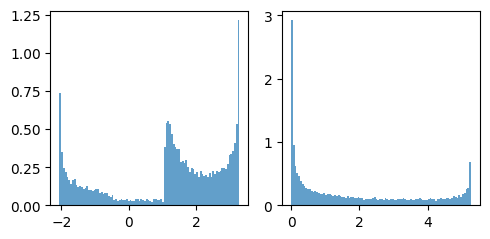

 --- BWIGML --- : --- End ---
  === FRO2: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]

  === FRP2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 ---> Plotting ---> 


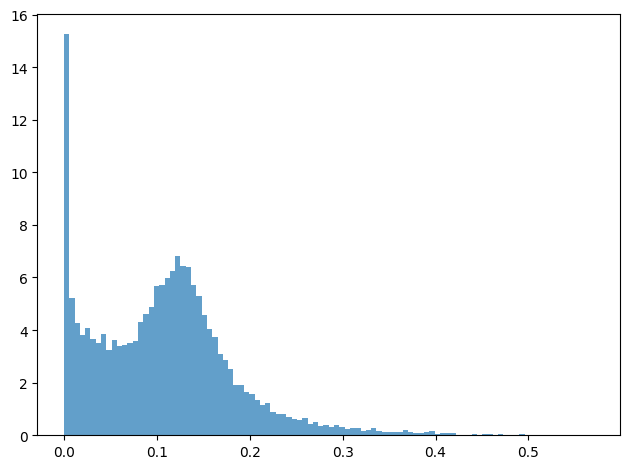

  out: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]
 ---> Plotting ---> 


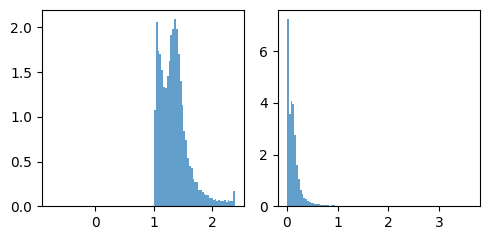

 --- BWIGML --- : --- End ---
  === FRP2: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]

  === FF23 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.6256249999999999
  W: [[0.308], [0.308], [0.308], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.149], [0.148], [0.148], [0.148], ... [0.148], [0.147], [0.149], [0.148]]
  QM: 1.246094005205771
  IPOW: 5
  WGS: [[2.38e-05], [2.33e-05], [2.34e-05], ... [2.27e-05], [2.4e-05], [2.34e-05]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[2.38e-05], [2.33e-05], [2.34e-05], ... [2.27e-05], [2.4e-05], [2.34e-05]]
 ---> Plotting ---> 


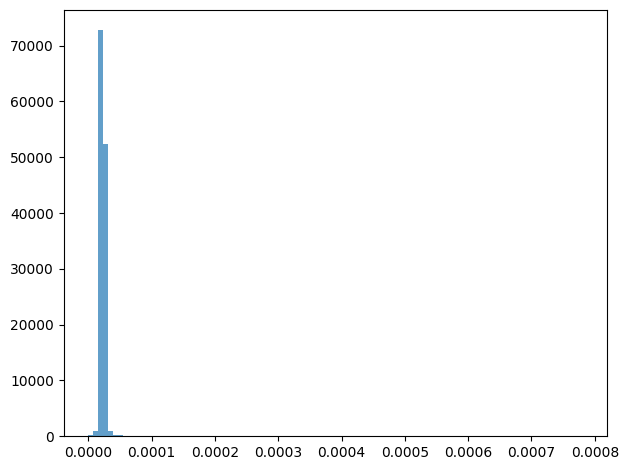

  out: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.65e-05], [1.61e-05], [1.62e-05], ... [1.57e-05], [1.67e-05], [1.63e-05]]
 ---> Plotting ---> 


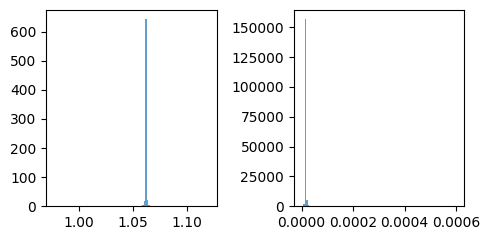

 --- BWIGML --- : --- End ---
  === FF23: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.65e-05], [1.61e-05], [1.62e-05], ... [1.57e-05], [1.67e-05], [1.63e-05]]

  === FSG3 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 0.7395999999999999
  W: [[0.308], [0.308], [0.308], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.149], [0.148], [0.148], [0.148], ... [0.148], [0.147], [0.149], [0.148]]
  QM: 0.8165324670885781
  IPOW: 1
  WGS: [[0.385], [0.384], [0.384], [0.384], ... [0.384], [0.382], [0.386], [0.384]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.385], [0.384], [0.384], [0.384], ... [0.384], [0.382], [0.386], [0.384]]
 ---> Plotting ---> 


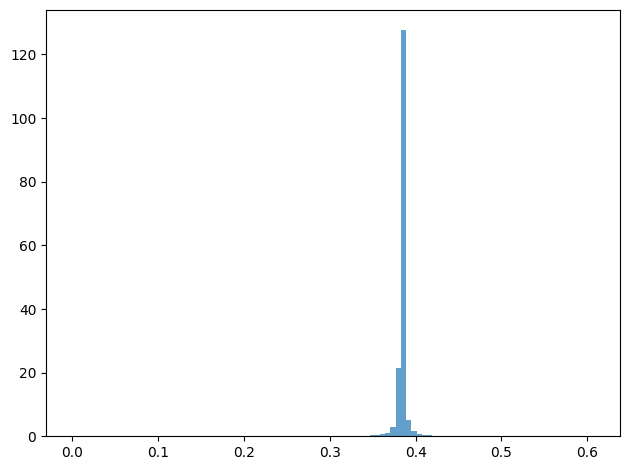

  out: [[0.846], [0.847], [0.847], [0.847], ... [0.847], [0.849], [0.845], [0.847]]	[[0.505], [0.504], [0.504], [0.504], ... [0.504], [0.503], [0.506], [0.504]]
 ---> Plotting ---> 


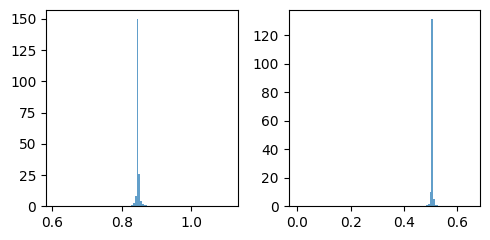

 --- BWIGML --- : --- End ---
  === FSG3: [[0.846], [0.847], [0.847], [0.847], ... [0.847], [0.849], [0.845], [0.847]]	[[0.505], [0.504], [0.504], [0.504], ... [0.504], [0.503], [0.506], [0.504]]

  === FF03 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.406596
  W: [[0.308], [0.308], [0.308], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.149], [0.148], [0.148], [0.148], ... [0.148], [0.147], [0.149], [0.148]]
  QM: 1.1548685075842011
  IPOW: 1
  WGS: [[0.206], [0.205], [0.205], [0.205], ... [0.205], [0.204], [0.206], [0.205]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.206], [0.205], [0.205], [0.205], ... [0.205], [0.204], [0.206], [0.205]]
 ---> Plotting ---> 


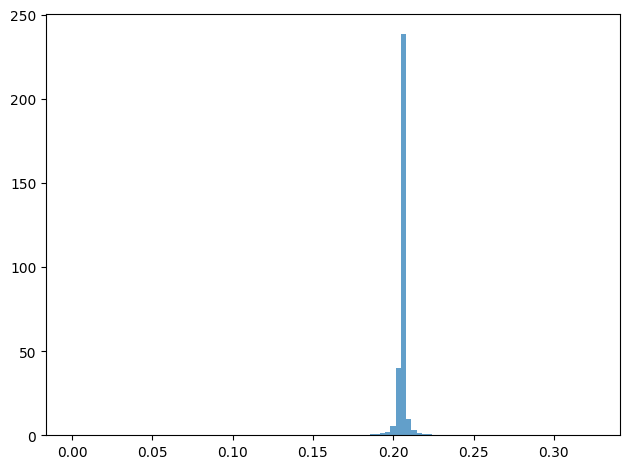

  out: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.164], [0.164], ... [0.164], [0.163], [0.165], [0.164]]
 ---> Plotting ---> 


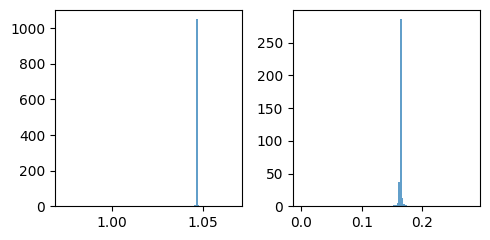

 --- BWIGML --- : --- End ---
  === FF03: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.164], [0.164], ... [0.164], [0.163], [0.165], [0.164]]

  F3PIFactor: [[1.75], [0.563], [2.66], [2.73], [3.36], ... 1.56], [3.44], [-1.88], [3.57], [1.51]]	[[0.855], [6.46], [1.38], [5.8], [5.02], ... 0.792], [2.38], [3.19], [4.56], [0.778]]


 --- FA1A1P --- : --- Start ---
 --- WGA1 --- : --- Start ---
  S: [[0.403], [1.23], [0.746], [1.14], [1.1, ... 0.273], [0.92], [1.55], [1.07], [0.236]]
 --- WGA1C ---: --- Start ---
  G1_IM: [[0.0379], [5.57], [0.833], [4.77], [4.38, ... [2.63], [8.06], [4.15], [0.00109]]
 --- WGA1C ---: --- End ---
 --- WGA1N --- : --- Start ---
  G1_IM: [[0.0446], [5.66], [0.895], [4.87], [4.48, ... [2.73], [8.07], [4.26], [0.00166]]
 --- WGA1N --- : --- End ---
  S > MK1SQ: [[False], [False], [False], [False], ... [False], [False], [False], [False]]
  GKST: [[0], [0], [0], [0], [0], [0], [0], [0, ... [0.226], [0]

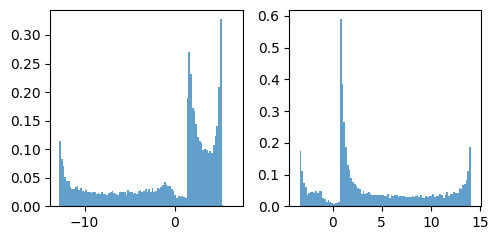

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> F2 ===>
 --- F3PI --- : --- Start ---
  BT1: 1.0	0.0
  BT2: -0.11994078724388779	0.0037692910893753883
  BT3: 0.3296724139496961	-0.16797648490363232
  BT4: -0.0818742325871075	0.8661389092046796
  BT5: -0.1330407333558646	0.6974239480173688
  BT6: 1.5752332462239653	1.388754917179669
  BT7: -0.09650658984451436	-0.7639283200121479
  F3PIFactor: 0.0	0.0
  IDK: 1
  IFORM: 2
  S1: [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
  S2: [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
  S3: [[0.095], [0.0948], [0.0949], [0.0948], ... [0.0949], [0.0946], [0.0952], [0.0949]]
  F134: [[0.0294], [0.167], [0.0866], [0.152], ... [0.116], [0.22], [0.141], [0.00164]]
  F150: [[-0.0062], [-0.0168], [-0.0106], [-0.0156, ... [-0.0207], [-0.0149], [-0.00402]]
  F167: 0.6666666666666666
  === FRO1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05


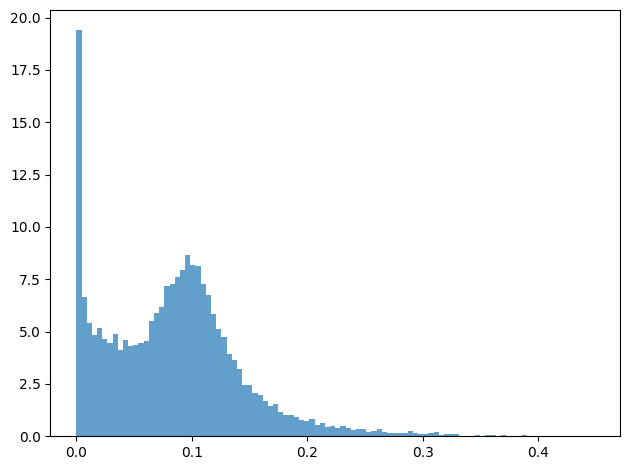

  out: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]
 ---> Plotting ---> 


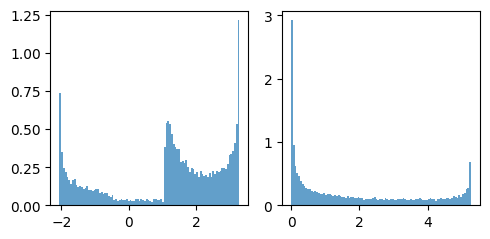

 --- BWIGML --- : --- End ---
  === FRO1: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]

  === FRP1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 ---> Plotting ---> 


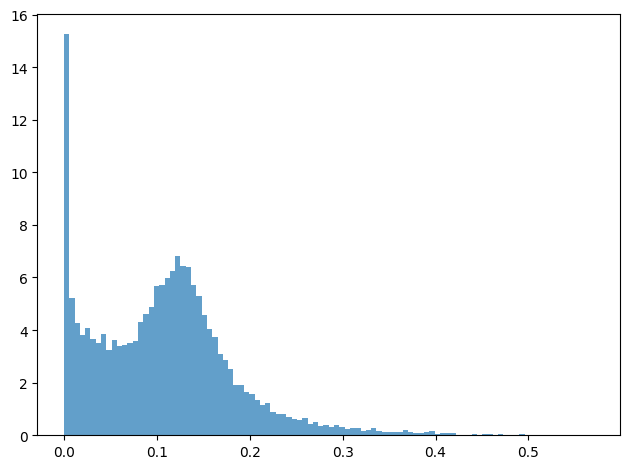

  out: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]
 ---> Plotting ---> 


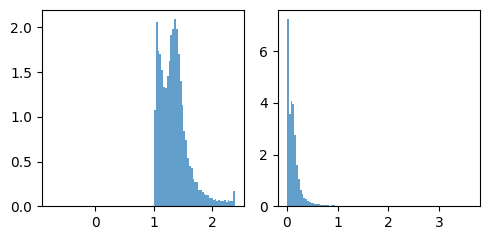

 --- BWIGML --- : --- End ---
  === FRP1: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]

  === FRO2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 0.59954049
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 0.723979355706531
  IPOW: 3
  WGS: [[0.0192], [0.115], [0.0581], [0.104], ... [0.0783], [0.152], [0.0959], [0.00265]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0192], [0.115], [0.0581], [0.104], ... [0.0783], [0.152], [0.0959], [0.00265]]
 ---> Plotting ---> 


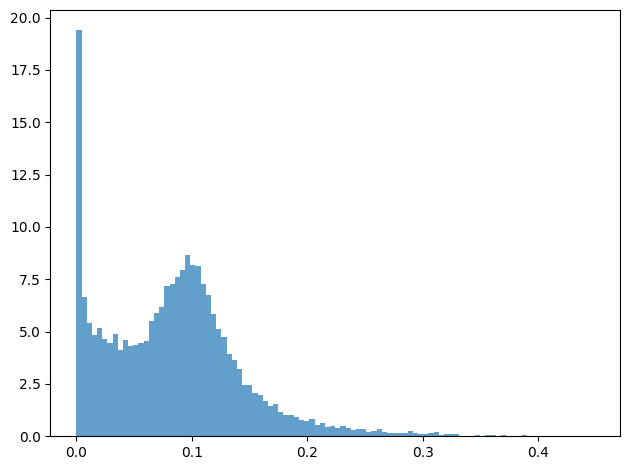

  out: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]
 ---> Plotting ---> 


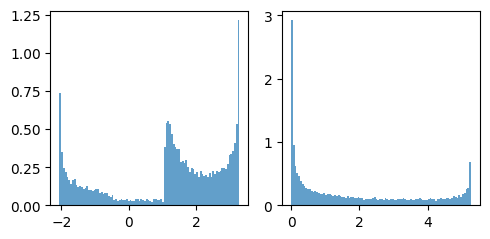

 --- BWIGML --- : --- End ---
  === FRO2: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]

  === FRP2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 ---> Plotting ---> 


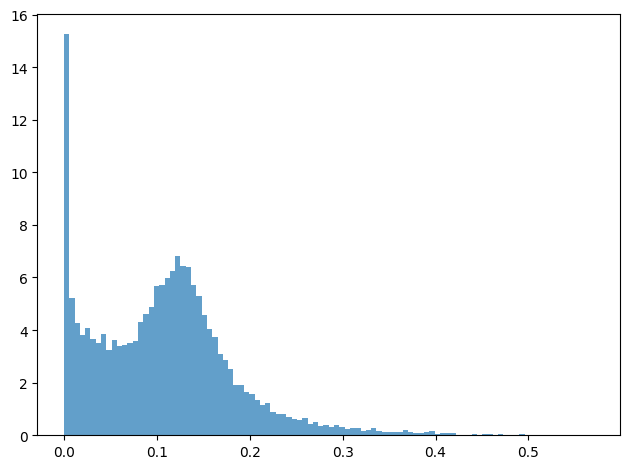

  out: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]
 ---> Plotting ---> 


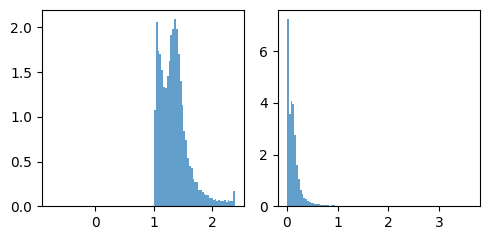

 --- BWIGML --- : --- End ---
  === FRP2: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]

  === FF23 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.6256249999999999
  W: [[0.308], [0.308], [0.308], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.149], [0.148], [0.148], [0.148], ... [0.148], [0.147], [0.149], [0.148]]
  QM: 1.246094005205771
  IPOW: 5
  WGS: [[2.38e-05], [2.33e-05], [2.34e-05], ... [2.27e-05], [2.4e-05], [2.34e-05]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[2.38e-05], [2.33e-05], [2.34e-05], ... [2.27e-05], [2.4e-05], [2.34e-05]]
 ---> Plotting ---> 


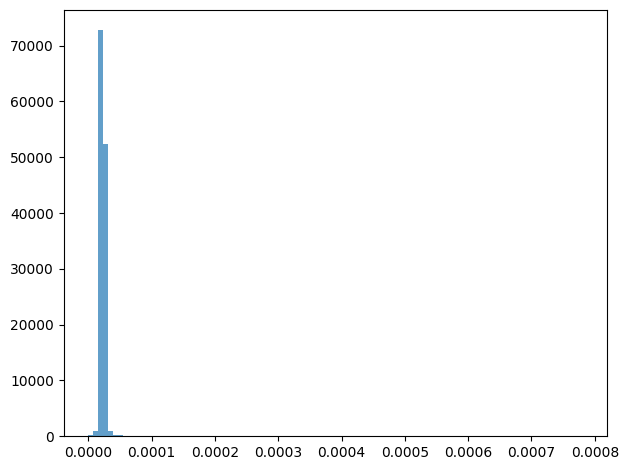

  out: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.65e-05], [1.61e-05], [1.62e-05], ... [1.57e-05], [1.67e-05], [1.63e-05]]
 ---> Plotting ---> 


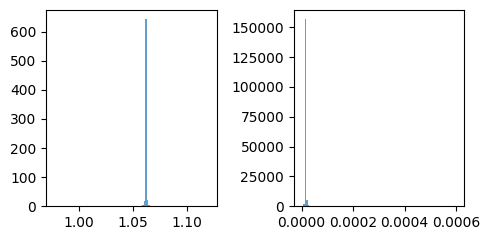

 --- BWIGML --- : --- End ---
  === FF23: [[1.06], [1.06], [1.06], [1.06], [1.06], ... [1.06], [1.06], [1.06], [1.06], [1.06]]	[[1.65e-05], [1.61e-05], [1.62e-05], ... [1.57e-05], [1.67e-05], [1.63e-05]]

  === FSG3 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 0.7395999999999999
  W: [[0.308], [0.308], [0.308], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.149], [0.148], [0.148], [0.148], ... [0.148], [0.147], [0.149], [0.148]]
  QM: 0.8165324670885781
  IPOW: 1
  WGS: [[0.385], [0.384], [0.384], [0.384], ... [0.384], [0.382], [0.386], [0.384]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.385], [0.384], [0.384], [0.384], ... [0.384], [0.382], [0.386], [0.384]]
 ---> Plotting ---> 


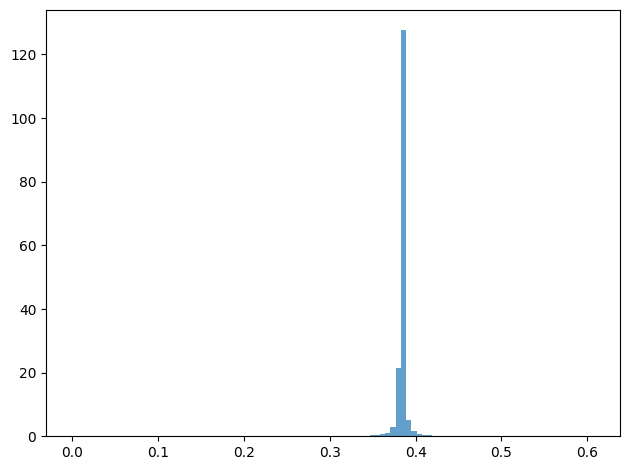

  out: [[0.846], [0.847], [0.847], [0.847], ... [0.847], [0.849], [0.845], [0.847]]	[[0.505], [0.504], [0.504], [0.504], ... [0.504], [0.503], [0.506], [0.504]]
 ---> Plotting ---> 


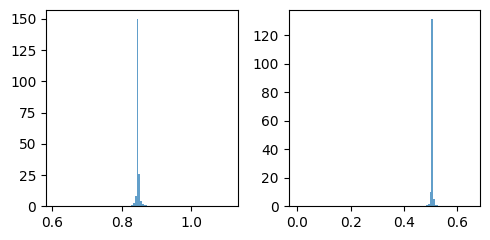

 --- BWIGML --- : --- End ---
  === FSG3: [[0.846], [0.847], [0.847], [0.847], ... [0.847], [0.849], [0.845], [0.847]]	[[0.505], [0.504], [0.504], [0.504], ... [0.504], [0.503], [0.506], [0.504]]

  === FF03 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.406596
  W: [[0.308], [0.308], [0.308], [0.308], ... [0.308], [0.308], [0.308], [0.308]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.149], [0.148], [0.148], [0.148], ... [0.148], [0.147], [0.149], [0.148]]
  QM: 1.1548685075842011
  IPOW: 1
  WGS: [[0.206], [0.205], [0.205], [0.205], ... [0.205], [0.204], [0.206], [0.205]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.206], [0.205], [0.205], [0.205], ... [0.205], [0.204], [0.206], [0.205]]
 ---> Plotting ---> 


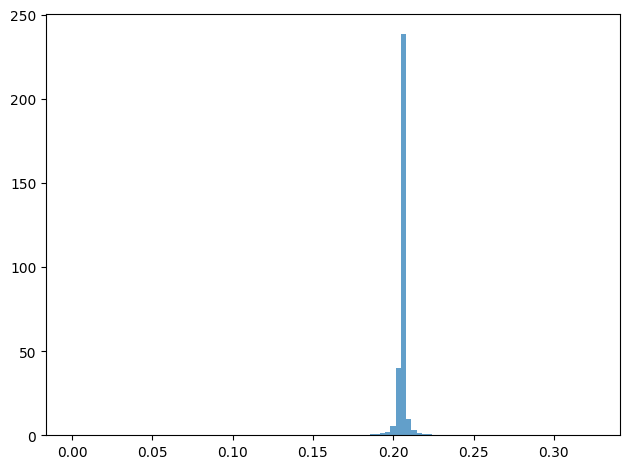

  out: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.164], [0.164], ... [0.164], [0.163], [0.165], [0.164]]
 ---> Plotting ---> 


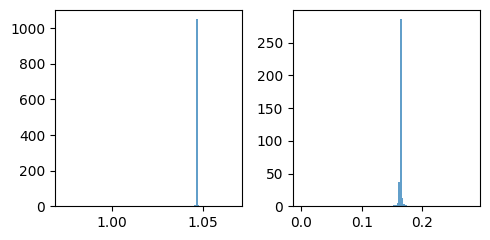

 --- BWIGML --- : --- End ---
  === FF03: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[0.164], [0.164], [0.164], [0.164], ... [0.164], [0.163], [0.165], [0.164]]

  F3PIFactor: [[1.75], [0.563], [2.66], [2.73], [3.36], ... 1.56], [3.44], [-1.88], [3.57], [1.51]]	[[0.855], [6.46], [1.38], [5.8], [5.02], ... 0.792], [2.38], [3.19], [4.56], [0.778]]


 --- FA1A1P --- : --- Start ---
 --- WGA1 --- : --- Start ---
  S: [[0.403], [1.23], [0.746], [1.14], [1.1, ... 0.273], [0.92], [1.55], [1.07], [0.236]]
 --- WGA1C ---: --- Start ---
  G1_IM: [[0.0379], [5.57], [0.833], [4.77], [4.38, ... [2.63], [8.06], [4.15], [0.00109]]
 --- WGA1C ---: --- End ---
 --- WGA1N --- : --- Start ---
  G1_IM: [[0.0446], [5.66], [0.895], [4.87], [4.48, ... [2.73], [8.07], [4.26], [0.00166]]
 --- WGA1N --- : --- End ---
  S > MK1SQ: [[False], [False], [False], [False], ... [False], [False], [False], [False]]
  GKST: [[0], [0], [0], [0], [0], [0], [0], [0, ... [0.226], [0]

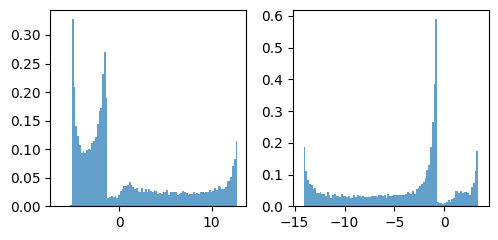

>>>>>>>>>>>>>>>>>>>>>>>>>>>>> F3 ===>
 --- F3PI --- : --- Start ---
  BT1: 1.0	0.0
  BT2: -0.11994078724388779	0.0037692910893753883
  BT3: 0.3296724139496961	-0.16797648490363232
  BT4: -0.0818742325871075	0.8661389092046796
  BT5: -0.1330407333558646	0.6974239480173688
  BT6: 1.5752332462239653	1.388754917179669
  BT7: -0.09650658984451436	-0.7639283200121479
  F3PIFactor: 0.0	0.0
  IDK: 1
  IFORM: 3
  S1: [[0.182], [0.596], [0.353], [0.549], ... [0.441], [0.754], [0.516], [0.0986]]
  S2: [[0.199], [0.613], [0.37], [0.566], [0.545, ... [0.458], [0.77], [0.533], [0.116]]
  S3: [[0.078], [0.0779], [0.078], [0.0779], ... [0.0779], [0.078], [0.078], [0.078]]
  F34A: [[0.0408], [0.179], [0.0979], [0.163], ... [0.127], [0.231], [0.152], [0.0129]]
  F34B: [[-0.0351], [-0.173], [-0.0922], [-0.158, ... [-0.226], [-0.146], [-0.00729]]
  F35: [[0.00854], [0.00849], [0.00847], [0.00847, ... [0.00831], [0.00859], [0.00847]]
  === FRO1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI -

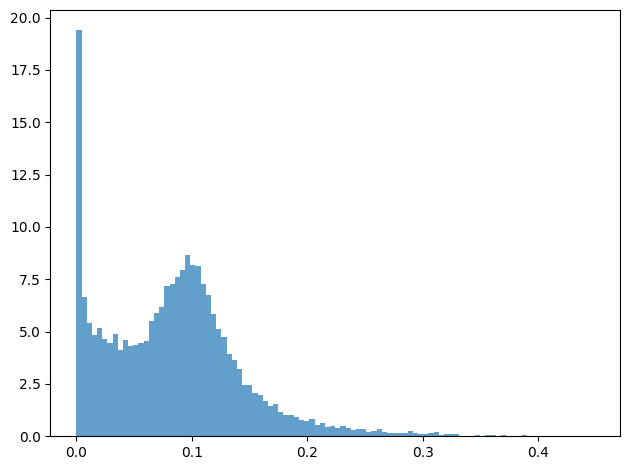

  out: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]
 ---> Plotting ---> 


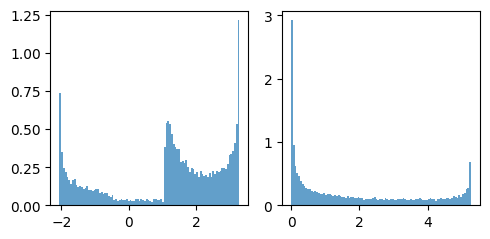

 --- BWIGML --- : --- End ---
  === FRO1: [[1.43], [0.182], [2.31], [2.26], [2.89], ... [1.24], [3.04], [-1.98], [3.1], [1.2]]	[[0.0659], [5.23], [0.544], [4.69], [3.98, ... [1.5], [1.95], [3.56], [0.00634]]

  === FRP1 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.427], [0.772], [0.594], [0.741], ... [0.664], [0.868], [0.718], [0.314]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.326], [0.721], [0.527], [0.689], ... [0.604], [0.824], [0.664], [0.152]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0244], [0.146], [0.0739], [0.132], ... [0.0996], [0.193], [0.122], [0.00337]]
 ---> Plotting ---> 


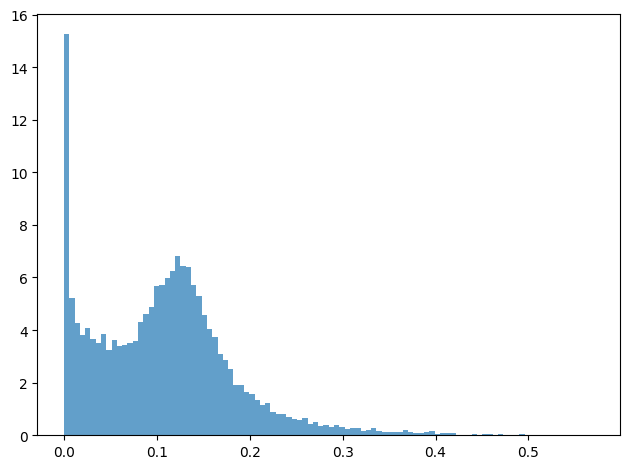

  out: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]
 ---> Plotting ---> 


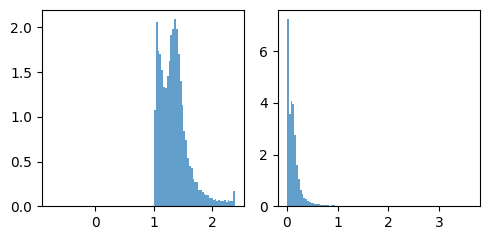

 --- BWIGML --- : --- End ---
  === FRP1: [[1.11], [1.45], [1.23], [1.4], [1.38], ... [1.07], [1.3], [1.62], [1.37], [1.06]]	[[0.016], [0.164], [0.0596], [0.139], ... [0.0902], [0.279], [0.123], [0.002]]

  === FRO2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 0.59954049
  W: [[0.446], [0.783], [0.608], [0.753], [0.738, ... [0.676], [0.878], [0.73], [0.34]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.352], [0.733], [0.543], [0.701], [0.685, ... [0.618], [0.834], [0.677], [0.2]]
  QM: 0.723979355706531
  IPOW: 3
  WGS: [[0.023], [0.118], [0.062], [0.108], ... [0.0823], [0.155], [0.0999], [0.00558]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.023], [0.118], [0.062], [0.108], ... [0.0823], [0.155], [0.0999], [0.00558]]
 ---> Plotting ---> 


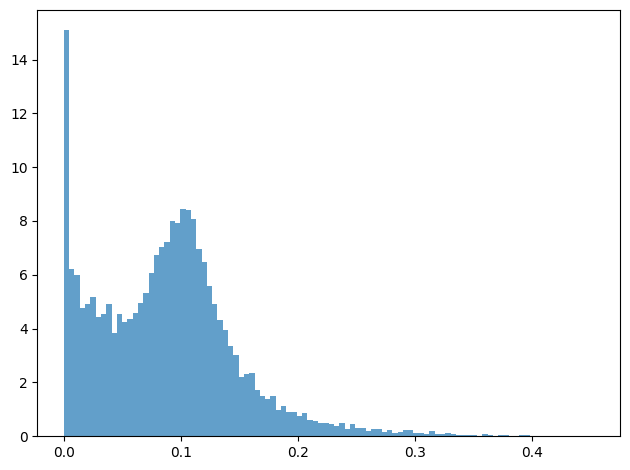

  out: [[1.49], [-0.548], [2.44], [1.56], [2.43, ... 1.29], [3.16], [-1.92], [2.76], [1.24]]	[[0.0855], [5], [0.659], [5.09], [4.54, ... [1.83], [1.75], [4.16], [0.0143]]
 ---> Plotting ---> 


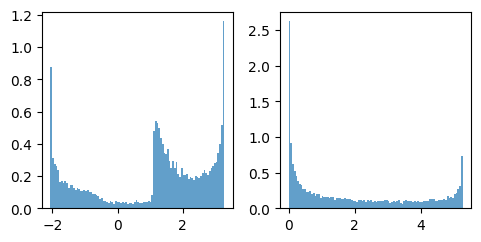

 --- BWIGML --- : --- End ---
  === FRO2: [[1.49], [-0.548], [2.44], [1.56], [2.43, ... 1.29], [3.16], [-1.92], [2.76], [1.24]]	[[0.0855], [5], [0.659], [5.09], [4.54, ... [1.83], [1.75], [4.16], [0.0143]]

  === FRP2 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.0753759344083684
  MM: 2.1100977216399873e-05
  MSQ: 1.8769000000000002
  W: [[0.446], [0.783], [0.608], [0.753], [0.738, ... [0.676], [0.878], [0.73], [0.34]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.352], [0.733], [0.543], [0.701], [0.685, ... [0.618], [0.834], [0.677], [0.2]]
  QM: 1.34220110714658
  IPOW: 3
  WGS: [[0.0292], [0.151], [0.0788], [0.137], ... [0.105], [0.198], [0.127], [0.00709]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[0.0292], [0.151], [0.0788], [0.137], ... [0.105], [0.198], [0.127], [0.00709]]
 ---> Plotting ---> 


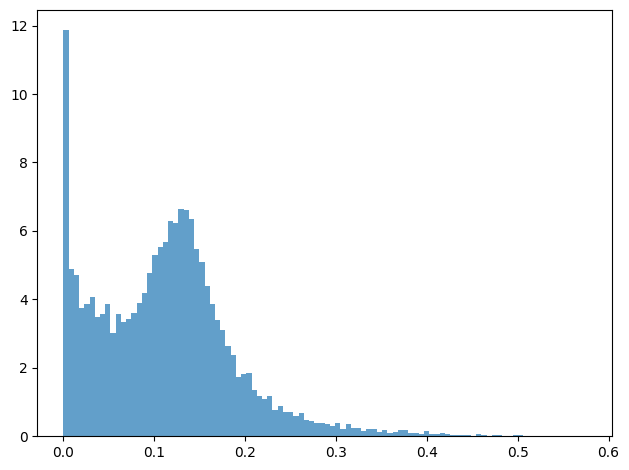

  out: [[1.12], [1.46], [1.24], [1.42], [1.4], ... [1.08], [1.32], [1.64], [1.38], [1.07]]	[[0.0195], [0.174], [0.065], [0.148], ... [0.097], [0.294], [0.131], [0.00429]]
 ---> Plotting ---> 


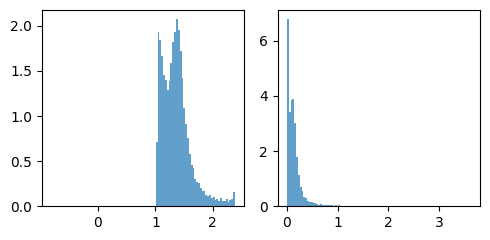

 --- BWIGML --- : --- End ---
  === FRP2: [[1.12], [1.46], [1.24], [1.42], [1.4], ... [1.08], [1.32], [1.64], [1.38], [1.07]]	[[0.0195], [0.174], [0.065], [0.148], ... [0.097], [0.294], [0.131], [0.00429]]

  === FF23 ===>
 --- BWIGML --- : --- Start --- : --- calling from F3PI --- 
  MP: 0.07287473019024
  MM: 0.0
  MSQ: 1.6256249999999999
  W: [[0.279], [0.279], [0.279], [0.279], ... [0.279], [0.279], [0.279], [0.279]]
 --- GetWGS --- : --- Start --- : --- calling from BWIGML ---
  QS: [[0.0715], [0.0706], [0.0713], [0.0708], ... [0.0712], [0.0716], [0.0714], [0.0714]]
  QM: 1.246094005205771
  IPOW: 5
  WGS: [[6.68e-07], [6.3e-07], [6.59e-07], ... [6.76e-07], [6.67e-07], [6.65e-07]]
 --- GetWGS --- : --- End ---
  W > m1+m2: [[True], [True], [True], [True], [True], ... [True], [True], [True], [True], [True]]
  WGS: [[6.68e-07], [6.3e-07], [6.59e-07], ... [6.76e-07], [6.67e-07], [6.65e-07]]
 ---> Plotting ---> 


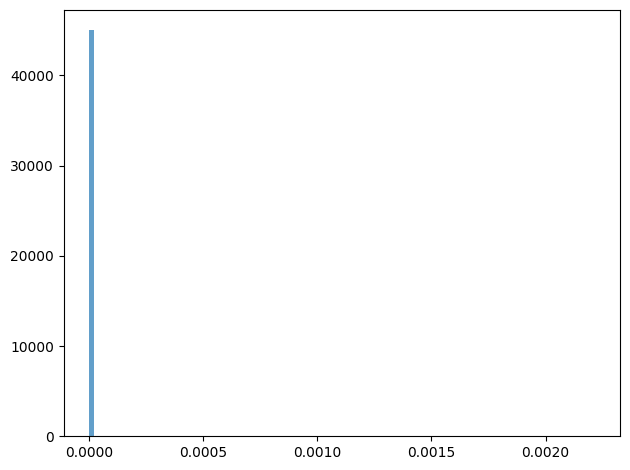

  out: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[4.53e-07], [4.27e-07], [4.47e-07], ... [4.59e-07], [4.53e-07], [4.51e-07]]
 ---> Plotting ---> 


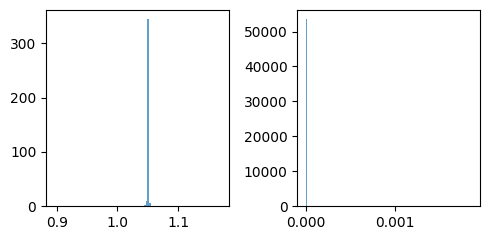

 --- BWIGML --- : --- End ---
  === FF23: [[1.05], [1.05], [1.05], [1.05], [1.05], ... [1.05], [1.05], [1.05], [1.05], [1.05]]	[[4.53e-07], [4.27e-07], [4.47e-07], ... [4.59e-07], [4.53e-07], [4.51e-07]]

  F3PIFactor: [[0.0003], [0.0527], [-0.00243], [0.0333, ... [0.00146], [0.00907], [0.000463]]	[[0.0102], [0.0122], [0.00851], [-0.0217, ... [0.0323], [-0.0228], [0.0102]]


 --- FA1A1P --- : --- Start ---
 --- WGA1 --- : --- Start ---
  S: [[0.403], [1.23], [0.746], [1.14], [1.1, ... 0.273], [0.92], [1.55], [1.07], [0.236]]
 --- WGA1C ---: --- Start ---
  G1_IM: [[0.0379], [5.57], [0.833], [4.77], [4.38, ... [2.63], [8.06], [4.15], [0.00109]]
 --- WGA1C ---: --- End ---
 --- WGA1N --- : --- Start ---
  G1_IM: [[0.0446], [5.66], [0.895], [4.87], [4.48, ... [2.73], [8.07], [4.26], [0.00166]]
 --- WGA1N --- : --- End ---
  S > MK1SQ: [[False], [False], [False], [False], ... [False], [False], [False], [False]]
  GKST: [[0], [0], [0], [0], [0], [0], [0], [0, ... [0.226], [0], [0], [0], [0]

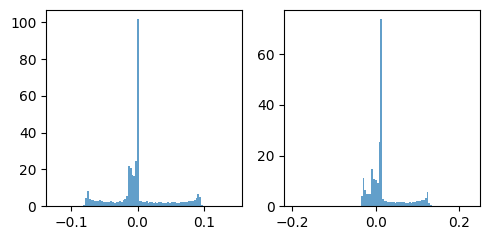

  HC_E: 
  Re: [[6.3e+05], [9.83e+04], [5.72e+04], ... [-7.43e+05], [5.45e+04], [7.09e+04]]
  Im: [[3.11e+05], [-8.73e+04], [3.67e+04], ... [-3.4e+05], [1.38e+06], [3.66e+04]]
 ---> Plotting ---> 


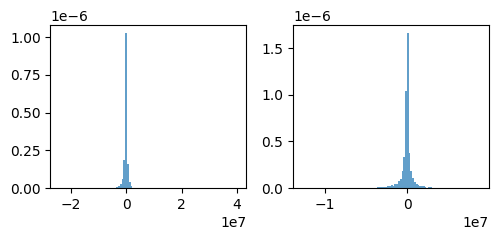

  HC_Px: 
  Re: [[4.39e+05], [2.03e+04], [3.4e+04], ... [5.19e+05], [1.47e+04], [1.27e+04]]
  Im: [[2.17e+05], [-1.8e+04], [2.19e+04], ... [2.37e+05], [3.71e+05], [6.53e+03]]
 ---> Plotting ---> 


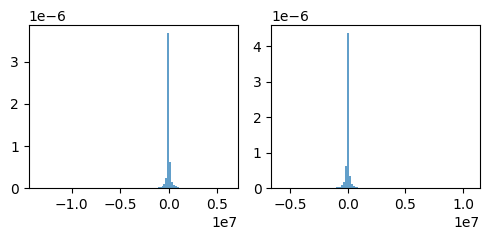

  HC_Py: 
  Re: [[3.64e+04], [3.37e+04], [8.78e+03], ... [-1.94e+04], [2.21e+04], [142]]
  Im: [[1.8e+04], [-2.99e+04], [5.64e+03], ... [-8.87e+03], [5.59e+05], [73.3]]
 ---> Plotting ---> 


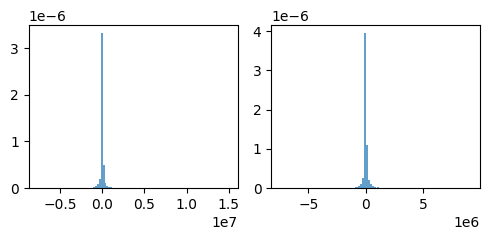

  HC_Pz: 
  Re: [[1.02e+04], [-6.25e+03], [5.24], [-955], ... [-172], [3.26e+04], [-337], [3.85e+04]]
  Im: [[5.02e+03], [5.55e+03], [3.37], ... [1.49e+04], [-8.52e+03], [1.99e+04]]
 ---> Plotting ---> 


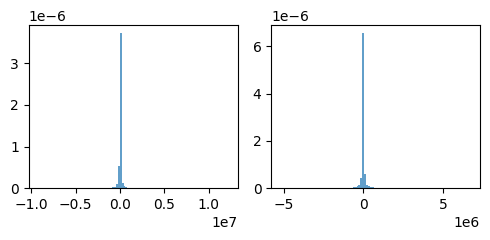

  C-HC_E: 
  Re: [[6.3e+05], [9.83e+04], [5.72e+04], ... [-7.43e+05], [5.45e+04], [7.09e+04]]
  Im: [[-3.11e+05], [8.73e+04], [-3.67e+04], ... [3.4e+05], [-1.38e+06], [-3.66e+04]]
 ---> Plotting ---> 


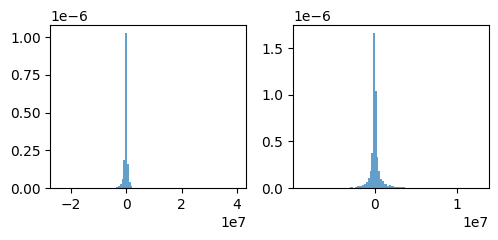

  C-HC_Px: 
  Re: [[4.39e+05], [2.03e+04], [3.4e+04], ... [5.19e+05], [1.47e+04], [1.27e+04]]
  Im: [[-2.17e+05], [1.8e+04], [-2.19e+04], ... [-2.37e+05], [-3.71e+05], [-6.53e+03]]
 ---> Plotting ---> 


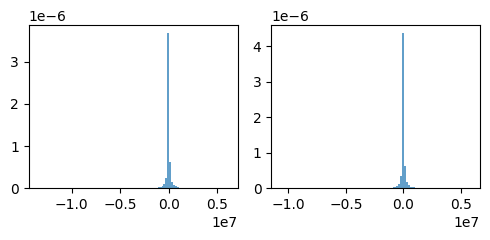

  C-HC_Py: 
  Re: [[3.64e+04], [3.37e+04], [8.78e+03], ... [-1.94e+04], [2.21e+04], [142]]
  Im: [[-1.8e+04], [2.99e+04], [-5.64e+03], ... [8.87e+03], [-5.59e+05], [-73.3]]
 ---> Plotting ---> 


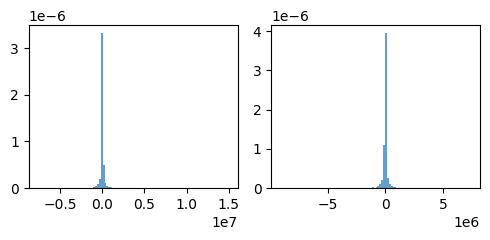

  C-HC_Pz: 
  Re: [[1.02e+04], [-6.25e+03], [5.24], [-955], ... [-172], [3.26e+04], [-337], [3.85e+04]]
  Im: [[-5.02e+03], [-5.55e+03], [-3.37], ... [-1.49e+04], [8.52e+03], [-1.99e+04]]
 ---> Plotting ---> 


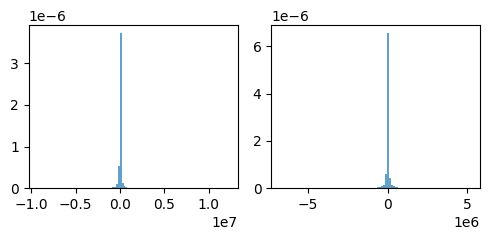

 --- CLVEC --- : --- Start ---
  HN: [[3.91e+06], [2.03e+06], [1.04e+06], ... [-2.51e+06], [5.19e+05], [1.17e+06]]	[[1.93e+06], [-1.8e+06], [6.7e+05], ... [-1.15e+06], [1.31e+07], [6.01e+05]]
 ---> Plotting ---> 


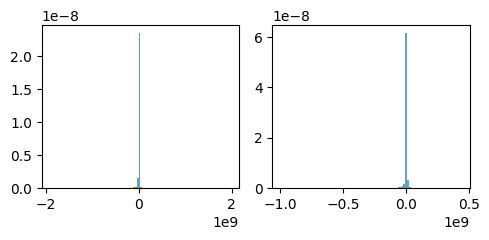

  HCN: [[3.91e+06], [2.03e+06], [1.04e+06], ... [-2.51e+06], [5.19e+05], [1.17e+06]]	[[-1.93e+06], [1.8e+06], [-6.7e+05], ... [1.15e+06], [-1.31e+07], [-6.01e+05]]
 ---> Plotting ---> 


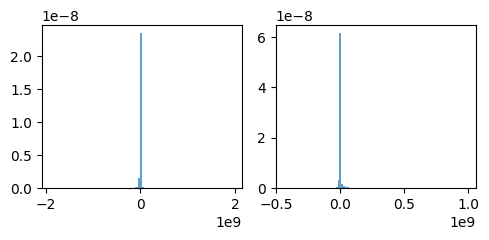

  HH: [[2.52e+11], [1.45e+10], [2.88e+09], ... [3.41e+11], [1.45e+12], [4.28e+09]]
 ---> Plotting ---> 


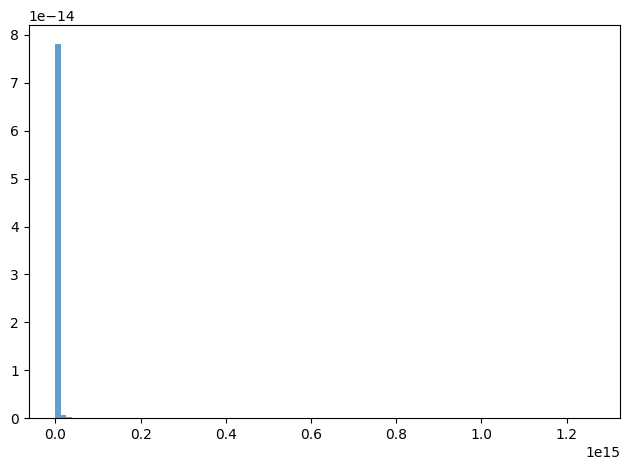

  PIVEC0: [[3.36e+12], [4.6e+11], [8.58e+10], ... [2.54e+12], [1.93e+13], [1.07e+11]]
  PIVEC1: [[6.02e+11], [-2.24e+11], [-1.07e+10], ... [-5.19e+11], [-1.43e+13], [-9.59e+10]]
  PIVEC2: [[-2.8e+12], [-2.01e+11], [-8.45e+10], ... [-1.24e+12], [-1.1e+13], [-3.57e+10]]
  PIVEC3: [[-1.75e+12], [3.48e+11], [-1.01e+10], ... [2.16e+12], [6.79e+12], [-3.06e+10]]
  out: [[{x: 6.02e+11, y: -2.8e+12, z: -1.75e+12, ... z: -3.06e+10, t: 1.07e+11}]]
 --- CLVEC --- : --- End ---
 --- CLAXI --- : --- Start ---
  d12: [[3.81e-06], [0], [-5.96e-08], [2.98e-08], ... [0], [1.91e-06], [0], [-2.33e-10]] 
  d13: [[9.54e-07], [0], [0], [0], [0], [-4.77e-07, ... 0], [-7.45e-09], [0], [0], [0], [0]] 
  d14:[[0], [-4.77e-07], [-4.77e-07], [0], [0], ... [-2.38e-07], [0], [6.1e-05], [0], [0]] 
  d23: [[-5.96e-08], [0], [1.46e-11], [1.86e-09], ... [0], [0], [0], [9.31e-10]] 
  d24: [[-3.81e-06], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [1.86e-09]] 
  d34: [[0], [0], [-5.82e-11], [0], [0], [-3.81e-06,

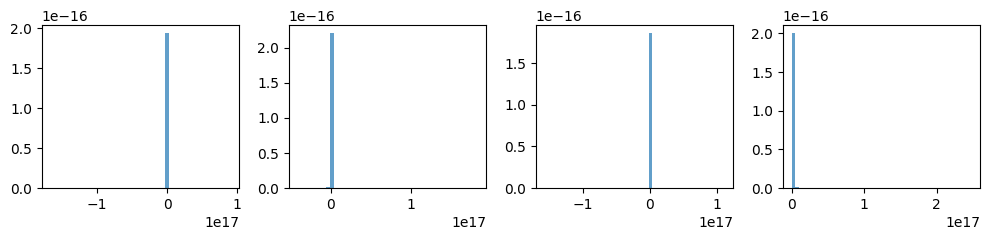

  CLA ===>
    px: [[-2.74e-05], [-0], [1.48e-09], [-1.15e-07], ... [-0], [-1.65e-05], [-0], [4.45e-08]]
    py: [[3.37e-05], [-1.45e-05], [1.67e-06], [-0], [-0, ... [-0], [0.000392], [0], [-0]]
    pz: [[-1.45e-05], [-2.27e-05], [-1.74e-05], ... [0.000228], [-0], [-5.73e-08]]
    E: [[-1.43e-05], [0], [2.08e-07], [-4.71e-07], ... [0], [1.43e-05], [0], [-2.31e-08]]
 ---> Plotting ---> 


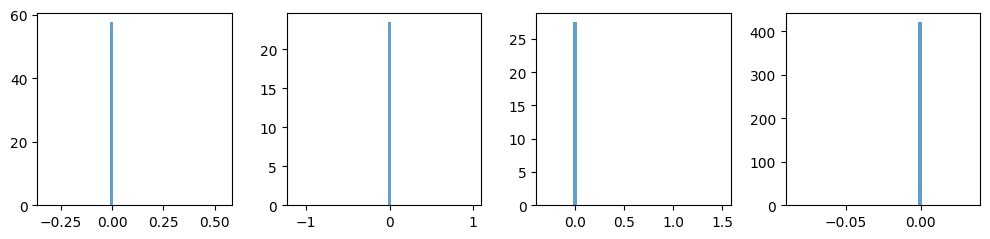

  P.CLV: [[-6.1e+13], [-2.62e+13], [-3.43e+12], ... [-4.1e+13], [-1.16e+15], [-5.15e+12]]
  P.CLA: [[-0.000921], [-1.66e-05], [5.86e-06], ... [0.00274], [0], [-1.42e-06]]
  omega: [[-6.1e+13], [-2.62e+13], [-3.43e+12], ... [-4.1e+13], [-1.16e+15], [-5.15e+12]]
 ---> Plotting ---> 


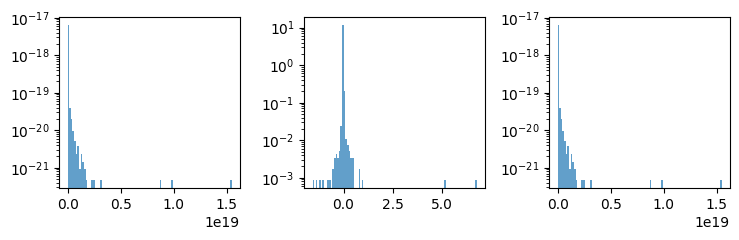

  P.mass: [[1.78], [1.78], [1.78], [1.78], [1.78], ... [1.77], [1.78], [1.78], [1.78], [1.78]]
  P.mass**2: [[3.16], [3.16], [3.16], [3.16], [3.16], ... [3.14], [3.16], [3.16], [3.16], [3.16]]
  CLA - CLV : [[{x: -6.02e+11, y: 2.8e+12, z: 1.75e+12, ... z: 3.06e+10, t: -1.07e+11}]]
  P*(P.dot(CLA) - P.dot(CLV)): [[{x: 3.39e+15, y: 1.48e+15, z: 9.22e+14, ... z: 2.65e+14, t: 3.22e+14}]]	[[{x: 3.39e+15, y: 1.48e+15, z: 9.22e+14, ... z: 2.65e+14, t: 3.22e+14}]]
  1/omega/P.mass: [[-9.22e-15], [-2.15e-14], [-1.64e-13], ... [-1.37e-14], [-4.86e-16], [-1.09e-13]]
  ~~~ PVC out ~~~ : [[{x: 98.7, y: 42.9, z: 26.7, t: 111}], ... {x: 61.1, y: 13.5, z: 91.6, t: 111}]]
 --- PVC --- : --- End --- 
  hvec : [[{x: -98.7, y: -42.9, z: -26.7}], [{x: -61.1, ... [{x: -61.1, y: -13.5, z: -91.6}]]
    x: [[-98.7], [-61.1], [-93.4], [99.7], [101], ... [-77], [61.1], [99], [-71.1], [-61.1]]
    y: [[-42.9], [-78.7], [-59.6], [-35.7], ... [91.9], [-31.1], [-82.9], [-13.5]]
    z: [[-26.7], [48.7], [-5.14], [-33

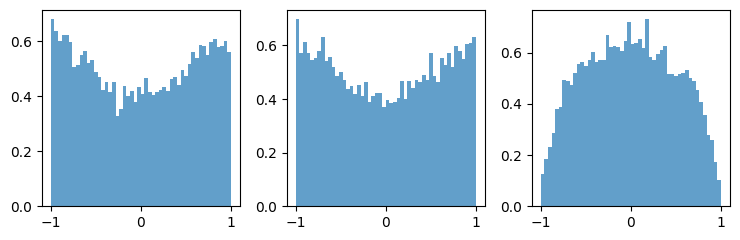

h2: unitvec
    x: [[-0.89], [-0.551], [-0.842], [0.898], ... [0.55], [0.892], [-0.641], [-0.551]]
    y: [[-0.387], [-0.71], [-0.537], [-0.322], ... [0.828], [-0.28], [-0.748], [-0.121]]
    z: [[-0.241], [0.439], [-0.0464], [-0.299], ... [0.107], [0.353], [0.174], [-0.826]]
 ---> Plotting ---> 


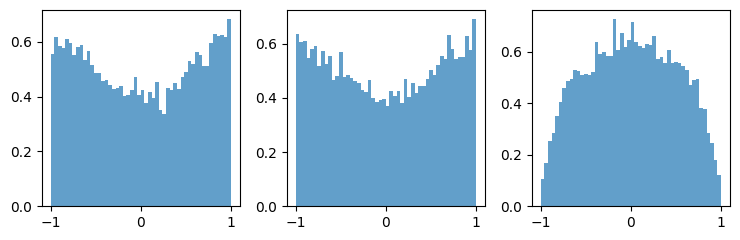

tau- hrest unit
    x: [[-0.889], [-0.551], [-0.842], [0.897], ... [0.551], [0.891], [-0.641], [-0.551]]
    y: [[-0.389], [-0.709], [-0.538], [-0.323], ... [0.828], [-0.282], [-0.747], [-0.122]]
    z: [[-0.242], [0.44], [-0.0465], [-0.301], ... [0.108], [0.356], [0.174], [-0.825]]
 ---> Plotting ---> 


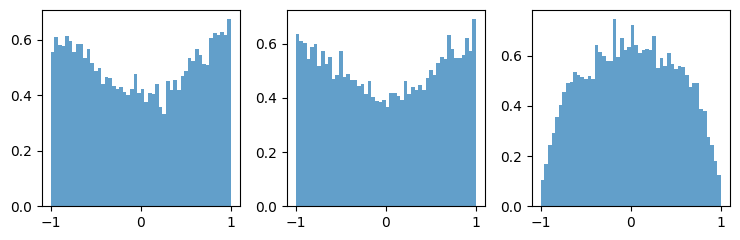

tau+ hrest unit
    x: [[0.889], [0.551], [0.842], [-0.897], ... [-0.551], [-0.891], [0.641], [0.551]]
    y: [[0.389], [0.709], [0.538], [0.323], ... [-0.828], [0.282], [0.747], [0.122]]
    z: [[0.242], [-0.44], [0.0465], [0.301], ... [-0.108], [-0.356], [-0.174], [0.825]]
 ---> Plotting ---> 


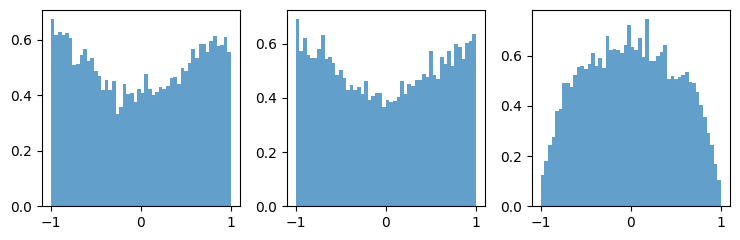

k1: unitvec
    x: [[0.0106], [-0.108], [0.00766], [-0.0887, ... -0.463], [-0.0708], [0.0592], [0.0279]]
    y: [[-0.546], [0.583], [-0.0979], [-0.8], ... [0.195], [0.688], [0.178], [-0.991]]
    z: [[0.838], [0.806], [0.995], [0.594], ... [0.865], [0.722], [0.982], [0.127]]
 ---> Plotting ---> 


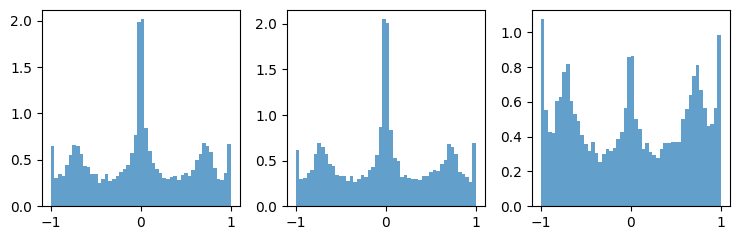

k2: unitvec
    x: [[-0.000616], [0.834], [-0.0228], [-0.0316], ... -0.307], [0.0671], [0.612], [0.379]]
    y: [[0.53], [-0.491], [0.121], [-0.727], ... [0.0808], [0.857], [-0.361], [-0.918]]
    z: [[-0.848], [0.252], [-0.992], [0.686], ... [0.948], [0.511], [0.704], [-0.118]]
 ---> Plotting ---> 


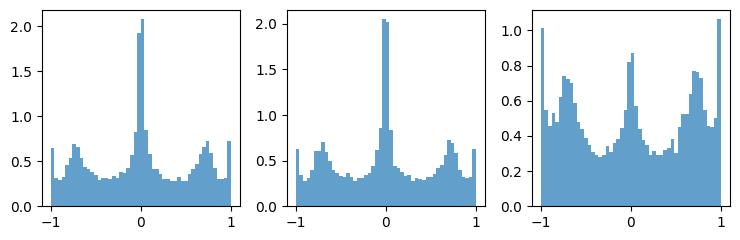

Angle: [[3.3e-07], [1.61e-07], [-6.64e-09], ... [1.63e-06], [1.05e-07], [2.68e-07]]
 ---> Plotting ---> 


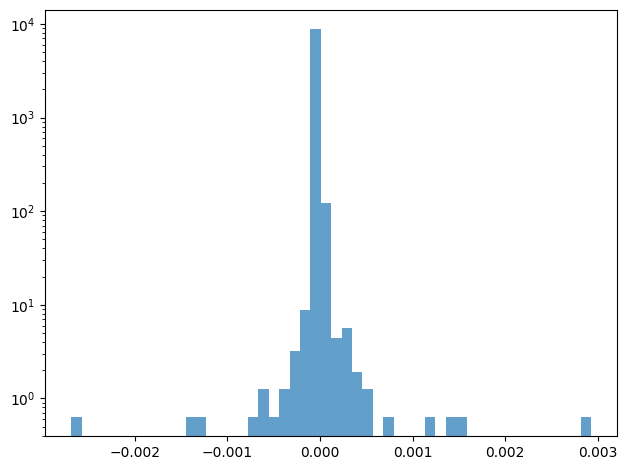

 ---> Plotting ---> 


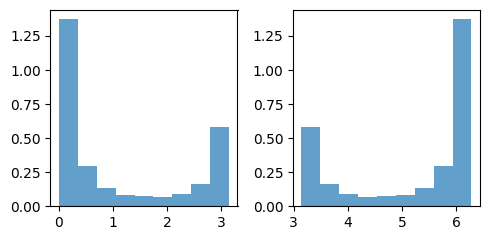

PhiCP: [[3.16], [4.54], [3.11], [6.15], [5.27], ... 0.586], [0.211], [5.98], [5.44], [5.84]]
 ---> Plotting ---> 


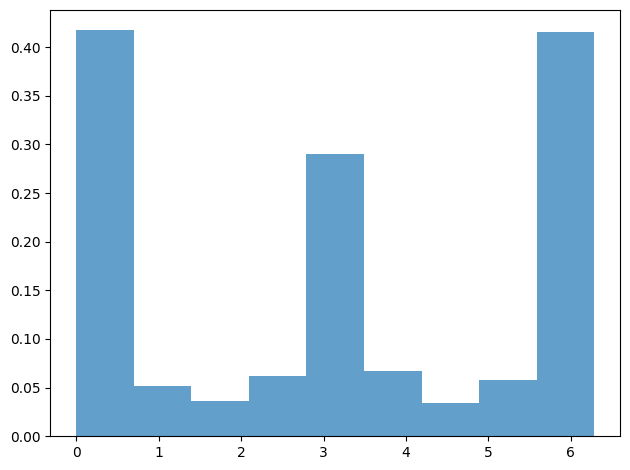

<Array [[3.16], [4.54], ... [5.44], [5.84]] type='14014 * option[var * ?float64]'>

In [65]:
phicp_obj = PhiCPComp(cat="a1a1", 
                      taum=taum,
                      taup=taup,
                      taum_decay=taum_children,
                      taup_decay=taup_children)
phicp = phicp_obj.comp_phiCP()
#phicp = phicp_obj.comp_PhiCP_DP()
phicp

 --- gethvecs_a1a1 --- 
Selection of a1-a1 pair [mask]: [False, False, False, False, False, False, ... False, False, False, False, False]
n total events: 684456
n selected events: 14014
Opposite ?????? [[3.14], [-3.14], [-3.14], [3.14], [-3.14, ... [3.14], [-3.14], [-3.14], [-3.14]]
 ---> Plotting ---> 


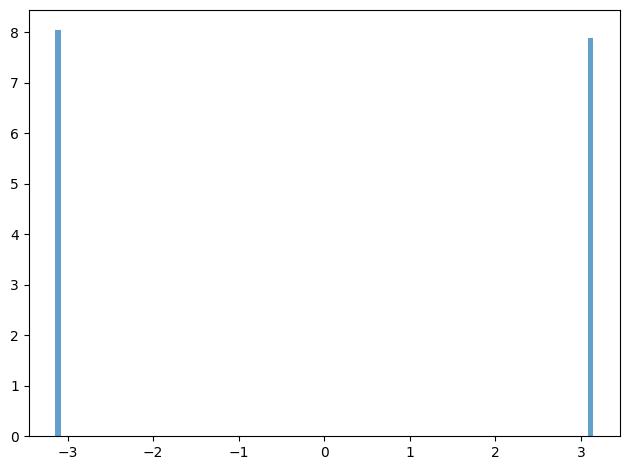

/Users/gsaha/anaconda3/envs/PyTorchEnv/lib/python3.11/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


vecPiZeroMinus: [[{x: -0.94, y: -0.273, z: -0.206}], ... [{x: -0.496, y: -0.173, z: -0.851}]]
vecPiMinus: [[{x: -0.887, y: -0.39, z: -0.248}], ... [{x: -0.475, y: -0.184, z: -0.86}]]
vecPiZeroPlus: [[{x: 0.902, y: 0.355, z: 0.246}], [{x: 0.498, ... [{x: 0.523, y: 0.173, z: 0.835}]]
vecPiPlus: [[{x: 0.887, y: 0.39, z: 0.248}], [{x: 0.56, ... [{x: 0.475, y: 0.184, z: 0.86}]]
 ---> Plotting ---> 


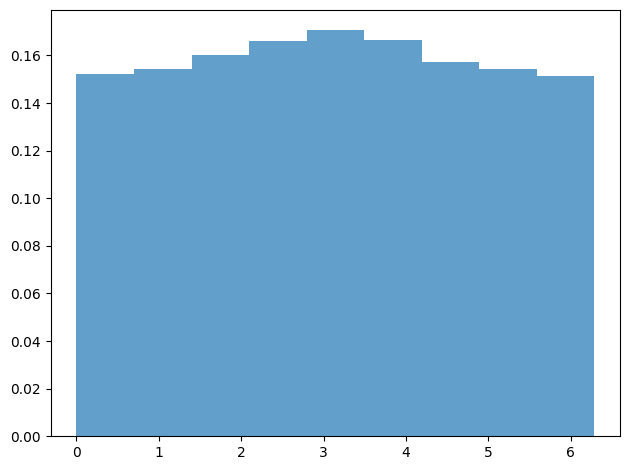

<Array [[6.02], [0.317], ... [0.61], [0.243]] type='14014 * option[var * ?float64]'>

In [50]:
phicp_obj = PhiCPComp(cat="a1a1", 
                      taum=taum,
                      taup=taup,
                      taum_decay=taum_children,
                      taup_decay=taup_children)
#phicp = phicp_obj.comp_phiCP()
phicp = phicp_obj.comp_PhiCP_DP()
phicp

In [51]:
"""
phicp_obj = PhiCPComp(cat="pipi", 
                      taum=taum,
                      taup=taup,
                      taum_decay=taum_children,
                      taup_decay=taup_children)
phicp = phicp_obj.comp_phiCP()
#phicp = phicp_obj.comp_PhiCP_DP()
phicp
"""

'\nphicp_obj = PhiCPComp(cat="pipi", \n                      taum=taum,\n                      taup=taup,\n                      taum_decay=taum_children,\n                      taup_decay=taup_children)\nphicp = phicp_obj.comp_phiCP()\n#phicp = phicp_obj.comp_PhiCP_DP()\nphicp\n'

In [52]:
"""
phicp_obj = PhiCPComp(cat="a1a1", 
                      taum=taum,
                      taup=taup,
                      taum_decay=taum_children,
                      taup_decay=taup_children)
phicp = phicp_obj.comp_phiCP()
phicp
"""

'\nphicp_obj = PhiCPComp(cat="a1a1", \n                      taum=taum,\n                      taup=taup,\n                      taum_decay=taum_children,\n                      taup_decay=taup_children)\nphicp = phicp_obj.comp_phiCP()\nphicp\n'

In [53]:
#ak.ravel(phicp)

In [54]:
#plothist(arrlist=[ak.ravel(phicp).to_numpy()], bins=9)

In [55]:
#10/2/5

In [56]:
from TComplex import TComplex

In [57]:
a = np.complex(2,2)
b = a

/var/folders/1h/pmwmdycj247fxs340zx84y5w0000gq/T/ipykernel_83664/1570323349.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.complex(2,2)


In [58]:
c = a**3

In [59]:
a, b, c

((2+2j), (2+2j), (-16+16j))

In [60]:
d = TComplex(2,2)
e = d

In [61]:
f = -e*e*e

In [62]:
d.Re(), e.Re(), f.Re()

(2, 2, 16)

In [63]:
d.Im(), e.Im(), f.Im()

(2, 2, -16)

In [64]:
f.Im()

-16